In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import pandas as pd

import sys

sys.path.append('T:\EL_experiment\Codes\CCEP_human\Python_Analysis/py_functions')

from scipy.stats import norm
from tkinter import *
import scipy
from scipy import signal

import platform
from glob import glob
from scipy.spatial import distance
import basic_func as bf
from scipy.integrate import simps
from numpy import trapz
import IO_func as IOF
import BM_func as BMf
import tqdm
from matplotlib.patches import Rectangle
from pathlib import Path
import LL_funcs as LLf
import freq_funcs as ff
#
from scipy.signal import hilbert, butter, filtfilt
import scipy.stats as stats
from tqdm.notebook import trange, tqdm
import significance_funcs as sig_func

dist_groups = np.array([[0, 30], [30, 60], [60, 120]])
dist_labels = ['local (<30 mm)', 'short (<60mm)', 'long']
Fs = 500
dur = np.zeros((1, 2), dtype=np.int32)
t0 = 1
dur[0, 0] = -t0
dur[0, 1] = 3

folder = 'BrainMapping'
# dur[0,:]       = np.int32(np.sum(abs(dur)))
x_ax = np.arange(dur[0, 0], dur[0, 1], (1 / Fs))
color_elab = np.zeros((3, 3))
color_elab[0, :] = np.array([31, 78, 121]) / 255
color_elab[1, :] = np.array([189, 215, 238]) / 255
color_elab[2, :] = np.array([0.256, 0.574, 0.431])
cwd = os.getcwd()

In [3]:
subj = 'EL011'
cond_folder = 'CR'  # Condition = 'Hour', 'Condition', 'Ph'

if cond_folder == 'Ph':
    cond_vals = np.arange(4)
    cond_labels = ['BM', 'BL', 'Fuma', 'BZD']
    cond_colors = ['#494159', '#594157', "#F1BF98", "#8FB996"]
    cond1 = 'Condition'  # 'condition', 'h'
    cond_folder = 'Ph'  # 'Ph', 'Sleep', 'CR'
    Condition = 'Condition'
if cond_folder == 'CR':
    Condition = 'Hour'  # Condition = 'Hour'
    cond1 = 'h'  # h (as stored in stimlist)

######## General Infos

path_patient_analysis = 'y:\\eLab\EvM\Projects\EL_experiment\Analysis\Patients\\' + subj
path_gen = os.path.join('y:\\eLab\Patients\\' + subj)
if not os.path.exists(path_gen):
    path_gen = 'T:\\EL_experiment\\Patients\\' + subj
path_patient = path_gen + '\Data\EL_experiment'  # os.path.dirname(os.path.dirname(cwd))+'/Patients/'+subj
path_infos = os.path.join(path_patient, 'infos')
if not os.path.exists(path_infos):
    path_infos = path_gen + '\\infos'

sep = ';'
Fs = 500
Path(path_patient_analysis + '\\' + folder + '/' + cond_folder + '/data').mkdir(parents=True, exist_ok=True)
Path(path_patient_analysis + '\\' + folder + '/' + cond_folder + '/BM_plot_trial').mkdir(parents=True, exist_ok=True)
Path(path_patient_analysis + '\\' + folder + '/' + cond_folder + '/figures/single_con').mkdir(parents=True,
                                                                                              exist_ok=True)
Path(path_patient_analysis + '\\' + folder + '/' + cond_folder + '/figures/Pipeline').mkdir(parents=True, exist_ok=True)

# get labels
if cond_folder == 'Ph':
    files_list = glob(path_patient_analysis + '\\' + folder + '/data/Stim_list_*Ph*')
else:
    files_list = glob(path_patient_analysis + '\\' + folder + '/data/Stim_list_*')
i = 0
stimlist = pd.read_csv(files_list[i])
# EEG_resp = np.load(path_patient + '/Analysis/' + folder + '/data/ALL_resps_'+files_list[i][-11:-4]+'.npy')
lbls = pd.read_excel(os.path.join(path_infos, subj + "_labels.xlsx"), header=0, sheet_name='BP')
labels_all, labels_region, labels_clinic, coord_all, StimChans, StimChanSM, StimChansC, StimChanIx, stimlist = bf.get_Stim_chans(
    stimlist,
    lbls)

labels_h = lbls.Hemisphere + '_' + labels_all

badchans = pd.read_csv(path_patient_analysis + '\\' + folder + '/data/badchan.csv')
bad_chans = np.unique(np.array(np.where(badchans.values[:, 1] == 1))[0, :])

bad_region = np.where((labels_region == 'WM') | (labels_region == 'OUT') | (labels_region == 'Putamen'))[0]

file_con = path_patient_analysis + '\\' + folder + '/' + cond_folder + '/data/con_trial_all.csv'
######### Load data
rerun = 0
if os.path.isfile(file_con):
    # con_trial
    con_trial = pd.read_csv(file_con)

In [4]:

##all
cond_vals = np.arange(4)
cond_labels = ['BM', 'BL', 'Fuma', 'BZD']
cond_colors = ['#494159', '#594157', "#F1BF98", "#8FB996"]

In [5]:
if platform.system() == 'Windows':
    # sep = ','
    path = 'y:\eLab\Patients\\'  # + subj
    CR_color = pd.read_excel("T:\EL_experiment\Patients\\" + 'all' + "\Analysis\BrainMapping\CR_color.xlsx",
                             header=0)
    regions = pd.read_excel("Y:\eLab\EvM\Projects\EL_experiment\Analysis\Patients\Across\elab_labels.xlsx",
                            sheet_name='regions',
                            header=0)

    # path_patient    = 'E:\PhD\EL_experiment\Patients\\'+subj # os.path.dirname(os.path.dirname(cwd))+'/Patients/'+subj
else:  # 'Darwin' for MAC
    path = '/Volumes/EvM_T7/PhD/EL_experiment/Patients/'  # + subj
    CR_color = pd.read_excel("/Volumes/EvM_T7/PhD/EL_experiment/Patients/all/Analysis/BrainMapping/CR_color.xlsx",
                             header=0)
    regions = pd.read_excel("/Volumes/EvM_T7/PhD/EL_experiment/Patients/all/elab_labels.xlsx", sheet_name='regions',
                            header=0)

sep = ';'
color_regions = regions.color.values
C = regions.label.values
cond_folder = 'CR'

In [55]:
#EEG_CR_file = path_patient_analysis + '\\' + folder + '\\' + cond_folder + '\\data\\EEG_'+cond_folder+'.npy'
#EEG_CR = np.load(EEG_CR_file)
#stimlist = pd.read_csv(path_patient_analysis + '\\' + folder + '\\' + cond_folder + '\\data\\Stimlist_'+cond_folder+'.csv')

EEG_CR = np.load(path_patient_analysis + '\\' + folder + '\\' + cond_folder + '\\data\\EEG_' + cond_folder + '.npy')
stimlist = pd.read_csv(
    path_patient_analysis + '\\' + folder + '\\' + cond_folder + '\\data\\stimlist_' + cond_folder + '.csv')


In [6]:
#file_MN1 = path_patient_analysis + '\\' + folder + '\\data\\M_N1.npy'
file_con = path_patient_analysis + '\\' + folder + '\\' + cond_folder + '\\data\\con_trial_all.csv'
con_trial = pd.read_csv(file_con)
# M_N1peaks = np.load(file_MN1)

In [22]:
s, t_p = scipy.stats.ttest_ind(data_con.loc[data_con.SleepState=='Wake','LL'].values, data_con.loc[data_con.SleepState=='NREM','LL'].values)

In [64]:
con_trial

,Chan,Stim,LL,P2P,LL_onset,Sig,Hour,SleepState,Block,Sleep,Num,Num_block,Date,Artefact,d
0,0.0,38.0,3.112841,265.986196,2.343089,1,15.0,Wake,1.0,0.0,0.0,0.0,20220215.0,0.0,35.68
1,0.0,40.0,2.724212,240.247410,0.000000,0,15.0,Wake,1.0,0.0,1.0,1.0,20220215.0,-1.0,35.35
2,0.0,19.0,2.371869,242.534783,2.343071,1,15.0,Wake,1.0,0.0,2.0,2.0,20220215.0,0.0,14.23
3,0.0,68.0,1.501889,145.296012,0.000000,0,15.0,Wake,1.0,0.0,3.0,3.0,20220215.0,0.0,75.99
4,0.0,27.0,1.853082,162.626234,0.000000,0,15.0,Wake,1.0,0.0,4.0,4.0,20220215.0,0.0,23.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558571,86.0,85.0,119.101393,13679.636849,0.000000,-1,13.0,Wake,69.0,0.0,10339.0,145.0,20220218.0,2.0,3.50
558572,86.0,47.0,5.375446,283.214409,0.000000,0,13.0,Wake,69.0,0.0,10340.0,146.0,20220218.0,-1.0,65.21
558573,86.0,49.0,3.795502,221.487138,2.978491,0,13.0,Wake,69.0,0.0,10341.0,147.0,20220218.0,0.0,67.77
558574,86.0,27.0,2.703691,98.190826,0.000000,0,13.0,Wake,69.0,0.0,10342.0,148.0,20220218.0,1.0,66.56


In [ ]:
29,2
48,36
24,69
19,40
14,0
19,14

Text(0, 0.5, 'LL')

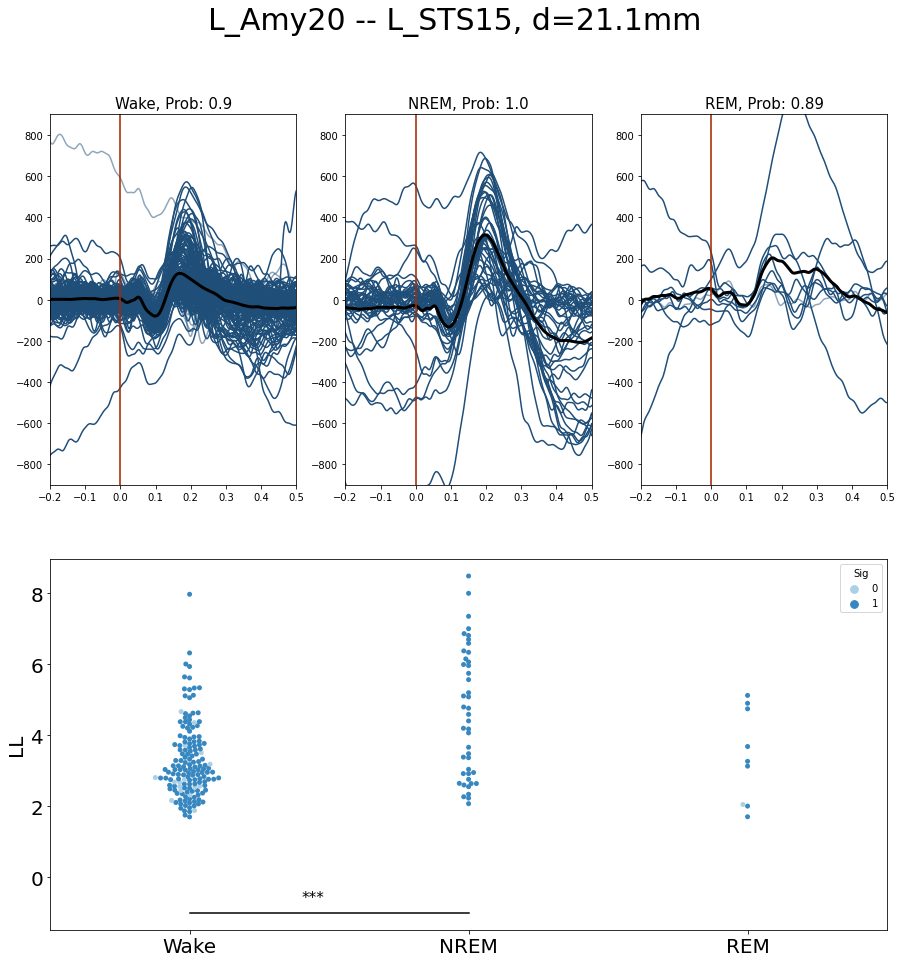

In [85]:
sc = 19
rc = 14
ylim = 900
## figure
fig = plt.figure(figsize=(15, 15))
fig.patch.set_facecolor('xkcd:white')
k = 3
d = np.round(distance.euclidean(coord_all[sc], coord_all[rc]), 1)
plt.suptitle(labels_h[sc] + ' -- ' + labels_h[rc] + ', d=' + str(d) + 'mm', fontsize=30)
gs = fig.add_gridspec(2, 3)  # GridSpec(4,1, height_ratios=[1,2,1,2])
k = 0
for ss in ['Wake', 'NREM', 'REM']:
    fig.add_subplot(gs[np.floor(k / 3).astype('int'), np.mod(k, 3)])
    plt.title(ss, fontsize=15)
    summ = con_trial[(con_trial.Artefact <1) & (con_trial.Stim == sc) & (con_trial.Chan == rc) & (
                con_trial.SleepState == ss)]  # (con_trial.Sleep==s)&
    sig = np.mean(summ.loc[summ.Sig > -1, 'Sig'])
    plt.title(ss + ', Prob: ' + str(np.round(sig, 2)), fontsize=15)
    for sig in [0, 1]:
        StimNum = summ.loc[summ.Sig == sig, 'Num'].values.astype('int')
        for i in range(len(StimNum)):
            plt.plot(x_ax, ff.lp_filter(EEG_CR[rc, StimNum[i]], 45, Fs), color=color_elab[0], alpha=0.5 * sig + 0.5)
    StimNum = summ.loc[summ.Sig > -1, 'Num'].values.astype('int')

    plt.plot(x_ax, ff.lp_filter(np.mean(EEG_CR[rc, StimNum, :], 0), 45, Fs), color=[0, 0, 0], linewidth=3, alpha=1)
    plt.xlim([-0.2, 0.5])
    plt.ylim([-ylim, ylim])
    plt.axvline(0, color=[0.8, 0.2, 0])
    plt.axvline(t0 - 1, color=[0, 0, 0], alpha=0.2)
    k = k + 1
ax_sns = fig.add_subplot(gs[1, :])
# summ = con_trial[(con_trial.Artefact <1) & (con_trial.Stim == sc) & (con_trial.Chan == rc)]
# sns.swarmplot(x='SleepState', y='LL', data=summ, hue='Sig', ax=ax_sns, size=10)
# plt.ylim([2, 8])
# plt.tight_layout()
data_con = con_trial[(con_trial.Stim==sc)&(con_trial.Chan==rc)&(con_trial.Artefact<1)]
sns.swarmplot(x='SleepState', y='LL', hue='Sig', data = data_con, palette='Blues')
s, t_p = scipy.stats.ttest_ind(data_con.loc[(data_con.Sig==1)&(data_con.SleepState=='Wake'),'LL'].values, data_con.loc[(data_con.Sig==1)&(data_con.SleepState=='NREM'),'LL'].values)
if t_p<0.05:
    plt.plot([0,1], [-1,-1], color=[0,0,0])
    plt.text(0.4, -0.7, '***', color=[0,0,0], fontsize=15)
    
s, t_p = scipy.stats.ttest_ind(data_con.loc[(data_con.Sig==1)&(data_con.SleepState=='Wake'),'LL'].values, data_con.loc[(data_con.Sig==1)&(data_con.SleepState=='REM'),'LL'].values)
if t_p<0.05:
    plt.plot([0,2], [-2,-2], color=[0,0,0])
    plt.text(1, -1.7, '***', color=[0,0,0])

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('')
plt.ylabel('LL',fontsize=20)
#plt.savefig(path_patient_analysis+'\\' + folder + '\\' + cond_folder +'\\BM_figures\\sig_trials\\t_resp\\con_'+str(sc)+'_'+str(rc)+'.svg')


Text(0, 0.5, 'LL')

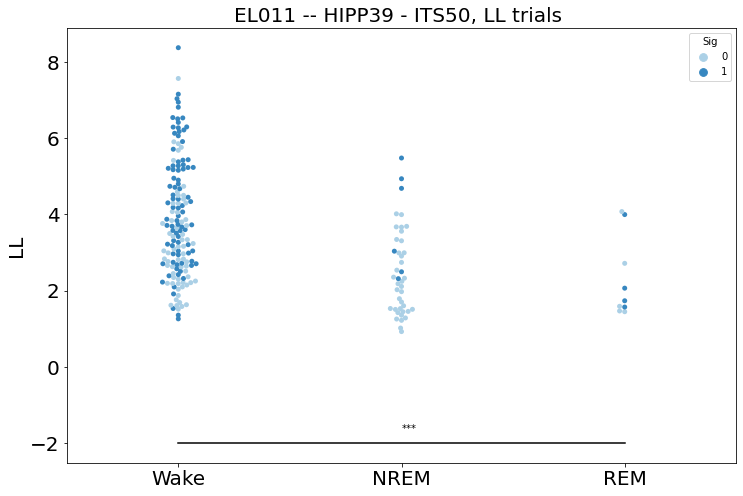

In [53]:
sc = 38
rc = 49
plt.figure(figsize=(12,8))
plt.title(subj + ' -- ' + labels_all[sc] + ' - ' + labels_all[rc]+', LL trials ', fontsize=20)
data_con = con_trial[(con_trial.Stim==sc)&(con_trial.Chan==rc)&(con_trial.Artefact<1)]
sns.swarmplot(x='SleepState', y='LL', hue='Sig', data = data_con, palette='Blues')
s, t_p = scipy.stats.ttest_ind(data_con.loc[(data_con.Sig==1)&(data_con.SleepState=='Wake'),'LL'].values, data_con.loc[(data_con.Sig==1)&(data_con.SleepState=='NREM'),'LL'].values)
if t_p<0.05:
    plt.plot([0,1], [-1,-1], color=[0,0,0])
    plt.text(0.4, -0.7, '***', color=[0,0,0], fontsize=15)
    
s, t_p = scipy.stats.ttest_ind(data_con.loc[(data_con.Sig==1)&(data_con.SleepState=='Wake'),'LL'].values, data_con.loc[(data_con.Sig==1)&(data_con.SleepState=='REM'),'LL'].values)
if t_p<0.05:
    plt.plot([0,2], [-2,-2], color=[0,0,0])
    plt.text(1, -1.7, '***', color=[0,0,0])

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('')
plt.ylabel('LL',fontsize=20)

## Cluster trials into 2-3 groups

In [7]:
import Cluster_func as Cf

In [8]:
Fs_rs = 100
num_rs = int(2000 / Fs * Fs_rs)

In [9]:
def search_sequence_numpy(arr, seq):
    """ Find sequence in an array using NumPy only.

    Parameters
    ----------
    arr    : input 1D array
    seq    : input 1D array

    Output
    ------
    Output : 1D Array of indices in the input array that satisfy the
    matching of input sequence in the input array.
    In case of no match, an empty list is returned.
    """

    # Store sizes of input array and sequence
    Na, Nseq = arr.size, seq.size

    # Range of sequence
    r_seq = np.arange(Nseq)

    # Create a 2D array of sliding indices across the entire length of input array.
    # Match up with the input sequence & get the matching starting indices.
    M = (arr[np.arange(Na - Nseq + 1)[:, None] + r_seq] == seq).all(1)

    # Get the range of those indices as final output
    if M.any() > 0:
        return np.where(np.convolve(M, np.ones((Nseq), dtype=int)) > 0)[0]
    else:
        return []  # No match found

In [11]:
con_trial.groupby(['Stim', 'Chan'])

In [12]:
con_trial

,Chan,Stim,LL,P2P,Hour,Sig,SleepState,Block,Sleep,Num,Num_block,Date,Artefact,d
0,0.0,38.0,3.112841,265.986196,15.0,0.0,Wake,1.0,0.0,0.0,0.0,20220215.0,0.0,35.68
1,0.0,40.0,2.724212,240.247410,15.0,0.0,Wake,1.0,0.0,1.0,1.0,20220215.0,-1.0,35.35
2,0.0,19.0,2.371869,242.534783,15.0,2.0,Wake,1.0,0.0,2.0,2.0,20220215.0,0.0,14.23
3,0.0,68.0,1.501889,145.296012,15.0,0.0,Wake,1.0,0.0,3.0,3.0,20220215.0,0.0,75.99
4,0.0,27.0,1.853082,162.626234,15.0,0.0,Wake,1.0,0.0,4.0,4.0,20220215.0,0.0,23.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558571,86.0,85.0,119.101393,13679.636849,13.0,-1.0,Wake,69.0,0.0,10339.0,145.0,20220218.0,1.0,3.50
558572,86.0,47.0,5.375446,283.214409,13.0,0.0,Wake,69.0,0.0,10340.0,146.0,20220218.0,-1.0,65.21
558573,86.0,49.0,3.795502,221.487138,13.0,0.0,Wake,69.0,0.0,10341.0,147.0,20220218.0,0.0,67.77
558574,86.0,27.0,2.703691,98.190826,13.0,-1.0,Wake,69.0,0.0,10342.0,148.0,20220218.0,1.0,66.56


In [23]:
207/3/69

1.0

In [22]:
summ[summ.LL>207]

,Stim,Chan,LL


In [13]:
summ = con_trial.groupby(['Stim', 'Chan'], as_index=False)[['LL']].count()

In [20]:
np.median(summ.loc[summ.Chan==0,'LL']).astype('int')

207

In [10]:
stop

NameError: name 'stop' is not defined

###  get GT for all connections

In [ ]:
from tslearn.clustering import TimeSeriesKMeans

In [ ]:
def dba_cluster(X, n=2, method = 'dtw'):
    X = np.expand_dims(X,-1)
    km_dba  = TimeSeriesKMeans(n_clusters=n, metric=method, max_iter=10, max_iter_barycenter=10, random_state=0).fit(X)
    cc      = km_dba.cluster_centers_
    y       = km_dba.predict(X)
    dist    = km_dba.transform(X)
    dist_cc = np.max(km_dba.transform(km_dba.cluster_centers_))
    return cc[:, :, 0], y, dist, dist_cc

In [ ]:
def get_GT_euc(sc, rc, LL_CCEP, EEG_resp, Fs=500, t_0=1, w_cluster=1, n_cluster=2, method= "euclidean"):
    Fs_rs = 100
    t_resp = 0
    num_rs = int(EEG_resp.shape[-1] / Fs * Fs_rs)
    w = 0.25
    lists = LL_CCEP[(LL_CCEP['Artefact'] == 0) & (LL_CCEP['Chan'] == rc) & (LL_CCEP['Stim'] == sc)]
    stimNum_all = lists.Num.values.astype('int')
    M_GT = np.zeros((n_cluster + 1, 2000))
    if len(stimNum_all) > 0:
        # get overall mean and two clusters
        EEG_trial = ff.lp_filter(EEG_resp[rc, stimNum_all, :], 45, Fs)
        EEG_trial = signal.resample(EEG_trial, int(num_rs), axis=1)
        EEG_trial = stats.zscore(EEG_trial, axis=1)
        cc, y, dist, dist_cc = Cf.dba_cluster(
            EEG_trial[:, int((t_0 + t_resp) * Fs_rs):int((t_0 + t_resp + w_cluster) * Fs_rs)], n_cluster, method)

        M_GT[0, :] = ff.lp_filter(np.nanmean(EEG_resp[rc, stimNum_all, :], 0), 45, Fs)
        for c in range(n_cluster):
            M_GT[c + 1, :] = ff.lp_filter(np.nanmean(EEG_resp[rc, stimNum_all[y == c], :], 0), 45, Fs)
    else:
        r = 0
        t_resp = 0

    return M_GT,y

In [ ]:
EEG_CR

In [ ]:
sc = 0
rc = 3
M_GT = get_GT_euc(sc, rc, con_trial, EEG_CR, Fs=500, t_0=1, w_cluster=1, n_cluster=2)

In [ ]:
labels = ['Mean', 'GT1', 'GT2']
for i in range(len(M_GT)):
    plt.plot(x_ax, M_GT[i], label = labels[i])
plt.legend()

In [ ]:
colors_GT = np.zeros((3,3))
colors_GT[1,:] = color_elab[0]
colors_GT[2,:] = color_elab[2]

In [ ]:
delay
sc = 18
rc = 65
# 
sc = 38
rc = 49

In [ ]:
int((1+w_cluster)*Fs)

In [ ]:
M_t_resp[sc,rc,0]

In [ ]:
sc = 19
rc = 40

24, 69

In [ ]:
sc = 19
rc = 40
w = 0.25

t_resp =  M_t_resp[sc,rc,0]
ylim = 500
dat = con_trial[(con_trial.Stim == sc) & (con_trial.Chan == rc) & (con_trial.Artefact == 0)]

if len(dat) >0:

    
    #all
    n_cluster = 2
    w_cluster = 0.25
    method = "euclidean"
    plt.figure(figsize=(15, 7))
    plt.title(subj + ' -- ' + labels_all[sc] + ' - ' + labels_all[rc]+', Cluserting: '+method, fontsize=20)
    M_GT,y = get_GT_euc(sc, rc, con_trial, EEG_CR, Fs=500, t_0=1+t_resp, w_cluster=w_cluster, n_cluster=2, method = method)
    p = np.corrcoef(M_GT[1, int((1+t_resp)*Fs):int((1+t_resp+w_cluster)*Fs)], M_GT[2, int((1+t_resp)*Fs):int((1+t_resp+w_cluster)*Fs)])[0, 1]
    labels = ['Mean', 'GT1', 'GT2']
    for i in range(len(M_GT)):
        n = len(y)
        if i>0:
            n = np.sum(y==i-1)
        plt.plot(x_ax, M_GT[i], label = labels[i]+', n: '+str(n), alpha =(i>0)*0.6+0.4, linewidth=4, color= colors_GT[i])

    plt.legend()
    plt.xlim([-1, 3])
    plt.legend(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel('time [s]', fontsize=20)
    plt.ylabel('[uV]', fontsize=20)
    plt.xticks(fontsize=15)
    plt.axvline(0, color=[0, 0, 0])
    plt.axvspan(0+t_resp, 0+t_resp+w_cluster, color=[0,0,0], alpha=0.2)
    plt.ylim([-ylim, ylim])
    plt.text(w_cluster/3, 300, 'Cluster window', fontsize=10)
    plt.text(w_cluster+0.2, 300, 'GT1 - GT2 Pearson: '+str(np.round(p,2)), fontsize=20)
    plt.tight_layout()
    # plt.savefig(path_patient_analysis+'\\' + folder + '\\' + cond_folder +'\\BM_figures\\sig_trials\\GT_cluster\\con_'+str(sc)+'_'+str(rc)+'.jpg')

## Responsive channel

In [ ]:
def get_GT_euc(rc, stimNum_all, EEG_resp, Fs=500, t_0=1, w_cluster=1, n_cluster=2, method= "euclidean"):
    Fs_rs = 100
    t_resp = 0
    num_rs = int(EEG_resp.shape[-1] / Fs * Fs_rs)
    w = 0.25
    M_GT = np.zeros((n_cluster + 1, 2000))
    stimNum_all = stimNum_all[~np.isnan(np.mean(EEG_resp[rc,stimNum_all],1))]
    if len(stimNum_all) > 0:
        #f = np.repeat(np.expand_dims(np.random.choice([-1,1],(len(stimNum_all),)),0),400,0).T
        # get overall mean and two clusters
        EEG_trial = ff.lp_filter(EEG_resp[rc, stimNum_all, :], 45, Fs)
        EEG_trial = signal.resample(EEG_trial, int(num_rs), axis=1)
        EEG_trial = stats.zscore(EEG_trial, axis=1)#*f
        cc, y, dist, dist_cc = Cf.dba_cluster(
            EEG_trial[:, int((t_0 + t_resp) * Fs_rs):int((t_0 + t_resp + w_cluster) * Fs_rs)], n_cluster, method)

        M_GT[0, :] = ff.lp_filter(np.nanmean(EEG_resp[rc, stimNum_all, :], 0), 45, Fs)
        for c in range(n_cluster):
            M_GT[c + 1, :] = ff.lp_filter(np.nanmean(EEG_resp[rc, stimNum_all[y == c], :], 0), 45, Fs)

    return M_GT,y

In [ ]:
np.max(M_t_resp[:,:,1])


In [ ]:
pear_surr,thr,p = get_pear_surr(dat, rc,EEG_CR)

In [ ]:
def get_pear_surr(dat, rc,EEG_CR):
    n_trials = len(dat)
    # other trials
    stim_trials = np.unique(
        con_trial.loc[(con_trial.Stim >= rc - 1) & (con_trial.Stim <= rc + 1), 'Num'].values.astype('int'))
    StimNum = np.unique(con_trial.Num)#np.random.choice(np.unique(con_trial.Num), size=400)
    StimNum = [i for i in StimNum if i not in stim_trials]
    StimNum = [i for i in StimNum if i not in stim_trials + 1]
    StimNum = [i for i in StimNum if i not in stim_trials -1 ]


    pear_surr = np.zeros((1,))-1
    w_cluster = 0.9
    for i in range(200):
        StimNum_surr = np.random.choice(StimNum, size=n_trials).astype('int')
        M_GT,y = get_GT_euc(rc, StimNum_surr, EEG_CR, Fs=500, t_0=t_resp, w_cluster=w_cluster, n_cluster=2, method= "euclidean")
        p = np.corrcoef(M_GT[1, int((t_resp)*Fs):int((t_resp+w_cluster)*Fs)], M_GT[2, int((t_resp)*Fs):int((t_resp+w_cluster)*Fs)])[0, 1]
        pear_surr  = np.concatenate([pear_surr,[p]],0)
        t_resp = 3
        M_GT,y = get_GT_euc(rc, StimNum_surr, EEG_CR, Fs=500, t_0=t_resp, w_cluster=w_cluster, n_cluster=2, method= "euclidean")
        p = np.corrcoef(M_GT[1, int((t_resp)*Fs):int((t_resp+w_cluster)*Fs)], M_GT[2, int((t_resp)*Fs):int((t_resp+w_cluster)*Fs)])[0, 1]
        pear_surr  = np.concatenate([pear_surr,[p]],0)
        
    M_GT,y = get_GT_euc(rc, dat.Num.astype('int'), EEG_CR, Fs=500, t_0=1, w_cluster=w_cluster, n_cluster=2,method= "euclidean")
    p = np.corrcoef(M_GT[1, int((1)*Fs):int((1+w_cluster)*Fs)], M_GT[2, int((1)*Fs):int((1+w_cluster)*Fs)])[0, 1]
    thr = np.percentile(pear_surr,99)

    return pear_surr,thr,p

In [ ]:
M_sig_con = M_sig_con[1:,:]

In [ ]:
M_sig_con_pd = pd.DataFrame(M_sig_con, columns=['Stim', 'Rec', 'M_LL', 'M_p'])

In [ ]:
M_sig_con = np.zeros((1,4))
for sc in np.unique(con_trial.Stim).astype('int'):
    for rc in np.unique(con_trial.Chan).astype('int'):
        dat = con_trial[(con_trial.Stim == sc) & (con_trial.Chan == rc) & (con_trial.Artefact == 0)]
        if len(dat) >0:
            M_LL = M_t_resp[sc,rc,1]
            pear_surr,thr,p = get_pear_surr(dat, rc,EEG_CR)
            M_p = p>thr
            M_sig_con1 = np.zeros((1,4))
            M_sig_con1[0] = [sc, rc, M_LL, M_p]
            M_sig_con = np.concatenate([M_sig_con, M_sig_con1],0)
            
            
    

In [ ]:
M_sig_con_pd

In [ ]:
TP, FP, TN, FN = perf_measure(M_sig_con_pd.M_LL, M_sig_con_pd.M_p)

In [ ]:
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
            TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
            FP += 1
        if y_actual[i]==y_hat[i]==0:
            TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
            FN += 1

    return(TP, FP, TN, FN)

In [ ]:

cm = [[TP, FP], [TN, FN]] # TP, FP, FN, TN
sns.set(font_scale=3)
plt.figure(figsize=(7, 7))
ax = sns.heatmap(data=[[1, 0], [0, 1]], cmap=sns.color_palette(['tomato', 'lightgreen'], as_cmap=True),
                 annot=[[f"TP={cm[0][0]:.0f}", f"FP={cm[0][1]:.0f}"], [f"FN={cm[1][0]:.0f}", f"TN={cm[1][1]:.0f}"]],
                 fmt='', annot_kws={'fontsize': 30}, cbar=False, square=True)

ax.set_xlabel('LL Method')
ax.set_ylabel('Pearson Method')
ax.tick_params(length=0, labeltop=True, labelbottom=False)
ax.xaxis.set_label_position('top')
ax.set_xticklabels(['Positive', 'Negative'])
ax.set_yticklabels(['Positive', 'Negative'], rotation=90, va='center')
ax.add_patch(plt.Rectangle((0, 1), 1, 0.1, color='yellow', clip_on=False, zorder=0, transform=ax.transAxes))
ax.add_patch(plt.Rectangle((0, 0), -0.1, 1, color='yellow', clip_on=False, zorder=0, transform=ax.transAxes))
plt.tight_layout()
plt.show()

In [ ]:
dat_channels = M_sig_con_pd[(M_sig_con_pd.M_p==0)&(M_sig_con_pd.M_LL==1)]

In [ ]:
 sns.set(style='white')

In [ ]:
k = 10
w = 0.25
sc = dat_channels.Stim.values[k].astype('int')
rc = dat_channels.Rec.values[k].astype('int')
dat = con_trial[(con_trial.Stim == sc) & (con_trial.Chan == rc) & (con_trial.Artefact == 0)]

# resp_all = bf.zscore_CCEP(ff.lp_filter(np.nanmean(EEG_CR[rc, dat.Num.values.astype('int'), :], 0), 40, Fs))
resp_all = ff.lp_filter(np.nanmean(bf.zscore_CCEP(EEG_CR[rc, dat.Num.values.astype('int'), :]), 0), 40, Fs)
st = ff.lp_filter(np.nanstd(bf.zscore_CCEP(EEG_CR[rc, dat.Num.values.astype('int'), :]), 0), 40, Fs)
LL_resp = LLf.get_LL_all(np.expand_dims(np.expand_dims(resp_all, 0), 0), Fs, w)
thr = np.percentile(np.concatenate(
    [LL_resp[0, 0, int((w / 2) * Fs):int((t_0 - w / 2) * Fs)], LL_resp[0, 0, int((3) * Fs):int((4 - w / 2) * Fs)]]),
                    99)  # LL_resp[0, 0, int((t_0+0.5) * Fs):] = 0 * Fs):] = 0
LL_t = np.array(LL_resp[0, 0, :int((t_0 + 0.5) * Fs)] > thr) * 1
t_resp_all = search_sequence_numpy(LL_t, np.ones((int((w + 0.07) * Fs),)))
if len(t_resp_all) > 0:
    t_resp = t_resp_all[0] / Fs - t_0 + w / 2
    r = 1
    if (t_resp < 0.01) | (t_resp > 0.5):
        t_resp = 0
else:
    r = 0
    t_resp = 0

## figure
fig = plt.figure(figsize=(20, 20))
fig.patch.set_facecolor('xkcd:white')
d = np.round(distance.euclidean(coord_all[sc], coord_all[rc]), 1)
plt.suptitle(labels_all[sc] + ' -- ' + labels_all[rc] + ', d=' + str(d) + 'mm', fontsize=30)
gs = fig.add_gridspec(2, 1)  # GridSpec(4,1, height_ratios=[1,2,1,2])

ax_CCEP = fig.add_subplot(gs[0, 0])
plt.title('Mean of z-scored trials', fontsize=30)
plt.plot(x_ax, resp_all, color=[0, 0, 0], linewidth=5, label='n: ' + str(len(dat)))
plt.fill_between(x_ax, resp_all - st, resp_all + st, alpha=0.1, color=[0, 0, 0])
plt.xlim([-1, 3])
plt.ylabel('')
plt.xticks([])
plt.axvline(t_resp, color=[1, 0, 0], label='start resp', linewidth=5)
plt.axvline(0, color=[0, 0, 0], linewidth=5)
ylim = np.max([3, 1.2 * np.max(abs(resp_all))])
plt.ylim([-ylim, ylim])
plt.yticks(fontsize=25)
plt.legend(fontsize=25)

ax = fig.add_subplot(gs[1, 0])
plt.title('LL w=250ms', fontsize=30)
plt.ylabel('[z-score/ms]', fontsize=30)
plt.axvline(0, color=[0, 0, 0], linewidth=5)
plt.plot(x_ax, LL_resp[0, 0, :], color=[0, 0, 0], linewidth=5)
plt.axhline(thr, label='99th')
plt.ylim([0, np.max([np.max(LL_resp[0, 0, :]) + 0.01, 0.1])])
if r:
    plt.plot(t_resp_all[0] / Fs - t_0, LL_resp[0, 0, t_resp_all[0]], 'o', color=[1, 0, 0], markersize=10)
    plt.axvline(t_resp, color=[1, 0, 0], label='start resp', linewidth=5)
    ax.annotate('', xy=(t_resp, LL_resp[0, 0, t_resp_all[0]]),
                xytext=(t_resp_all[0] / Fs - t_0, LL_resp[0, 0, t_resp_all[0]]),
                arrowprops={'arrowstyle': '-|>', 'lw': 2, 'color': 'red'}, va='center')
    #plt.fill_between(x_ax, mn-st, mn+st, alpha=0.2, color=color_elab[c*2])
    plt.axvspan(t_resp, t_resp + w, alpha=0.1)
    ax_CCEP.axvspan(t_resp, t_resp + w, alpha=0.2)
plt.legend(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel('time [s]', fontsize=30)
plt.xticks(fontsize=25)
plt.xlim([-1, 3])
# plt.savefig(path_patient_analysis+'\\' + folder + '\\' + cond_folder +'\\BM_figures\\sig_trials\\t_resp\\con_'+str(sc)+'_'+str(rc)+'.jpg')
#plt.savefig(path_patient_analysis+'\\' + folder + '\\' + cond_folder +'\\BM_figures\\sig_trials\\t_resp\\con_'+str(sc)+'_'+str(rc)+'.svg')

plt.savefig('Y:\\eLab\\EvM\\Projects\\EL_experiment\\Methods\\BrainMapping\\Significant_Connection\\LL\\'+subj+'_'+labels_all[sc]+'_'+labels_all[rc]+'.svg')


In [ ]:

n_trials = len(dat)
# other trials
stim_trials = np.unique(
    con_trial.loc[(con_trial.Stim >= rc - 1) & (con_trial.Stim <= rc + 1), 'Num'].values.astype('int'))
StimNum = np.unique(con_trial.Num)#np.random.choice(np.unique(con_trial.Num), size=400)
StimNum = [i for i in StimNum if i not in stim_trials]
StimNum = [i for i in StimNum if i not in stim_trials + 1]
StimNum = [i for i in StimNum if i not in stim_trials -1 ]


pear_surr = np.zeros((1,))-1
w_cluster = 0.9
for i in range(200):
    StimNum_surr = np.random.choice(StimNum, size=n_trials).astype('int')
    t_resp = 0
    M_GT,y = get_GT_euc(rc, StimNum_surr, EEG_CR, Fs=500, t_0=t_resp, w_cluster=w_cluster, n_cluster=2, method= "euclidean")
    p = np.corrcoef(M_GT[1, int((t_resp)*Fs):int((t_resp+w_cluster)*Fs)], M_GT[2, int((t_resp)*Fs):int((t_resp+w_cluster)*Fs)])[0, 1]
    pear_surr  = np.concatenate([pear_surr,[p]],0)
    t_resp = 3
    M_GT,y = get_GT_euc(rc, StimNum_surr, EEG_CR, Fs=500, t_0=t_resp, w_cluster=w_cluster, n_cluster=2, method= "euclidean")
    p = np.corrcoef(M_GT[1, int((t_resp)*Fs):int((t_resp+w_cluster)*Fs)], M_GT[2, int((t_resp)*Fs):int((t_resp+w_cluster)*Fs)])[0, 1]
    pear_surr  = np.concatenate([pear_surr,[p]],0)

In [ ]:
M_GT,y = get_GT_euc(rc, dat.Num.astype('int'), EEG_CR, Fs=500, t_0=1, w_cluster=w_cluster, n_cluster=2,method= "euclidean")
p = np.corrcoef(M_GT[1, int((1)*Fs):int((1+w_cluster)*Fs)], M_GT[2, int((1)*Fs):int((1+w_cluster)*Fs)])[0, 1]



## figure
ylim = 600
fig = plt.figure(figsize=(20, 8))
fig.patch.set_facecolor('xkcd:white')
d = np.round(distance.euclidean(coord_all[sc], coord_all[rc]), 1)
plt.suptitle(labels_all[sc] + ' -- ' + labels_all[rc] + ', d=' + str(d) + 'mm', fontsize=30)
gs = fig.add_gridspec(1,2, width_ratios=[1,3]) # GridSpec(4,1, height_ratios=[1,2,1,2])

ax_CCEP = fig.add_subplot(gs[0, 0])
plt.hist(pear_surr, color=[0,0,0], alpha=0.3, label='surrogates (n: 400)')
plt.xlim([-1.1,1.1])
plt.axvline(np.percentile(pear_surr,99),color=[1,0,0], label='99th')
plt.axvline(np.percentile(pear_surr,95),color=[1,0,0], label='95th')
plt.axvline(p,color=color_elab[0], label='Test')
plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Pearson Correlation GT1 - GT2', fontsize=20)
plt.ylabel('Number of Tests', fontsize=20)

ax_GT = fig.add_subplot(gs[0, 1])
labels = ['Mean', 'GT1', 'GT2']
for i in range(len(M_GT)):
    n = len(y)
    if i>0:
        n = np.sum(y==i-1)
    plt.plot(x_ax, M_GT[i], label = labels[i]+', n: '+str(n), alpha =(i>0)*0.6+0.4, linewidth=4, color= colors_GT[i])

plt.xlim([-0.5, 2])
plt.legend(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('time [s]', fontsize=20)
plt.ylabel('[uV]', fontsize=20)
plt.xticks(fontsize=15)
plt.axvline(0, color=[0, 0, 0])
plt.axvspan(0, 0+w_cluster, color=[0,0,0], alpha=0.1)
plt.ylim([-ylim, ylim])
plt.text(w_cluster/3, -9/10*ylim, 'Cluster window', fontsize=10)
plt.text(1, -2/3*ylim, 'GT1 - GT2 Pearson: '+str(np.round(p,2)), fontsize=20)
plt.savefig('Y:\\eLab\\EvM\\Projects\\EL_experiment\\Methods\\BrainMapping\\Significant_Connection\\Cluster\\'+subj+'_'+labels_all[sc]+'_'+labels_all[rc]+'.svg')


In [ ]:
suuuuuu

In [ ]:
##againt surrogate
t_resp = M_t_resp[sc, rc, 0]
M_GT = M_GT_all[sc, rc]
dat = con_trial[(con_trial.Stim == sc) & (con_trial.Chan == rc) & (con_trial.Artefact < 1)]
EEG_trials = ff.lp_filter(EEG_CR[[[rc]], dat.Num.values.astype('int'), :], 45, Fs)
LL_trials = LLf.get_LL_all(EEG_trials, Fs, w_cluster)
# surr
exp = 2
pear_surr_all = []
for t_test in [0, 0.1, 0.2, 0.5, 1.5, 2, 2.5]:
    pear = sig_func.get_pearson2mean(M_GT[1, :], EEG_trials[0], tx=t_0 + t_resp, ty=t_test, win=w_cluster,
                                     Fs=500)  # Pearson# Pearson
    pear2 = sig_func.get_pearson2mean(M_GT[2, :], EEG_trials[0], tx=t_0 + t_resp, ty=t_test, win=w_cluster,
                                      Fs=500)  # Pearson# Pearson
    LL = LL_trials[0, :, int(t_test + w_cluster / 2) * Fs]
    #pear_surr = np.arctanh(np.max([pear,pear2],0))*LL
    pear_surr = np.sign(np.max([pear, pear2], 0)) * abs(np.max([pear, pear2], 0) ** exp) * LL  #*np.sqrt(LL)
    pear_surr_all = np.concatenate([pear_surr_all, pear_surr])

# real
t_test = t_0 + t_resp
pear = sig_func.get_pearson2mean(M_GT[1, :], EEG_trials[0], tx=t_0 + t_resp, ty=t_test, win=w_cluster,
                                 Fs=500)  # Pearson# Pearson
pear2 = sig_func.get_pearson2mean(M_GT[2, :], EEG_trials[0], tx=t_0 + t_resp, ty=t_test, win=w_cluster,
                                  Fs=500)  # Pearson# Pearson
LL = LL_trials[0, :, int(t_test + w_cluster / 2) * Fs]
# pear = np.arctanh(np.max([pear,pear2],0))*LL#np.sign(np.max([pear,pear2],0))*abs(np.max([pear,pear2],0)**exp)*LL
pear = np.sign(np.max([pear, pear2], 0)) * abs(np.max([pear, pear2], 0) ** exp) * LL  #*np.sqrt(LL)
sig = (pear > np.nanpercentile(pear_surr_all, 95)) * 1

plt.figure(figsize=(20, 20))
plt.title('Surrogate Testing', fontsize=40)
plt.hist(pear_surr_all, label='surr', color=[0, 0, 0], alpha=0.3)
plt.axvline(np.nanpercentile(pear_surr_all, 95), color=[1, 0, 0], label='95th')
plt.hist(pear, label='trials', color=color_elab[0], alpha=0.6)
#plt.hist(pear[sig==0],color=color_elab[0], alpha= 0.8)

plt.hist(pear[sig == 1], color=color_elab[0], alpha=0.8)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.xlabel('Pearson Correlation  *  LL', fontsize=35)
plt.legend(fontsize=40)
s, t_p = scipy.stats.ttest_ind(pear, pear_surr_all)
plt.tight_layout()
# plt.savefig(path_patient_analysis+'\\' + folder + '\\' + cond_folder +'\\BM_figures\\sig_trials\\hist_surr\\con_'+str(sc)+'_'+str(rc)+'.jpg')
# plt.savefig(path_patient_analysis+'\\' + folder + '\\' + cond_folder +'\\BM_figures\\sig_trials\\hist_surr\\con_'+str(sc)+'_'+str(rc)+'.svg')

In [ ]:
def get_GT(sc, rc, LL_CCEP, EEG_resp, Fs=500, t_0=1, w_cluster=0.25, n_cluster=2):
    Fs_rs = 100
    num_rs = int(2000 / Fs * Fs_rs)
    w = 0.25
    lists = LL_CCEP[(LL_CCEP['Artefact'] == 0) & (LL_CCEP['Chan'] == rc) & (LL_CCEP['Stim'] == sc)]
    stimNum_all = lists.Num.values.astype('int')
    M_GT = np.zeros((n_cluster + 1, 2000))
    if len(stimNum_all) > 0:
        resp_all = bf.zscore_CCEP(ff.lp_filter(np.mean(EEG_resp[rc, stimNum_all, :], 0), 45, Fs))
        LL_resp = LLf.get_LL_all(np.expand_dims(np.expand_dims(resp_all, 0), 0), Fs, w, t_0, 0)
        LL_t = np.array(LL_resp[0, 0, :] > np.percentile(LL_resp[0, 0, 0:int((t_0 - w / 2) * Fs)], 99)) * 1
        t_resp_all = search_sequence_numpy(LL_t, np.ones((int(0.125 * Fs),)))
        if len(t_resp_all) > 0:
            r = 1
            t_resp = t_resp_all[0] / Fs - t_0 + w / 2
            if (t_resp < 0.01) | (t_resp > 0.5):
                t_resp = 0

        else:
            r = 0
            t_resp = 0

        # get overall mean and two clusters
        EEG_trial = ff.lp_filter(EEG_resp[rc, stimNum_all, :], 45, Fs)
        print(EEG_trial.shape)
        EEG_trial = signal.resample(EEG_trial, int(num_rs), axis=1)
        EEG_trial = stats.zscore(EEG_trial, axis=1)
        print(EEG_trial.shape)
        cc, y, dist, dist_cc = Cf.dba_cluster(
            EEG_trial[:, int((t_0 + t_resp) * Fs_rs):int((t_0 + t_resp + w_cluster) * Fs_rs)], n_cluster)

        M_GT[0, :] = ff.lp_filter(np.nanmean(EEG_resp[rc, stimNum_all, :], 0), 45, Fs)
        for c in range(n_cluster):
            M_GT[c + 1, :] = ff.lp_filter(np.nanmean(EEG_resp[rc, stimNum_all[y == c], :], 0), 45, Fs)
    else:
        r = 0
        t_resp = 0

    return M_GT, [t_resp, r]

In [ ]:
file_t_resp = path_patient_analysis + '\\' + folder + '\\data\\M_t_resp.npy'
M_t_resp = np.load(file_t_resp)

In [ ]:
path_patient_analysis = 'y:\eLab\EvM\Projects\EL_experiment\Analysis\Patients\\' + subj

file_t_resp = path_patient_analysis + '\\' + folder + '\\data\\M_t_resp.npy'
file_GT = path_patient_analysis + '\\' + folder + '\\data\\M_GT.npy'

# load
M_GT_all = np.load(file_GT)
M_t_resp = np.load(file_t_resp)
loaded = 1

In [ ]:
#labels_h = labels_L+'_'+labels_region
if not 'SleepState' in con_trial:
    con_trial.insert(5, 'SleepState', 'Wake')
    con_trial.loc[(con_trial.Sleep > 0) & (con_trial.Sleep < 4), 'SleepState'] = 'NREM'
    con_trial.loc[(con_trial.Sleep == 4), 'SleepState'] = 'REM'
    #con_trial.loc[(con_trial.Sleep==4), 'SleepState'] ='REM'
    #con_trial.loc[(con_trial.Sleep==0)&(con_trial.Hour>=9)&(con_trial.Hour<15), 'SleepState'] ='Wake_M'
    #con_trial.loc[(con_trial.Sleep==0)&(con_trial.Hour>=15)&(con_trial.Hour<21), 'SleepState'] ='Wake_A'
    #con_trial.loc[(con_trial.Sleep==0)&((con_trial.Hour<9)|(con_trial.Hour>=21)), 'SleepState'] ='Wake_N'
sleepstate_labels = np.unique(con_trial['SleepState'])
sleepstate_labels

### Pipeline Visualiation

In [ ]:
w_cluster = 0.25
t_0 = 1

In [ ]:
color_sig = np.zeros((2, 3))
color_sig[0] = [0.8, 0.3, 0.1]
color_sig[1] = [0.1, 0.3, 0.8]

In [ ]:
def get_pearson_resp(data, GT, Fs, tx, win):
    x0 = int(tx * Fs)
    x1 = int(x0 + win * Fs)

    wdp = np.int64(Fs * win)  # 100ms -> 50 sample points
    EEG_pad = np.pad(data, [(0, 0), (np.int64(wdp / 2), np.int64(wdp / 2))], 'constant',
                     constant_values=(0, 0))  # 'reflect'(18, 3006)
    LL_trial = np.zeros((data.shape[0], data.shape[1]))
    print(LL_trial.shape)
    for i in range(data.shape[1]):  # entire response
        n = i + np.int64(wdp / 2)
        LL_trial[:, i] = np.corrcoef(GT[x0:x1 - 1], EEG_pad[:, n - np.int64(wdp / 2):n + np.int64(wdp / 2)])[0, 1:]
    return LL_trial


In [ ]:
stop

In [ ]:
## Pipeline overview
sc = 0
rc = 6
w = 0.25

t_resp = M_t_resp[sc, rc, 0]
M_GT = M_GT_all[sc, rc]
dat = con_trial[(con_trial.Stim == sc) & (con_trial.Chan == rc) & (con_trial.Artefact < 1)]
EEG_trials = ff.lp_filter(EEG_CR[[[rc]], np.random.choice(dat.Num.values.astype('int'), 4), :], 45, Fs)
EEG_trials[0, 2:, :] = -np.flip(EEG_trials[0, 2:, :])
LL_trials = LLf.get_LL_all(EEG_trials, Fs, w_cluster)
p_resp = np.zeros((2, 4, 2000))
for i in range(2):
    p_resp[i] = get_pearson_resp(EEG_trials[0,], M_GT[1 + i, :], Fs, t_0 + t_resp, w_cluster)
fig = plt.figure(figsize=(10, 20))
fig.patch.set_facecolor('xkcd:white')
d = np.round(distance.euclidean(coord_all[sc], coord_all[rc]), 1)
plt.suptitle(labels_all[sc] + ' -- ' + labels_all[rc] + ', d=' + str(d) + 'mm', fontsize=20)
gs = fig.add_gridspec(5, 2)  # GridSpec(4,1, height_ratios=[1,2,1,2])

ax_CCEP = fig.add_subplot(gs[0, :])
plt.title('DBA clustering as two "Ground Truths"', fontsize=20)

plt.plot(x_ax, M_GT[0, :], color=[0, 0, 0], linewidth=3, alpha=0.3, label='Mean across')
for c in range(0, 2):
    plt.plot(x_ax, M_GT[c + 1, :], color=color_elab[c * 2], linewidth=4, alpha=0.9)
plt.legend(fontsize=15)
plt.yticks(fontsize=15)
# plt.xlabel('time [s]', fontsize=20)
plt.xticks([-1, 0, 1, 2, 3])  # plt.xticks(fontsize=15)
plt.xlim([-1, 2])
plt.axvline(t_resp, color=[1, 0, 0], label='start resp')
plt.axvline(0, color=[0, 0, 0])
plt.axvspan(t_resp, t_resp + w, alpha=0.3, color=color_elab[1])

for i in range(4):
    fig.add_subplot(gs[i + 1, 0])
    plt.plot(x_ax, EEG_trials[0, i, :], color=[0, 0, 0], linewidth=3, alpha=1)
    plt.xlim([-0.5, 1])
    plt.axvline(t_resp, color=[1, 0, 0])
    plt.axvline(0, color=[0, 0, 0])
    plt.ylim([-900, 900])
    plt.axvspan(t_resp, t_resp + w, alpha=0.1, color=color_elab[1])
    if i == 3:
        plt.xticks([-0.5, 0, 0.5, 1], fontsize=10)
        plt.xlabel('time [s]', fontsize=15)
    else:
        plt.xticks([])

    fig.add_subplot(gs[i + 1, 1])
    plt.plot(x_ax, LL_trials[0, i, :], color=[0, 0, 0], linewidth=3, alpha=0.3, label='LL')
    plt.plot(x_ax, p_resp[0, i, :] * LL_trials[0, i, :], color=color_elab[0], linewidth=3, alpha=0.8, label='p1*LL')
    plt.plot(x_ax, p_resp[1, i, :] * LL_trials[0, i, :], color=color_elab[2], linewidth=3, alpha=0.8, label='p2*LL')
    plt.xlim([-0.5, 1])
    plt.axvline(t_resp, color=[1, 0, 0])
    plt.axvline(0, color=[0, 0, 0])
    plt.ylim([-8, 12])
    plt.axvline(t_resp + 0.5 * w, color=[1, 0, 0], alpha=0.5)
    if i == 3:
        plt.xticks([-0.5, 0, 0.5, 1], fontsize=10)
        plt.xlabel('time [s]', fontsize=15)
        plt.legend()
    else:
        plt.xticks([])
# plt.savefig(path_patient_analysis+'\\' + folder + '\\' + cond_folder +'\\BM_figures\\sig_trials\\pipeline\\trial_con_'+str(sc)+'_'+str(rc)+'.jpg')
# plt.savefig(path_patient_analysis+'\\' + folder + '\\' + cond_folder +'\\BM_figures\\sig_trials\\pipeline\\trial_con_'+str(sc)+'_'+str(rc)+'.svg')
plt.show()

In [ ]:
fig = plt.figure(figsize=(10, 20))
fig.patch.set_facecolor('xkcd:white')
d = np.round(distance.euclidean(coord_all[sc], coord_all[rc]), 1)
plt.suptitle(labels_all[sc] + ' -- ' + labels_all[rc] + ', d=' + str(d) + 'mm', fontsize=20)
gs = fig.add_gridspec(5, 2)  # GridSpec(4,1, height_ratios=[1,2,1,2])

ax_CCEP = fig.add_subplot(gs[0, :])
plt.title('DBA clustering as two "Ground Truths"', fontsize=20)

plt.plot(x_ax, M_GT[0, :], color=[0, 0, 0], linewidth=3, alpha=0.3, label='Mean across')
for c in range(0, 2):
    plt.plot(x_ax, M_GT[c + 1, :], color=color_elab[c * 2], linewidth=4, alpha=0.9)
plt.legend(fontsize=15)
plt.yticks(fontsize=15)
# plt.xlabel('time [s]', fontsize=20)
plt.xticks([-1, 0, 1, 2, 3])  # plt.xticks(fontsize=15)
plt.xlim([-1, 2])
plt.axvline(t_resp, color=[1, 0, 0], label='start resp')
plt.axvline(0, color=[0, 0, 0])
plt.axvspan(t_resp, t_resp + w, alpha=0.3, color=color_elab[1])

for i in range(4):
    fig.add_subplot(gs[i + 1, 0])
    plt.plot(x_ax, EEG_trials[0, i, :], color=[0, 0, 0], linewidth=3, alpha=1)
    plt.xlim([-0.5, 1])
    plt.axvline(t_resp, color=[1, 0, 0])
    plt.axvline(0, color=[0, 0, 0])
    plt.ylim([-900, 900])
    plt.axvspan(t_resp, t_resp + w, alpha=0.1, color=color_elab[1])
    if i == 3:
        plt.xticks([-0.5, 0, 0.5, 1], fontsize=10)
        plt.xlabel('time [s]', fontsize=15)
    else:
        plt.xticks([])

    fig.add_subplot(gs[i + 1, 1])
    plt.plot(x_ax, LL_trials[0, i, :], color=[0, 0, 0], linewidth=3, alpha=0.3, label='LL')
    plt.plot(x_ax, p_resp[0, i, :] * LL_trials[0, i, :], color=color_elab[0], linewidth=3, alpha=0.8, label='p1*LL')
    plt.plot(x_ax, p_resp[1, i, :] * LL_trials[0, i, :], color=color_elab[2], linewidth=3, alpha=0.8, label='p2*LL')
    plt.xlim([-0.5, 1])
    plt.axvline(t_resp, color=[1, 0, 0])
    plt.axvline(0, color=[0, 0, 0])
    plt.ylim([-8, 12])
    plt.axvline(t_resp + 0.5 * w, color=[1, 0, 0], alpha=0.5)
    if i == 3:
        plt.xticks([-0.5, 0, 0.5, 1], fontsize=10)
        plt.xlabel('time [s]', fontsize=15)
        plt.legend()
    else:
        plt.xticks([])
# plt.savefig(path_patient_analysis+'\\' + folder + '\\' + cond_folder +'\\BM_figures\\sig_trials\\pipeline\\trial_con_'+str(sc)+'_'+str(rc)+'.jpg')
# plt.savefig(path_patient_analysis+'\\' + folder + '\\' + cond_folder +'\\BM_figures\\sig_trials\\pipeline\\trial_con_'+str(sc)+'_'+str(rc)+'.svg')


In [ ]:
## Pipeline overview

w = 0.25
n_cluster = 2
dat = con_trial[(con_trial.Stim == sc) & (con_trial.Chan == rc) & (con_trial.Artefact == 0)]

# resp_all = bf.zscore_CCEP(ff.lp_filter(np.nanmean(EEG_CR[rc, dat.Num.values.astype('int'), :], 0), 40, Fs))
resp_all = ff.lp_filter(np.nanmean(bf.zscore_CCEP(EEG_CR[rc, dat.Num.values.astype('int'), :]), 0), 40, Fs)
st = ff.lp_filter(np.nanstd(bf.zscore_CCEP(EEG_CR[rc, dat.Num.values.astype('int'), :]), 0), 40, Fs) / 2
LL_resp = LLf.get_LL_all(np.expand_dims(np.expand_dims(resp_all, 0), 0), Fs, w)
thr = np.percentile(np.concatenate(
    [LL_resp[0, 0, int((w / 2) * Fs):int((t_0 - w / 2) * Fs)], LL_resp[0, 0, int((2) * Fs):int((4 - w / 2) * Fs)]]),
                    99)  # LL_resp[0, 0, int((t_0+0.5) * Fs):] = 0 * Fs):] = 0
LL_t = np.array(LL_resp[0, 0, :int((t_0 + 0.5) * Fs)] > thr) * 1
t_resp_all = search_sequence_numpy(LL_t, np.ones((int((w + 0.07) * Fs),)))
if len(t_resp_all) > 0:
    t_resp = t_resp_all[0] / Fs - t_0 + w / 2
    r = 1
    if (t_resp < 0.01) | (t_resp > 0.5):
        t_resp = 0
else:
    r = 0
    t_resp = 0

M_GT = np.zeros((n_cluster + 1, 2000))

EEG_trial = ff.lp_filter(EEG_CR[rc, dat.Num.values.astype('int'), :], 45, Fs)
EEG_trial = signal.resample(EEG_trial, int(num_rs), axis=1)
EEG_trial = stats.zscore(EEG_trial, axis=1)
cc, y, dist, dist_cc = Cf.dba_cluster(EEG_trial[:, int((t_0 + t_resp) * Fs_rs):int((t_0 + t_resp + w_cluster) * Fs_rs)],
                                      n_cluster)

## figure
fig = plt.figure(figsize=(10, 20))
fig.patch.set_facecolor('xkcd:white')
d = np.round(distance.euclidean(coord_all[sc], coord_all[rc]), 1)
plt.suptitle(labels_all[sc] + ' -- ' + labels_all[rc] + ', d=' + str(d) + 'mm', fontsize=20)
gs = fig.add_gridspec(4, 1)  # GridSpec(4,1, height_ratios=[1,2,1,2])

ax_CCEP = fig.add_subplot(gs[0, 0])
plt.title('Mean of z-scored trials', fontsize=20)
plt.plot(x_ax, resp_all, color=[0, 0, 0], linewidth=5, label='n: ' + str(len(dat)))
plt.fill_between(x_ax, resp_all - st, resp_all + st, alpha=0.1, color=[0, 0, 0])
plt.xlim([-1, 2])
plt.ylabel('[]')
plt.xticks([])
plt.axvline(t_resp, color=[1, 0, 0], label='start resp')
plt.axvline(0, color=[0, 0, 0])
ylim = np.max([3, 1.2 * np.max(abs(resp_all))])
plt.ylim([-ylim, ylim])
plt.yticks(fontsize=15)
plt.legend(fontsize=15)

ax = fig.add_subplot(gs[1, 0])
plt.title('LL w=250ms', fontsize=20)
plt.ylabel('[uV/ms]', fontsize=20)
plt.axvline(0, color=[0, 0, 0])
plt.plot(x_ax, LL_resp[0, 0, :], color=[0, 0, 0], linewidth=5)
plt.axhline(thr, label='99th')
plt.ylim([0, np.max([np.max(LL_resp[0, 0, :]) + 0.01, 0.1])])
if r:
    plt.plot(t_resp_all[0] / Fs - t_0, LL_resp[0, 0, t_resp_all[0]], 'o', color=[1, 0, 0], markersize=10)
    plt.axvline(t_resp, color=[1, 0, 0], label='start resp')
    ax.annotate('', xy=(t_resp, LL_resp[0, 0, t_resp_all[0]]),
                xytext=(t_resp_all[0] / Fs - t_0, LL_resp[0, 0, t_resp_all[0]]),
                arrowprops={'arrowstyle': '-|>', 'lw': 2, 'color': 'red'}, va='center')
    #plt.fill_between(x_ax, mn-st, mn+st, alpha=0.2, color=color_elab[c*2])
    plt.axvspan(t_resp, t_resp + w, alpha=0.1)
    ax_CCEP.axvspan(t_resp, t_resp + w, alpha=0.2)
plt.legend(fontsize=15)
plt.yticks(fontsize=15)
# plt.xlabel('time [s]', fontsize=20)
plt.xticks([])
plt.xlim([-1, 2])

fig.add_subplot(gs[2, 0])
plt.title('DBA clustering to define two "Ground Truth"', fontsize=20)
M_GT[0, :] = ff.lp_filter(np.nanmean(EEG_CR[rc, dat.Num.values.astype('int'), :], 0), 45, Fs)
plt.plot(x_ax, M_GT[0, :], color=[0, 0, 0], linewidth=5, alpha=0.3)

for c in range(n_cluster):
    M_GT[c + 1, :] = ff.lp_filter(np.nanmean(EEG_CR[rc, dat.Num.values.astype('int')[y == c], :], 0), 45, Fs)
    plt.plot(x_ax, ff.lp_filter(np.nanmean(EEG_CR[rc, dat.Num.values.astype('int')[y == c], :], 0), 45, Fs),
             color=color_elab[c * 2], linewidth=3, alpha=0.9, label='GT' + str(c + 1) + ', n: ' + str(sum(y == c)))

plt.legend(fontsize=15)
plt.yticks(fontsize=15)
# plt.xlabel('time [s]', fontsize=20)
plt.xticks([])  # plt.xticks(fontsize=15)
plt.xlim([-1, 2])
plt.axvline(t_resp, color=[1, 0, 0], label='start resp')
plt.axvline(0, color=[0, 0, 0])
# plt.savefig(path_patient_analysis+'\\' + folder + '\\' + cond_folder +'\\BM_figures\\sig_trials\\t_resp\\con_'+str(sc)+'_'+str(rc)+'.jpg')
if r: plt.axvspan(t_resp, t_resp + w, alpha=0.2)

sig_label = ['Nonsig', 'Sig']
###trials
dat = con_trial[(con_trial.Stim == sc) & (con_trial.Chan == rc) & (con_trial.Artefact == 0)]
fig.add_subplot(gs[3, 0])
plt.title('Split all trials by significance', fontsize=20)
if r:
    sig_vals, EEG_trials = get_sig_trial(sc, rc, t_resp, M_GT, dat)
    ylim = 500
    for c in range(2):
        ix_sig = np.where([sig_vals == c])[1] * 1
        if len(ix_sig) > 0:
            mn = ff.lp_filter(np.nanmean(EEG_trials[0, ix_sig, :], 0), 45, Fs)
            for i in range(1, np.min([10, len(ix_sig)])):
                plt.plot(x_ax, ff.lp_filter(EEG_trials[0, ix_sig[i]], 45, Fs), color=color_sig[c], alpha=0.9)
            #plt.plot(x_ax, mn, color= [0,0,0], linewidth= 5, label='n: '+str(np.sum(sig==c)))
            #plt.plot(x_ax, ff.lp_filter(np.nanmean(EEG_trials[0,ix_sig,:],0),45,Fs), color=[0,0,0] )
            plt.plot(x_ax, ff.lp_filter(EEG_trials[0, ix_sig[0]], 45, Fs), color=color_sig[c],
                     label=sig_label[c] + ', n: ' + str(len(ix_sig)))
    plt.legend(fontsize=15)
    plt.yticks(fontsize=15)
    plt.axvspan(t_resp, t_resp + w, alpha=0.2)
    plt.axvline(t_resp, color=[1, 0, 0], label='start resp')
plt.xlabel('time [s]', fontsize=20)
plt.xticks(fontsize=15)
plt.ylim([-800, 800])
plt.axvline(0, color=[0, 0, 0])
plt.xlim([-1, 2])
plt.tight_layout()
# plt.savefig(path_patient_analysis+'\\' + folder + '\\' + cond_folder +'\\BM_figures\\sig_trials\\pipeline\\con_'+str(sc)+'_'+str(rc)+'.jpg')


In [ ]:

w = 0.25
sc = 0
rc = 6
dat = con_trial[(con_trial.Stim == sc) & (con_trial.Chan == rc) & (con_trial.Artefact == 0)]
dat
# resp_all = bf.zscore_CCEP(ff.lp_filter(np.nanmean(EEG_CR[rc, dat.Num.values.astype('int'), :], 0), 40, Fs))
resp_all = ff.lp_filter(np.nanmean(bf.zscore_CCEP(EEG_CR[rc, dat.Num.values.astype('int'), :]), 0), 40, Fs)
st = ff.lp_filter(np.nanstd(bf.zscore_CCEP(EEG_CR[rc, dat.Num.values.astype('int'), :]), 0), 40, Fs)
LL_resp = LLf.get_LL_all(np.expand_dims(np.expand_dims(resp_all, 0), 0), Fs, w)
thr = np.percentile(np.concatenate(
    [LL_resp[0, 0, int((w / 2) * Fs):int((t_0 - w / 2) * Fs)], LL_resp[0, 0, int((2) * Fs):int((4 - w / 2) * Fs)]]),
                    99)  # LL_resp[0, 0, int((t_0+0.5) * Fs):] = 0 * Fs):] = 0
LL_t = np.array(LL_resp[0, 0, :int((t_0 + 0.5) * Fs)] > thr) * 1
t_resp_all = search_sequence_numpy(LL_t, np.ones((int((w + 0.07) * Fs),)))
if len(t_resp_all) > 0:
    t_resp = t_resp_all[0] / Fs - t_0 + w / 2
    r = 1
    if (t_resp < 0.01) | (t_resp > 0.5):
        t_resp = 0
else:
    r = 0
    t_resp = 0

## figure
fig = plt.figure(figsize=(20, 20))
fig.patch.set_facecolor('xkcd:white')
d = np.round(distance.euclidean(coord_all[sc], coord_all[rc]), 1)
plt.suptitle(labels_all[sc] + ' -- ' + labels_all[rc] + ', d=' + str(d) + 'mm', fontsize=30)
gs = fig.add_gridspec(2, 1)  # GridSpec(4,1, height_ratios=[1,2,1,2])

ax_CCEP = fig.add_subplot(gs[0, 0])
plt.title('Mean of z-scored trials', fontsize=30)
plt.plot(x_ax, resp_all, color=[0, 0, 0], linewidth=5, label='n: ' + str(len(dat)))
plt.fill_between(x_ax, resp_all - st, resp_all + st, alpha=0.1, color=[0, 0, 0])
plt.xlim([-1, 3])
plt.ylabel('')
plt.xticks([])
plt.axvline(t_resp, color=[1, 0, 0], label='start resp', linewidth=5)
plt.axvline(0, color=[0, 0, 0], linewidth=5)
ylim = np.max([3, 1.2 * np.max(abs(resp_all))])
plt.ylim([-ylim, ylim])
plt.yticks(fontsize=25)
plt.legend(fontsize=25)

ax = fig.add_subplot(gs[1, 0])
plt.title('LL w=250ms', fontsize=30)
plt.ylabel('[uV/ms]', fontsize=30)
plt.axvline(0, color=[0, 0, 0], linewidth=5)
plt.plot(x_ax, LL_resp[0, 0, :], color=[0, 0, 0], linewidth=5)
plt.axhline(thr, label='99th')
plt.ylim([0, np.max([np.max(LL_resp[0, 0, :]) + 0.01, 0.1])])
if r:
    plt.plot(t_resp_all[0] / Fs - t_0, LL_resp[0, 0, t_resp_all[0]], 'o', color=[1, 0, 0], markersize=10)
    plt.axvline(t_resp, color=[1, 0, 0], label='start resp', linewidth=5)
    ax.annotate('', xy=(t_resp, LL_resp[0, 0, t_resp_all[0]]),
                xytext=(t_resp_all[0] / Fs - t_0, LL_resp[0, 0, t_resp_all[0]]),
                arrowprops={'arrowstyle': '-|>', 'lw': 2, 'color': 'red'}, va='center')
    #plt.fill_between(x_ax, mn-st, mn+st, alpha=0.2, color=color_elab[c*2])
    plt.axvspan(t_resp, t_resp + w, alpha=0.1)
    ax_CCEP.axvspan(t_resp, t_resp + w, alpha=0.2)
plt.legend(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel('time [s]', fontsize=30)
plt.xticks(fontsize=25)
plt.xlim([-1, 3])
# plt.savefig(path_patient_analysis+'\\' + folder + '\\' + cond_folder +'\\BM_figures\\sig_trials\\t_resp\\con_'+str(sc)+'_'+str(rc)+'.jpg')
#plt.savefig(path_patient_analysis+'\\' + folder + '\\' + cond_folder +'\\BM_figures\\sig_trials\\t_resp\\con_'+str(sc)+'_'+str(rc)+'.svg')

plt.show()

print(t_resp)

In [ ]:
# 2. get start of response
w = 0.25

ylim = 500
dat = con_trial[(con_trial.Stim == sc) & (con_trial.Chan == rc) & (con_trial.Artefact == 0)]

if loaded == 1:
    t_resp = M_t_resp[sc, rc, 0]
    w_cluster = 0.25
    plt.figure(figsize=(10, 4))
    plt.title(subj + ' -- ' + labels_all[sc] + ' - ' + labels_all[rc], fontsize=20)
    #all
    n_cluster = 2
    M_GT = np.zeros((n_cluster + 1, 2000))

    EEG_trial = ff.lp_filter(EEG_CR[rc, dat.Num.values.astype('int'), :], 45, Fs)
    EEG_trial = signal.resample(EEG_trial, int(num_rs), axis=1)
    EEG_trial = stats.zscore(EEG_trial, axis=1)
    cc, y, dist, dist_cc = Cf.dba_cluster(
        EEG_trial[:, int((t_0 + t_resp) * Fs_rs):int((t_0 + t_resp + w_cluster) * Fs_rs)], n_cluster)

    M_GT[0, :] = ff.lp_filter(np.nanmean(EEG_CR[rc, dat.Num.values.astype('int'), :], 0), 45, Fs)
    plt.plot(x_ax, M_GT[0, :], color=[0, 0, 0], linewidth=5, alpha=0.3)

    for c in range(n_cluster):
        M_GT[c + 1, :] = ff.lp_filter(np.nanmean(EEG_CR[rc, dat.Num.values.astype('int')[y == c], :], 0), 45, Fs)
        plt.plot(x_ax, ff.lp_filter(np.nanmean(EEG_CR[rc, dat.Num.values.astype('int')[y == c], :], 0), 45, Fs),
                 color=color_elab[c * 2], linewidth=5, label='GT' + str(c + 1) + ', n: ' + str(sum(y == c)))

    plt.legend()
    plt.xlim([-0.5, 1])
    plt.legend(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel('time [s]', fontsize=20)
    plt.ylabel('[uV]', fontsize=20)
    plt.xticks(fontsize=15)
    plt.axvline(0, color=[0, 0, 0])
    plt.ylim([-ylim, ylim])
    plt.axvspan(t_resp, t_resp + w_cluster, color=[0, 0, 0], alpha=0.1)
    plt.tight_layout()
    # plt.savefig(path_patient_analysis+'\\' + folder + '\\' + cond_folder +'\\BM_figures\\sig_trials\\GT_cluster\\con_'+str(sc)+'_'+str(rc)+'.jpg')

In [ ]:
# single trial and mean
# 2. get start of response
#sc = 49
#rc = 44
w = 0.25

ylim = 500
dat = con_trial[(con_trial.Stim == sc) & (con_trial.Chan == rc) & (con_trial.Artefact == 0)]
t = 5

t_resp = M_t_resp[sc, rc, 0]
plt.figure(figsize=(20, 10))
#plt.title(subj+' -- single trial: '+str(t+1)+', '+labels_all[sc]+' - '+labels_all[rc], fontsize=20)

EEG_trial = ff.lp_filter(EEG_CR[rc, dat.Num.values.astype('int')[t], :], 45, Fs)
EEG_mean = ff.lp_filter(np.nanmean(EEG_CR[rc, dat.Num.values.astype('int'), :], 0), 45, Fs)
plt.plot(x_ax, EEG_trial, color=[0, 0, 0], linewidth=8)

plt.xlim([-0.5, 1])
plt.yticks(fontsize=25)
plt.xlabel('time [s]', fontsize=30)
plt.ylabel('[uV]', fontsize=30)
plt.xticks(fontsize=25)
plt.axvline(0, color=[0, 0, 0], linewidth=5)
plt.ylim([-ylim, ylim])
plt.tight_layout()
#plt.savefig(path_patient_analysis+'\\' + folder + '\\' + cond_folder +'\\BM_figures\\sig_trials\\single_trial\\con_'+str(sc)+'_'+str(rc)+'.jpg')

plt.figure(figsize=(20, 10))

# plt.title(subj+' --Mean (n: '+str(len(dat))+'), '+labels_all[sc]+' - '+labels_all[rc], fontsize=20)
plt.plot(x_ax, EEG_mean, color=[0, 0, 0], linewidth=8)

plt.xlim([-0.5, 1])
plt.yticks(fontsize=25)
plt.xlabel('time [s]', fontsize=30)
plt.ylabel('[uV]', fontsize=30)
plt.xticks(fontsize=25)
plt.axvline(0, color=[0, 0, 0], linewidth=5)
#plt.ylim([-100,100])
plt.tight_layout()
#plt.savefig(path_patient_analysis+'\\' + folder + '\\' + cond_folder +'\\BM_figures\\sig_trials\\mean\\con_'+str(sc)+'_'+str(rc)+'.jpg')

In [ ]:
sig_vals = get_sig_trial(sc, rc, t_resp, M_GT, dat)

In [ ]:
def get_sig_trial(sc, rc, t_resp, M_GT, dat):
    EEG_trials = ff.lp_filter(EEG_CR[[[rc]], dat.Num.values.astype('int'), :], 45, Fs)
    LL_trials = LLf.get_LL_all(EEG_trials, Fs, w_cluster)
    # surr
    exp = 2
    pear_surr_all = []
    for t_test in [0, 0.1, 0.2, 0.5, 1.5, 2, 2.5]:
        pear = sig_func.get_pearson2mean(M_GT[1, :], EEG_trials[0], tx=t_0 + t_resp, ty=t_test, win=w_cluster,
                                         Fs=500)  # Pearson# Pearson
        pear2 = sig_func.get_pearson2mean(M_GT[2, :], EEG_trials[0], tx=t_0 + t_resp, ty=t_test, win=w_cluster,
                                          Fs=500)  # Pearson# Pearson
        LL = LL_trials[0, :, int(t_test + w_cluster / 2) * Fs]
        #pear_surr = np.arctanh(np.max([pear,pear2],0))*LL
        pear_surr = np.sign(np.max([pear, pear2], 0)) * abs(np.max([pear, pear2], 0) ** exp) * LL  #*np.sqrt(LL)
        pear_surr_all = np.concatenate([pear_surr_all, pear_surr])

    # real
    t_test = t_0 + t_resp
    pear = sig_func.get_pearson2mean(M_GT[1, :], EEG_trials[0], tx=t_0 + t_resp, ty=t_test, win=w_cluster,
                                     Fs=500)  # Pearson# Pearson
    pear2 = sig_func.get_pearson2mean(M_GT[2, :], EEG_trials[0], tx=t_0 + t_resp, ty=t_test, win=w_cluster,
                                      Fs=500)  # Pearson# Pearson
    LL = LL_trials[0, :, int(t_test + w_cluster / 2) * Fs]
    # pear = np.arctanh(np.max([pear,pear2],0))*LL#np.sign(np.max([pear,pear2],0))*abs(np.max([pear,pear2],0)**exp)*LL
    pear = np.sign(np.max([pear, pear2], 0)) * abs(np.max([pear, pear2], 0) ** exp) * LL  #*np.sqrt(LL)
    sig = (pear > np.nanpercentile(pear_surr_all, 95)) * 1
    return sig, EEG_trials


In [ ]:
##againt surrogate
t_resp = M_t_resp[sc, rc, 0]
M_GT = M_GT_all[sc, rc]
dat = con_trial[(con_trial.Stim == sc) & (con_trial.Chan == rc) & (con_trial.Artefact < 1)]
EEG_trials = ff.lp_filter(EEG_CR[[[rc]], dat.Num.values.astype('int'), :], 45, Fs)
LL_trials = LLf.get_LL_all(EEG_trials, Fs, w_cluster)
# surr
exp = 2
pear_surr_all = []
for t_test in [0, 0.1, 0.2, 0.5, 1.5, 2, 2.5]:
    pear = sig_func.get_pearson2mean(M_GT[1, :], EEG_trials[0], tx=t_0 + t_resp, ty=t_test, win=w_cluster,
                                     Fs=500)  # Pearson# Pearson
    pear2 = sig_func.get_pearson2mean(M_GT[2, :], EEG_trials[0], tx=t_0 + t_resp, ty=t_test, win=w_cluster,
                                      Fs=500)  # Pearson# Pearson
    LL = LL_trials[0, :, int(t_test + w_cluster / 2) * Fs]
    #pear_surr = np.arctanh(np.max([pear,pear2],0))*LL
    pear_surr = np.sign(np.max([pear, pear2], 0)) * abs(np.max([pear, pear2], 0) ** exp) * LL  #*np.sqrt(LL)
    pear_surr_all = np.concatenate([pear_surr_all, pear_surr])

# real
t_test = t_0 + t_resp
pear = sig_func.get_pearson2mean(M_GT[1, :], EEG_trials[0], tx=t_0 + t_resp, ty=t_test, win=w_cluster,
                                 Fs=500)  # Pearson# Pearson
pear2 = sig_func.get_pearson2mean(M_GT[2, :], EEG_trials[0], tx=t_0 + t_resp, ty=t_test, win=w_cluster,
                                  Fs=500)  # Pearson# Pearson
LL = LL_trials[0, :, int(t_test + w_cluster / 2) * Fs]
# pear = np.arctanh(np.max([pear,pear2],0))*LL#np.sign(np.max([pear,pear2],0))*abs(np.max([pear,pear2],0)**exp)*LL
pear = np.sign(np.max([pear, pear2], 0)) * abs(np.max([pear, pear2], 0) ** exp) * LL  #*np.sqrt(LL)
sig = (pear > np.nanpercentile(pear_surr_all, 95)) * 1

plt.figure(figsize=(20, 20))
plt.title('Surrogate Testing', fontsize=40)
plt.hist(pear_surr_all, label='surr', color=[0, 0, 0], alpha=0.3)
plt.axvline(np.nanpercentile(pear_surr_all, 95), color=[1, 0, 0], label='95th')
plt.hist(pear, label='trials', color=color_elab[0], alpha=0.6)
#plt.hist(pear[sig==0],color=color_elab[0], alpha= 0.8)

plt.hist(pear[sig == 1], color=color_elab[0], alpha=0.8)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.xlabel('Pearson Correlation  *  LL', fontsize=35)
plt.legend(fontsize=40)
s, t_p = scipy.stats.ttest_ind(pear, pear_surr_all)
plt.tight_layout()
# plt.savefig(path_patient_analysis+'\\' + folder + '\\' + cond_folder +'\\BM_figures\\sig_trials\\hist_surr\\con_'+str(sc)+'_'+str(rc)+'.jpg')
# plt.savefig(path_patient_analysis+'\\' + folder + '\\' + cond_folder +'\\BM_figures\\sig_trials\\hist_surr\\con_'+str(sc)+'_'+str(rc)+'.svg')

In [ ]:
## figure
sig = (pear > np.nanpercentile(pear_surr_all, 90)) * 1
sig_label = ['Nonsig', 'Sig']
#fig = plt.figure(figsize=(15,4))
#fig.patch.set_facecolor('xkcd:white')
d = np.round(distance.euclidean(coord_all[sc], coord_all[rc]), 1)
#plt.suptitle(labels_all[sc]+ ' -- '+labels_all[rc]+', d='+str(d)+'mm', fontsize=30)
#gs       = fig.add_gridspec(1,2)  # GridSpec(4,1, height_ratios=[1,2,1,2])
ylim = 500
for c in range(2):
    plt.figure(figsize=(10, 4))
    fig.patch.set_facecolor('xkcd:white')
    ix_sig = np.where([sig == c])[1] * 1
    #if c == 0:
    #   ix_sig = [ix_sig[1]]
    #if c == 0:
    #    ax = fig.add_subplot(gs[0,c])
    #else:
    #    fig.add_subplot(gs[0,c], sharey=ax)
    mn = ff.lp_filter(np.nanmean(EEG_trials[0, ix_sig, :], 0), 45, Fs)
    # st = np.std(EEG_CR[rc, dat.Num.values.astype('int')[sig==c],:],0)
    plt.title(sig_label[c])
    for i in range(len(ix_sig)):
        plt.plot(x_ax, ff.lp_filter(EEG_trials[0, ix_sig[i]], 45, Fs), color=color_elab[0], alpha=0.3)
    #plt.plot(x_ax, mn, color= [0,0,0], linewidth= 5, label='n: '+str(np.sum(sig==c)))
    plt.plot(x_ax, ff.lp_filter(np.nanmean(EEG_trials[0, ix_sig, :], 0), 45, Fs), color=[0, 0, 0])

    plt.xlim([-0.5, 1])
    plt.yticks(fontsize=15)
    plt.xlabel('time [s]', fontsize=20)
    plt.ylabel('[uV]', fontsize=20)
    plt.xticks(fontsize=15)
    plt.axvline(0, color=[0, 0, 0])
    plt.ylim([-ylim, ylim])
    plt.tight_layout()
    # plt.savefig(path_patient_analysis+'\\' + folder + '\\' + cond_folder +'\\BM_figures\\sig_trials\\all_trials\\con_'+str(sc)+'_'+str(rc)+'_'+sig_label[c]+'.jpg')

In [ ]:
def get_sig(sc, rc, con_trial, M_GT, t_resp, sig_mean, EEG_CR, p=95, exp=2, w_cluster=0.25):
    dat = con_trial[(con_trial.Stim == sc) & (con_trial.Chan == rc) & (con_trial.Artefact < 1)]
    EEG_trials = ff.lp_filter(EEG_CR[[[rc]], dat.Num.values.astype('int'), :], 45, Fs)
    LL_trials = LLf.get_LL_all(EEG_trials, Fs, w_cluster)
    # surr
    pear_surr_all = []
    for t_test in [0, 0.1, 0.2, 0.5, 1.5, 2, 2.5]:
        pear = sig_func.get_pearson2mean(M_GT[1, :], EEG_trials[0], tx=t_0 + t_resp, ty=t_test, win=w_cluster,
                                         Fs=500)  # Pearson# Pearson
        pear2 = sig_func.get_pearson2mean(M_GT[2, :], EEG_trials[0], tx=t_0 + t_resp, ty=t_test, win=w_cluster,
                                          Fs=500)  # Pearson# Pearson
        LL = LL_trials[0, :, int(t_test + w_cluster / 2) * Fs]
        #pear_surr = np.arctanh(np.max([pear,pear2],0))*LL
        pear_surr = np.sign(np.max([pear, pear2], 0)) * abs(np.max([pear, pear2], 0) ** exp) * np.sqrt(LL)
        pear_surr_all = np.concatenate([pear_surr_all, pear_surr])

    # real
    t_test = t_0 + t_resp
    pear = sig_func.get_pearson2mean(M_GT[1, :], EEG_trials[0], tx=t_0 + t_resp, ty=t_test, win=w_cluster,
                                     Fs=500)  # Pearson# Pearson
    pear2 = sig_func.get_pearson2mean(M_GT[2, :], EEG_trials[0], tx=t_0 + t_resp, ty=t_test, win=w_cluster,
                                      Fs=500)  # Pearson# Pearson
    LL = con_trial.loc[(con_trial.Stim == sc) & (con_trial.Chan == rc) & (
                con_trial.Artefact < 1), 'LL'].values  #LL_trials[0,:,int(t_test+w_cluster/2)*Fs]
    pear = np.sign(np.max([pear, pear2], 0)) * abs(np.max([pear, pear2], 0) ** exp) * np.sqrt(LL)
    sig = (pear > np.nanpercentile(pear_surr_all, p)) * 1
    con_trial.loc[(con_trial.Stim == sc) & (con_trial.Chan == rc) & (con_trial.Artefact < 1), 'Sig'] = sig * sig_mean
    return con_trial

In [ ]:
rerun_sig = 1
if rerun_sig:
    for sc in tqdm(np.unique(con_trial.Stim)):
        for rc in np.unique(con_trial.loc[(con_trial.Stim == sc) & (con_trial.Artefact < 1), 'Chan']):
            sc = int(sc)
            rc = int(rc)
            M_GT = M_GT_all[sc, rc, :, :]
            t_resp = M_t_resp[sc, rc, 0]
            sig_mean = M_t_resp[sc, rc, 1] + 1
            if sig_mean > 0:
                con_trial = get_sig(sc, rc, con_trial, M_GT, t_resp, sig_mean, EEG_CR, p=95, exp=2, w_cluster=w_cluster)

## sleep on single connections

In [ ]:
sc = 19
rc = 65

sig_val = 2
dat = con_trial[(con_trial.Stim == sc) & (con_trial.Chan == rc) & (con_trial.Artefact < 1) & (con_trial.Sig == sig_val)]
d_NREM, p_NREM = scipy.stats.ttest_ind(dat.loc[(dat.SleepState == sleepstate_labels[2]), 'LL'].values,
                                       dat.loc[(dat.SleepState == sleepstate_labels[0]), 'LL'].values)
d_REM, p_REM = scipy.stats.ttest_ind(dat.loc[(dat.SleepState == sleepstate_labels[2]), 'LL'].values,
                                     dat.loc[(dat.SleepState == sleepstate_labels[1]), 'LL'].values)


In [ ]:
M_ttest_sleep = np.zeros((len(labels_all), len(labels_all), 2)) - 1
for sc in range(len(labels_all)):
    for rc in range(len(labels_all)):
        dat = con_trial[(con_trial.Stim == sc) & (con_trial.Chan == rc) & (con_trial.Artefact < 1)]
        if len(dat) > 0:
            for ss in range(2):
                d_NREM, p_NREM = scipy.stats.ttest_ind(dat.loc[(dat.SleepState == sleepstate_labels[2]), 'LL'].values,
                                                       dat.loc[(dat.SleepState == sleepstate_labels[ss]), 'LL'].values)
                if p_NREM < 0.05:
                    M_ttest_sleep[sc, rc, ss] = -np.sign(d_NREM)
                else:
                    M_ttest_sleep[sc, rc, ss] = 0


### Blockwise

In [ ]:
non_stim = np.arange(len(labels_all))
non_stim = np.delete(non_stim, StimChanIx, 0)
WM_chans = np.where(labels_region == 'WM')[0]
bad_all = np.unique(np.concatenate([WM_chans, bad_region, bad_chans, non_stim])).astype('int')
stim_chans = np.arange(len(labels_all))
stim_chans = np.delete(stim_chans, bad_all, 0)

In [ ]:
con_trial = con_trial.loc[~(np.isin(con_trial.Chan, bad_chans)) & ~(np.isin(con_trial.Stim, bad_chans))]

In [ ]:
# BM plot
labels_region_L = lbls.Hemisphere.values + '_' + labels_region
sleep_states = ['W', 'N1', 'N2', 'N3', 'REM']
labels_sel = np.delete(labels_all, bad_all, 0)
areas_sel = np.delete(labels_region_L, bad_all, 0)
# sort
ind = np.argsort(areas_sel)
areas_sel = np.delete(labels_region, bad_all, 0)
labels_sel = labels_sel[ind]
areas_sel = areas_sel[ind]

In [ ]:
M_dir_path = path_patient_analysis + '\\' + folder + '\\' + cond_folder + '\\BM_figures\\Block\\BM_LL.npy'
M_Block = np.load(M_dir_path)

In [ ]:
con_trial_sig = con_trial[con_trial.d > -10]
con_trial_sig.loc[con_trial_sig.Sig == 1, 'Sig'] = 0
con_trial_sig.loc[con_trial_sig.Sig == 2, 'Sig'] = 1
con_trial_sig.loc[con_trial_sig.Sig < 0, 'Sig'] = np.nan
con_trial_sig.insert(4, 'LL_sig', np.nan)
con_trial_sig.loc[con_trial_sig.Sig == 1, 'LL_sig'] = con_trial_sig.loc[con_trial_sig.Sig == 1, 'LL']
con_trial_sig = con_trial_sig.drop(columns='LL')
con_trial_sig.insert(4, 'LL', con_trial_sig.LL_sig)
con_trial_sig.insert(4, 'Prob', con_trial_sig.Sig)
con_trial_sig = con_trial_sig.drop(columns='LL_sig')

In [ ]:
M_dir_path = path_patient_analysis + '\\' + folder + '\\' + cond_folder + '\\BM_figures\\Block\\BM_LL.npy'
if os.path.exists(M_dir_path + 'tests'):
    M_B_all = np.load(M_dir_path)
else:
    M_B_all = np.zeros((int(np.max(con_trial.Block) + 1), len(labels_all), len(labels_all)))
    for b in np.unique(con_trial.Block).astype('int'):
        summ = con_trial[(con_trial.Sig == 2) & (con_trial.Block == b)]  # (con_trial.Sleep==s)&
        summ = summ.groupby(['Stim', 'Chan'], as_index=False)[['LL', 'd']].mean()
        # summ = summ[summ.Sig==1]
        t = np.bincount(con_trial.loc[con_trial.Block == b, 'Hour']).argmax()
        M = np.zeros((len(labels_all), len(labels_all)))
        M[:, :] = np.nan
        for sc in np.unique(summ.Stim).astype('int'):
            chan = summ.loc[summ.Stim == sc, 'Chan'].values.astype('int')
            LL = summ.loc[summ.Stim == sc, 'LL'].values
            M[sc, chan] = LL

        M_B_all[b, :, :] = M
        #M_resp       = np.delete(np.delete(M, bad_all, 0), bad_all, 1)
        #M_resp = M_resp[ind,:]
        #M_resp = M_resp[:,ind]
        #ll = 'BM'+str(int(b)).zfill(2)#+', '+sleep_states[s]

        #plot_BM_CR_trial_sig(M_resp, labels_sel,areas_sel, ll, t, 'LL',save= 1, circ = 1, group='Block')

        #plot_BM_CR_trial_sig(M_resp, labels_sel,areas_sel, ll, t, 'LL',save= 0, circ = 1,vm = np.array([0,np.nanpercentile(M_B_all[M_B_all>0],95)]), group='block')
        # plot_BM_CR_trial_sig(M_resp, labels_sel,areas_sel, ll, t,'LL', 1)
        np.save(M_dir_path, M_B_all)

In [ ]:
M_B_all[np.isnan(M_B_all)] = 0
M_B_pear = np.zeros((int(np.max(con_trial.Block) + 1), int(np.max(con_trial.Block) + 1)))
for b1 in np.unique(con_trial.Block).astype('int'):
    for b2 in np.unique(con_trial.Block).astype('int'):
        M_B_pear[b1, b2] = np.corrcoef(M_B_all[b1, :, :].flatten(), M_B_all[b2, :, :].flatten())[0, 1]
# plot
plt.figure(figsize=(8, 8))
plt.pcolor(M_B_pear[:, :], cmap='hot', vmin=0.7, vmax=np.percentile(M_B_pear[:, :], 95))

In [ ]:
len(M_B_pear)
blocks_all = np.unique(con_trial.Block)
x_ax_block = np.zeros((len(M_B_pear),))
x_ticks_h = np.zeros((int(len(M_B_pear) / 5),))
labels_hour = []
k = 0
for i_b in range(len(M_B_pear)):
    if i_b in blocks_all:
        x_ax_block[i_b] = stimlist_hypno.loc[stimlist_hypno.stim_block == i_b, 'ix_chron'].values[0]
        if (np.mod(i_b, 5) == 0):
            x_ticks_h[k] = stimlist_hypno.loc[stimlist_hypno.stim_block == i_b, 'ix_chron'].values[0]
            h = int(np.floor(stimlist_hypno.loc[stimlist_hypno.stim_block == i_b, 'ix_h'].values[0]))
            labels_hour.append(str(h).zfill(2) + ':00')
            k = k + 1
    else:
        x_ax_block[i_b] = stimlist_hypno.loc[stimlist_hypno.stim_block == i_b + 1, 'ix_chron'].values[0] - 1
x_ticks_h = x_ticks_h[:len(labels_hour)]

In [ ]:
## figure
fig = plt.figure(figsize=(17, 18))
fig.patch.set_facecolor('xkcd:white')
k = 3
gs = fig.add_gridspec(2, 1, height_ratios=[1, 8])  # GridSpec(4,1, height_ratios=[1,2,1,2])
## hypnogram
ax_h = fig.add_subplot(gs[0, 0])
plt.plot(stimlist_hypno.ix_chron, stimlist_hypno.sleep, c=[0, 0, 0], linewidth=2)
plt.axhspan(-1, 0.2, color=color_elab[0, :])
plt.fill_between(stimlist_hypno.ix_chron, stimlist_hypno.sleep, np.zeros((len(stimlist_hypno.ix_chron),)) - 1,
                 color=color_elab[0, :])
#plt.ylabel('score', fontsize=25)
plt.yticks([0, 1, 2, 3, 4], ['Wake', 'N1', 'N2', 'N3', 'REM'])
plt.ylim([-1, 5])
plt.gca().invert_yaxis()
#plt.xticks(x_tick1,x_ax_h )
plt.xticks([])
plt.axvspan(38.7, 40.7, color='black')
plt.tick_params(axis="y", labelsize=18)
plt.xlim([np.min(np.floor(x_ax_block)) + 1.7, np.max(np.ceil(x_ax_block)) - 0.3])

ax = fig.add_subplot(gs[1, 0])  #, sharex=ax_h
cmap = plt.get_cmap('jet')
cmap.set_under('black')
plt.xlim([np.min(np.floor(x_ax_block)) + 1.7, np.max(np.ceil(x_ax_block)) - 0.3])
plt.axvspan(38.7, 40.7, color='black')
# cmap.set_bad('black')
# M_B_pear = np.ma.masked_equal(M_B_pear, 0)
plt.pcolor(x_ax_block, np.arange(len(M_B_pear)), M_B_pear, cmap=cmap, vmin=0.7, vmax=0.92)
plt.ylim([1, 69])
plt.yticks(fontsize=20)
plt.ylabel('Block Number', fontsize=20)
plt.xticks(x_ticks_h, labels_hour, fontsize=20)
plt.tight_layout()


###  sleep

In [ ]:
day = np.unique(con_trial.Date)
t0 = np.min(con_trial.loc[(con_trial.Date == day[0]), 'Hour']).astype('int')
t1 = np.max(con_trial.loc[(con_trial.Date == day[-1]), 'Hour']).astype('int')
total_hour = (len(day) - 1) * 24 - (t0 - t1) + 1

if os.path.isfile(path_patient_analysis + '/BrainMapping/CR/data/time_overview.csv'):
    time_overview = pd.read_csv(path_patient_analysis + '/BrainMapping/CR/data/time_overview.csv')
else:
    time_overview = np.zeros((total_hour, 5))
    b0 = np.min(con_trial.Block)
    time_overview[:, :] = np.nan
    time_overview[:, 0] = np.arange(total_hour)
    i = 0
    h0 = np.bincount(con_trial.loc[con_trial.Block == b0, 'Hour']).argmax()
    for b in np.unique(con_trial.Block):
        date = np.bincount(con_trial.loc[con_trial.Block == b, 'Date']).argmax()
        d = np.where(day == date)[0]
        i = np.bincount(con_trial.loc[con_trial.Block == b, 'Hour']).argmax() + d * 24 - h0
        time_overview[i, 1] = d
        time_overview[i, 2] = np.bincount(con_trial.loc[con_trial.Block == b, 'Hour']).argmax()
        time_overview[i, 3] = b
        time_overview[i, 4] = b
    time_overview = pd.DataFrame(time_overview[:, :4], columns=['ix', 'Day', 'Hour', 'Block'])
    time_overview.insert(3, 'Hour_label', 0)
    for b in np.unique(time_overview.Block):
        if b > 0:
            time_overview.loc[time_overview.Block == b, 'Hour_label'] = str(
                int(time_overview.loc[time_overview.Block == b, 'Hour'])).zfill(2) + ':00'

    time_overview.to_csv(path_patient_analysis + '/BrainMapping/CR/data/time_overview.csv', index=False, header=True)

# load hypnogram
file_hypno = path_patient_analysis + '/stimlist_hypnogram.csv'
if os.path.isfile(file_hypno):
    stimlist_hypno = pd.read_csv(file_hypno)
#stimlist_hypno.loc[(stimlist_hypno.ix_chron>30)&(stimlist_hypno.ix_chron<45), 'sleep'] = 0
for d in range(len(np.unique(stimlist_hypno.date))):
    stimlist_hypno.loc[stimlist_hypno.date == np.unique(stimlist_hypno.date)[d], 'ix_chron'] = stimlist_hypno.loc[
                                                                                                   stimlist_hypno.date ==
                                                                                                   np.unique(
                                                                                                       stimlist_hypno.date)[
                                                                                                       d], 'ix_h'] + d * 24
time_overview.insert(5, 'Hour_chron', time_overview.Hour + time_overview.Day * 24)
stimlist_hypno = stimlist_hypno[stimlist_hypno.stim_block > 0]
for p in np.unique(stimlist_hypno.Prot):
    stimlist_hypno.loc[stimlist_hypno.Prot == p, 'StimNum'] = stimlist_hypno.loc[
                                                                  stimlist_hypno.Prot == p, 'StimNum'] - np.min(
        stimlist_hypno.loc[stimlist_hypno.Prot == p, 'StimNum'])

In [ ]:
import NMF_funcs as NMFf
from sklearn.decomposition import NMF

In [ ]:
metric = 'LL'
M_dir_path = path_patient_analysis + '\\' + folder + '\\' + cond_folder + '\\BM_figures\\Block\\BM_' + metric + '.npy'
M_Block = np.load(M_dir_path)


In [ ]:
def get_nnmf_Epi(X, rank, it=2000):
    # remove rows that are completly equal zero
    # model = NMF(n_components=rank, init='random', random_state=50, max_iter=it)
    # W = model.fit_transform(X)
    # H = model.components_
    W = np.zeros((X.shape[0], rank))
    X0 = np.delete(X, np.where(np.mean(X, 1) == 0)[0], 0)
    # run 5 it with mult
    model = NMF(n_components=rank, init='nndsvda', max_iter=10)
    W0 = model.fit_transform(X0)
    H0 = model.components_
    # run again with best solution of first model
    model = NMF(n_components=rank, init='custom', max_iter=it, solver='mu')
    W0 = model.fit_transform(X0, W=W0, H=H0)
    H = model.components_
    W[np.where(np.mean(X, 1) > 0)[0], :] = W0

    return W, W0, H

In [ ]:
## nnmf
M_B_nmf = M_Block.reshape(len(M_Block), -1)
M_B_nmf = M_B_nmf.T
M_B_nmf[np.isnan(M_B_nmf)] = 0
M_B_nmf[M_B_nmf < 0] = 0

In [ ]:
rk = 3
[W, W0, H] = get_nnmf_Epi(M_B_nmf, rk, it=2000)

In [ ]:
fig = plt.figure(figsize=(17, 7))
fig.patch.set_facecolor('xkcd:white')
k = 3
gs = fig.add_gridspec(2, 1, height_ratios=[1, 2])  # GridSpec(4,1, height_ratios=[1,2,1,2])
## hypnogram
ax_h = fig.add_subplot(gs[0, 0])
plt.plot(stimlist_hypno.ix_chron, stimlist_hypno.sleep, c=[0, 0, 0], linewidth=2)
plt.axhspan(-1, 0.2, color=color_elab[0, :])
plt.fill_between(stimlist_hypno.ix_chron, stimlist_hypno.sleep, np.zeros((len(stimlist_hypno.ix_chron),)) - 1,
                 color=color_elab[0, :])
#plt.ylabel('score', fontsize=25)
plt.yticks([0, 1, 2, 3, 4], ['Wake', 'N1', 'N2', 'N3', 'REM'])
plt.ylim([-1, 5])
plt.gca().invert_yaxis()
#plt.xticks(x_tick1,x_ax_h )
plt.xticks([])
plt.axvspan(38.7, 40.7, color='black')
plt.tick_params(axis="y", labelsize=18)
plt.xlim([np.min(np.floor(x_ax_block)) + 1.7, np.max(np.ceil(x_ax_block)) - 0.3])

ax = fig.add_subplot(gs[1, 0])  #, sharex=ax_h
for i in range(rk):
    plt.plot(x_ax_block, H[i], linewidth=4, label='H' + str(i + 1))
plt.xticks(x_ticks_h, labels_hour, fontsize=20)
plt.legend(fontsize=15)
plt.ylabel('H coefficients', fontsize=20)
plt.yticks(fontsize=15)
plt.xlim([np.min(np.floor(x_ax_block)) + 1.7, np.max(np.ceil(x_ax_block)) - 0.3])
plt.axvspan(38.7, 40.7, color='black')
#plt.savefig(path_patient_analysis+'\\' + folder + '\\' + cond_folder +'\\BM_figures\\Block\\NMF_H.jpg')
#plt.savefig(path_patient_analysis+'\\' + folder + '\\' + cond_folder +'\\BM_figures\\Block\\NMF_H.svg')
plt.show()

In [ ]:
start = 0
for b in np.unique(con_trial.Block).astype('int'):
    h = np.bincount(con_trial.loc[con_trial.Block == b, 'Hour']).argmax()
    s = np.mean(con_trial.loc[
                    con_trial.Block == b, 'Sleep'])  # np.bincount(con_trial.loc[con_trial.Block==b, 'Sleep']).argmax()
    arr = np.zeros((1, rk + 3))
    arr[0, 0] = b
    arr[0, 1] = h
    arr[0, 2] = s > 0
    for i in range(rk):
        arr[0, 3 + i] = H[i, b]
    nmf_arr = pd.DataFrame(arr, columns=['Block', 'Hour', 'Sleep', 'H1', 'H2', 'H3'])
    if start == 0:
        nmf_summary = nmf_arr
        start = 1
    else:
        nmf_summary = pd.concat([nmf_summary, nmf_arr])


In [ ]:
test = np.expand_dims(np.max(W, 1), 0)
W_m = W[:, :] / np.concatenate([test, test, test], 0).T

In [ ]:

plt.figure(figsize=(5, 10))
plt.pcolormesh(W[np.mean(W, 1) > 0, :], cmap='hot', vmin=0.1, vmax=1)
plt.xticks([0.5, 1.5, 2.5], ['W1', 'W2', 'W3'])
plt.ylabel('all connections', fontsize=15)
plt.xlabel('Basis Function', fontsize=15)

In [ ]:
H_sleep = np.zeros((rk, 3))
for h, i in zip(['H1', 'H2', 'H3'], np.arange(rk)):
    sns.catplot('Sleep', h, data=nmf_summary)
    d_NREM, p_NREM = scipy.stats.ttest_ind(nmf_summary.loc[(nmf_summary.Sleep == 0), h],
                                           nmf_summary.loc[(nmf_summary.Sleep == 1), h])
    H_sleep[i, 0] = i + 1
    if p_NREM < 0.05:
        H_sleep[i, 1] = -1 * np.sign(d_NREM)
        H_sleep[i, 2] = p_NREM

In [ ]:
H_sleep = pd.DataFrame(H_sleep, columns=['H', 'Sleep_change', 'p'])
if len(np.where(H_sleep.Sleep_change == 0)[0]) == 0:
    val, n_sc = np.unique(H_sleep.Sleep_change, return_counts=True)
    val = val[(n_sc >= 2)]
    p = np.max(H_sleep.loc[(H_sleep.Sleep_change == val[0]), 'p'].values)
    H_sleep.loc[(H_sleep.Sleep_change == val[0]) & (H_sleep.p == p), 'Sleep_change'] = 0
# get connections assign to cluster
W_z = scipy.stats.zscore(W, 0)
W_pref_z = np.argmax(W_z, 1)
#W_pref_z[np.max(W_z, 1) < 1] = np.where(H_sleep.Sleep_change == 0)[0][0]
W_pref_z[np.max(W_z, 1) < 0] = -1
H_sleep = pd.DataFrame(H_sleep, columns=['H', 'Sleep_change'])
np.savez(path_patient_analysis + '\\' + folder + '\\' + cond_folder + '\\NNMF\\nmf_rk3.npz', W, H, H_sleep, W_pref_z)

-1: no connection infos '
0: no connection
1: no change / stable
2: sleep decrease
3: sleep increase

In [ ]:
sleep_con_labels = ['Decrease', 'Stable', 'Increase']
sleep_con_val = np.arange(-1, 2)
sleep_plot_val = np.array([2, 1, 3])  # n

In [ ]:
M_sleep_nmf = np.zeros((len(labels_all), len(labels_all)))
for lab, val, plot_val in zip(sleep_con_labels, sleep_con_val, sleep_plot_val):
    h = np.where(H_sleep.values[:, 1] == val)[0]

    M_nmf = np.array((W_pref_z == h)).reshape(len(labels_all), len(labels_all))
    M_nmf = M_nmf * plot_val
    M_sleep_nmf = M_sleep_nmf + M_nmf
#M_nmf = np.array(((W[:,0]/W[:,1])>3)).reshape(len(labels_all),len(labels_all))
#M_nmf = np.array(((W[:,0]/W[:,1])<0.8)).reshape(len(labels_all),len(labels_all))
M_sleep_nmf[M_t_resp[:, :, 1] == -1] = -1
M_sleep_nmf[M_t_resp[:, :, 1] == 0] = 0
M_resp = np.delete(np.delete(M_sleep_nmf, bad_all, 0), bad_all, 1)

M_resp = M_resp[ind, :]
M_resp = M_resp[:, ind]
#(M, labels,areas, label, t, method,save= 1, circ = 1, cmap='hot', group='block')
#plot_BM_CR_trial_sig(M_resp, labels_sel,areas_sel, 'NMF_sleep', t,'change', 0, circ = 0, group='Sleep')
#plot_BM_CR_trial_sig(M_resp, labels_sel,areas_sel, ll, t, 'sym',save= 1, circ = 0, group='General')

In [ ]:
plot_BM(M_resp, labels_sel, areas_sel, 'NMF_change', 1, 'change', 1, circ=0, group='Sleep')

In [ ]:
def plot_BM(M, labels, areas, label, t, method, save=1, circ=1, cmap='hot', group='block'):
    cmap_sym = ListedColormap(["#2b2b2b", "black", "#c34f2f", "#1e4e79"])
    cmap_binary = ListedColormap(["#2b2b2b", "black", "#bdd7ee"])
    cmap_LL = 'hot'
    cmap_Prob = 'afmhot'
    cmap_change = ListedColormap(
        ["#2b2b2b", "black", "green", "orange", "blue"])  # ListedColormap(["blue", "white", "red"])

    cmap = locals()["cmap_" + method]

    M[np.isnan(M)] = -1

    fig = plt.figure(figsize=(20, 20))
    fig.patch.set_facecolor('xkcd:white')
    axmatrix = fig.add_axes([0.15, 0.15, 0.7, 0.7])  # x, y, (start posiion), lenx, leny
    if method == 'LL':
        cmap = copy.copy(plt.cm.get_cmap(cmap))  # cmap = copy.copy(mpl.cm.get_cmap(cmap))
        cmap.set_under('#2b2b2b')
        cmap.set_bad('black')
        M = np.ma.masked_equal(M, 0)
        im = axmatrix.matshow(M, aspect='auto', origin='lower', cmap=cmap, vmin=0, vmax=10)
    elif method == 'Prob':
        cmap = copy.copy(plt.cm.get_cmap(cmap))  # cmap = copy.copy(mpl.cm.get_cmap(cmap))
        cmap.set_under('black')
        cmap.set_bad('#2b2b2b')
        M = np.ma.masked_equal(M, -1)
        im = axmatrix.matshow(M, aspect='auto', origin='lower', cmap=cmap, vmin=0.1, vmax=0.95)
    else:
        im = axmatrix.matshow(M, aspect='auto', origin='lower', cmap=cmap)
    plt.suptitle(label + '-- ' + method)
    plt.xlim([-1.5, len(labels) - 0.5])
    plt.ylim([-0.5, len(labels) + 0.5])
    plt.xticks(range(len(labels)), labels, rotation=90);
    plt.yticks(range(len(labels)), labels);
    for i in range(len(labels)):
        r = areas[i]
        axmatrix.add_patch(Rectangle((i - 0.5, len(labels) - 0.5), 1, 1, alpha=1,
                                     facecolor=color_regions[np.where(regions == r)[0][0]]))
        axmatrix.add_patch(
            Rectangle((-1.5, i - 0.5), 1, 1, alpha=1,
                      facecolor=color_regions[np.where(regions == r)[0][0]]))
    # Plot colorbar.

    if circ:
        time = str(t).zfill(2) + ':00'
        axcolor = fig.add_axes([0.04, 0.85, 0.08, 0.08])  # x, y, x_len, y_len
        circle1 = plt.Circle((0.5, 0.5), 0.4, color=self.CR_color.c[t], alpha=self.CR_color.a[t])
        plt.text(0.3, 0.3, time)
        plt.axis('off')
        axcolor.add_patch(circle1)
    axcolor = fig.add_axes([0.9, 0.15, 0.01, 0.7])  # x, y, x_len, y_len
    plt.colorbar(im, cax=axcolor)

    # plt.savefig(path_patient + '/Analysis/BrainMapping/CR/figures/BM_plot/BM_'+label+'.svg')

    if save:
        plt.savefig(
            path_patient_analysis + '\\' + folder + '\\' + cond_folder + '\\BM_figures\\' + group + '\\BM_' + method + '\\BM_' + label + '.jpg')
        # plt.savefig(path_patient_analysis+'\\' + folder + '\\' + cond_folder +'\\figures/BM_LL\\BM_'+label+'.jpg')
        plt.close(fig)  # plt.show()#

    else:
        plt.show()

In [ ]:
for lab, val in zip(sleep_con_labels, sleep_con_val):
    h = np.where(H_sleep.values[:, 1] == val)[0]

    M_nmf = np.array((W_pref_z == h)).reshape(len(labels_all), len(labels_all))
    #M_nmf = np.array(((W[:,0]/W[:,1])>3)).reshape(len(labels_all),len(labels_all))
    #M_nmf = np.array(((W[:,0]/W[:,1])<0.8)).reshape(len(labels_all),len(labels_all))
    M_resp = np.delete(np.delete(M_nmf * (M_B_all[1] > 0), bad_all, 0), bad_all, 1)
    M_resp = M_resp * 1
    M_resp = M_resp[ind, :]
    M_resp = M_resp[:, ind]
    #(M, labels,areas, label, t, method,save= 1, circ = 1, cmap='hot', group='block')
    plot_BM_CR_trial_sig(M_resp, labels_sel, areas_sel, lab, t, 'binary', 1, circ=0, group='Sleep')
    #plot_BM_CR_trial_sig(M_resp, labels_sel,areas_sel, ll, t, 'sym',save= 1, circ = 0, group='General')

## Summary sleep


In [ ]:
day = np.unique(con_trial.Date)
t0 = np.min(con_trial.loc[(con_trial.Date == day[0]), 'Hour']).astype('int')
t1 = np.max(con_trial.loc[(con_trial.Date == day[-1]), 'Hour']).astype('int')
total_hour = (len(day) - 1) * 24 - (t0 - t1) + 1

if os.path.isfile(path_patient_analysis + '/BrainMapping/CR/data/time_overview.csv'):
    time_overview = pd.read_csv(path_patient_analysis + '/BrainMapping/CR/data/time_overview.csv')
else:
    time_overview = np.zeros((total_hour, 5))
    b0 = np.min(con_trial.Block)
    time_overview[:, :] = np.nan
    time_overview[:, 0] = np.arange(total_hour)
    i = 0
    h0 = np.bincount(con_trial.loc[con_trial.Block == b0, 'Hour']).argmax()
    for b in np.unique(con_trial.Block):
        date = np.bincount(con_trial.loc[con_trial.Block == b, 'Date']).argmax()
        d = np.where(day == date)[0]
        i = np.bincount(con_trial.loc[con_trial.Block == b, 'Hour']).argmax() + d * 24 - h0
        time_overview[i, 1] = d
        time_overview[i, 2] = np.bincount(con_trial.loc[con_trial.Block == b, 'Hour']).argmax()
        time_overview[i, 3] = b
        time_overview[i, 4] = b
    time_overview = pd.DataFrame(time_overview[:, :4], columns=['ix', 'Day', 'Hour', 'Block'])
    time_overview.insert(3, 'Hour_label', 0)
    for b in np.unique(time_overview.Block):
        if b > 0:
            time_overview.loc[time_overview.Block == b, 'Hour_label'] = str(
                int(time_overview.loc[time_overview.Block == b, 'Hour'])).zfill(2) + ':00'

    time_overview.to_csv(path_patient_analysis + '/BrainMapping/CR/data/time_overview.csv', index=False, header=True)

# load hypnogram
file_hypno = path_patient_analysis + '/stimlist_hypnogram.csv'
if os.path.isfile(file_hypno):
    stimlist_hypno = pd.read_csv(file_hypno)
#stimlist_hypno.loc[(stimlist_hypno.ix_chron>30)&(stimlist_hypno.ix_chron<45), 'sleep'] = 0
for d in range(len(np.unique(stimlist_hypno.date))):
    stimlist_hypno.loc[stimlist_hypno.date == np.unique(stimlist_hypno.date)[d], 'ix_chron'] = stimlist_hypno.loc[
                                                                                                   stimlist_hypno.date ==
                                                                                                   np.unique(
                                                                                                       stimlist_hypno.date)[
                                                                                                       d], 'ix_h'] + d * 24
time_overview.insert(5, 'Hour_chron', time_overview.Hour + time_overview.Day * 24)
stimlist_hypno = stimlist_hypno[stimlist_hypno.stim_block > 0]
for p in np.unique(stimlist_hypno.Prot):
    stimlist_hypno.loc[stimlist_hypno.Prot == p, 'StimNum'] = stimlist_hypno.loc[
                                                                  stimlist_hypno.Prot == p, 'StimNum'] - np.min(
        stimlist_hypno.loc[stimlist_hypno.Prot == p, 'StimNum'])

In [ ]:
M_dir_path = path_patient_analysis + '\\' + folder + '\\' + cond_folder + '\\BM_figures\\Sleep\\ttest_sleep.npy'
M_ttest_sleep = np.load(M_dir_path)

In [ ]:
file_con_sleep = path_patient_analysis + '\\' + folder + '\\' + cond_folder + '\\data\\con_sleep.csv'

In [ ]:
con_trial_sig = con_trial[con_trial.d > -10]
con_trial_sig.loc[con_trial_sig.Sig == 1, 'Sig'] = 0
con_trial_sig.loc[con_trial_sig.Sig == 2, 'Sig'] = 1
con_trial_sig.loc[con_trial_sig.Sig < 0, 'Sig'] = np.nan
con_trial_sig.insert(4, 'LL_sig', np.nan)
con_trial_sig.loc[con_trial_sig.Sig == 1, 'LL_sig'] = con_trial_sig.loc[con_trial_sig.Sig == 1, 'LL']
con_trial_sig = con_trial_sig.drop(columns='LL')
con_trial_sig.insert(4, 'LL', con_trial_sig.LL_sig)
con_trial_sig.insert(4, 'Prob', con_trial_sig.Sig)
con_trial_sig = con_trial_sig.drop(columns='LL_sig')

In [ ]:
con_sleep = pd.read_csv(file_con_sleep)

In [ ]:
con_sleep

In [ ]:
con_sleep.insert(0, 'Stim_Area', 'test')
con_sleep.insert(0, 'Resp_Area', 'test')
for sc in range(len(labels_all)):
    con_sleep.loc[(con_sleep.Stim == sc), 'Stim_Area'] = labels_region[sc]
    con_sleep.loc[(con_sleep.Chan == sc), 'Resp_Area'] = labels_region[sc]


In [ ]:
sns.catplot(x='Resp_Area', y='Prob', hue='SleepState', kind='box', col='Dist', data=con_sleep[con_sleep.Sig == 1])

In [ ]:
change_labels = ['unknown', 'no', 'stable', 'decrease', 'increase']

In [ ]:
change_labels = ['unknown', 'no', 'stable', 'decrease', 'increase']
for i in range(0, len(change_labels)):
    con_sleep.loc[con_sleep.prob_wake == i - 1, 'prob_wake'] = change_labels[i]
    con_sleep.loc[con_sleep.ttest_wake == i - 1, 'ttest_wake'] = change_labels[i]
color_sleep_change = dict(no="black", stable="gainsboro", decrease="blue", increase="red")

In [ ]:
for i in range(0, len(change_labels)):
    con_sleep.loc[con_sleep.prob_wake == i - 1, 'prob_wake'] = change_labels[i]
    con_sleep.loc[con_sleep.ttest_wake == i - 1, 'ttest_wake'] = change_labels[i]

In [ ]:
con_sleep

In [ ]:
color_sleep_change = dict(no="black", stable="gainsboro", decrease="blue", increase="red")

In [ ]:
# plt.figure(figsize=(10,5))
#plt.title('REM Effect')
for ss in ['NREM', 'REM']:
    sns.catplot(x='Dist', hue='ttest_wake', kind='count',
                data=con_sleep[(con_sleep.SleepState == ss) & (con_sleep.Sig == 1)], palette=color_sleep_change,
                height=8, legend=False)
    plt.legend(['Increase', 'Decrease', 'Stable'], fontsize=15)
    plt.title('Connections during ' + ss, fontsize=20)
    plt.xlabel('Connection Distance', fontsize=20)
    plt.ylabel('Number of Connections', fontsize=20)
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    plt.tight_layout()
    plt.savefig(
        path_patient_analysis + '\\' + folder + '\\' + cond_folder + '\\BM_figures\\Sleep\\BM_change\\' + ss + '_bar.jpg')
    plt.savefig(
        path_patient_analysis + '\\' + folder + '\\' + cond_folder + '\\BM_figures\\Sleep\\BM_change\\' + ss + '_bar.svg')
    plt.close()

In [ ]:

for ss in ['NREM', 'REM']:
    fig = plt.figure(figsize=(10, 5))
    sns.histplot(x='d', multiple='stack', hue='ttest_wake',
                 data=con_sleep[(con_sleep.SleepState == ss) & (con_sleep.Sig == 1)],
                 palette=dict(unknown="grey", no="black", stable="white", decrease="blue", increase="red"))
    plt.legend(['Increase', 'Decrease', 'Stable'], fontsize=15)
    plt.title('Connections during ' + ss, fontsize=20)

    plt.xlabel('Connection Distance [mm]', fontsize=20)
    plt.ylabel('Number of Connections', fontsize=20)
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    plt.tight_layout()
    plt.savefig(
        path_patient_analysis + '\\' + folder + '\\' + cond_folder + '\\BM_figures\\Sleep\\BM_change\\' + ss + '_hist.jpg')
    plt.savefig(
        path_patient_analysis + '\\' + folder + '\\' + cond_folder + '\\BM_figures\\Sleep\\BM_change\\' + ss + '_hist.svg')
    plt.close(fig)

In [ ]:
sns.catplot(x='Stim_Area', y='Prob', hue='SleepState', kind='box', col='Dist', data=con_sleep[con_sleep.Sig == 1])

In [ ]:
labels_region[sc]

In [ ]:
ix_sleep = np.where(con_sleep.loc[(con_sleep.Stim == sc) & (con_sleep.Chan == rc), 'SleepState'] == 'Wake')[0]

In [ ]:
ix_sleep

In [ ]:
con_sleep

In [ ]:
sns.histplot(x='Dist', hue='sig_wake', multiple="stack",
             data=pd_summary[(pd_summary.Stim_region == 'Insula') & (pd_summary.SleepState == 'NREM')])

In [ ]:
sns.histplot(x='Dist', hue='sig_wake', multiple="stack",
             data=pd_summary[(pd_summary.Stim_region == 'Limbic') & (pd_summary.SleepState == 'NREM')])

#### Plot mean across time

get hypongram data

In [ ]:
stimlist_hypno[stimlist_hypno.stim_block == 24]

In [ ]:
non_stim = np.arange(len(labels_all))
non_stim = np.delete(non_stim, StimChanIx, 0)
WM_chans = np.where(labels_region == 'WM')[0]
bad_all = np.unique(np.concatenate([WM_chans, bad_region, bad_chans, non_stim])).astype('int')
stim_chans = np.arange(len(labels_all))
stim_chans = np.delete(stim_chans, bad_all, 0)

In [ ]:
method_labels = ['LL', 'Pearson', 'Compound (LL*Pearson)']
t_surr = np.array([0.2, 0.4, 1.6, 2, 2.4])

In [ ]:
blocks = np.unique(con_trial.Block)
n_plots = np.ceil(np.sqrt(len(blocks))).astype('int')

In [ ]:
stop

## Plot sleep states

In [ ]:
def manhattan_distance(x, y):  # same as HW1, base distance function for DTW
    return float(np.sum(abs(x - y)))


def manhattan_distance(x, y):  # same as HW1, base distance function for DTW
    return float(np.sum(abs(x - y)))


def constrained_dtw(x, y, w):
    # create DTW matrix filled with infinity, except for D[0,0]
    D = np.ones((len(x) + 1, len(y) + 1)) * np.inf
    D[0, 0] = 0.0
    for i in range(1, D.shape[0]):  # through each row
        j_values = np.arange(np.max([1, i - w]), np.min([i + w + 1, D.shape[1]]))  # |i-j| < w +1
        # for j in range(1, D.shape[1]): if there was no w-constrained warping
        for j in j_values.astype('int'):  # only columns that meet the requirements
            dist = scipy.spatial.distance.euclidean(x[i - 1], y[
                j - 1])  # manhattan_distance(x[i-1], y[j-1]) # 0th element in time series is 1st element in DTW
            D[i, j] = dist + np.min([[D[i - 1, j], D[i, j - 1], D[i - 1, j - 1]]])
    return D[-1, -1].astype('float')  # last element

In [ ]:
sc = 49
rc = 19
#con_trial_all, t0 = get_trial_Pearson(sc, rc, con_trial, EEG_CR, w_p=0.1,w_LL=0.25, Fs=500)

## figure
fig = plt.figure(figsize=(20, 10))
fig.patch.set_facecolor('xkcd:white')
k = 3
d = np.round(distance.euclidean(coord_all[sc], coord_all[rc]), 1)
plt.suptitle(labels_h[sc] + ' -- ' + labels_h[rc] + ', d=' + str(d) + 'mm', fontsize=30)
gs = fig.add_gridspec(1, 3)  # GridSpec(4,1, height_ratios=[1,2,1,2])
k = 0
for ss in np.sort(np.unique(con_trial.SleepState))[::-1]:
    fig.add_subplot(gs[np.floor(k / 3).astype('int'), np.mod(k, 3)])
    plt.title(ss, fontsize=15)
    summ = con_trial[(con_trial.Artefact > -1) & (con_trial.Stim == sc) & (con_trial.Chan == rc) & (
                con_trial.SleepState == ss)]  # (con_trial.Sleep==s)&
    summ.loc[summ.Sig == 1, 'Sig'] = 1
    summ.loc[summ.Sig == 2, 'Sig'] = 1
    sig = np.mean(summ.loc[summ.Sig > -1, 'Sig'])
    plt.title(ss + ', Prob: ' + str(np.round(sig, 2)), fontsize=15)
    for sig in [0, 1]:
        StimNum = summ.loc[summ.Sig == sig, 'Num'].values.astype('int')
        for i in range(len(StimNum)):
            plt.plot(x_ax, ff.lp_filter(EEG_CR[rc, StimNum[i]], 45, Fs), color=color_elab[0], alpha=0.5 * sig + 0.5)
    StimNum = summ.loc[summ.Sig > -1, 'Num'].values.astype('int')

    plt.plot(x_ax, ff.lp_filter(np.mean(EEG_CR[rc, StimNum, :], 0), 45, Fs), color=[0, 0, 0], linewidth=5, alpha=1)
    plt.xlim([-0.2, 0.5])
    plt.ylim([-800, 800])

    plt.axvline(t0 - 1, color=[0.8, 0.2, 0], alpha=0.2, linewidth=3)
    plt.axvline(0, color=[0, 0, 0], linewidth=5)
    if k == 0:
        plt.ylabel('uV', fontsize=30)
        plt.yticks(fontsize=25)
    else:
        plt.yticks([])
    plt.xticks([-0.5, 0, 0.5, 1], fontsize=25)
    plt.xlabel('time [s]', fontsize=30)
    k = k + 1

plt.tight_layout()
plt.savefig(path_patient_analysis + '\\' + folder + '\\' + cond_folder + '\\BM_figures\\Sleep\\BM_change\\' + str(
    sc) + '_' + str(rc) + '_mean.jpg')
plt.savefig(path_patient_analysis + '\\' + folder + '\\' + cond_folder + '\\BM_figures\\Sleep\\BM_change\\' + str(
    sc) + '_' + str(rc) + '_mean.svg')

In [ ]:
sc = 18
rc = 65
#con_trial_all, t0 = get_trial_Pearson(sc, rc, con_trial, EEG_CR, w_p=0.1,w_LL=0.25, Fs=500)

## figure
fig = plt.figure(figsize=(20, 10))
fig.patch.set_facecolor('xkcd:white')
k = 3
d = np.round(distance.euclidean(coord_all[sc], coord_all[rc]), 1)
plt.suptitle(labels_h[sc] + ' -- ' + labels_h[rc] + ', d=' + str(d) + 'mm', fontsize=30)
gs = fig.add_gridspec(2, 4, width_ratios=[1, 1, 1, 2])  # GridSpec(4,1, height_ratios=[1,2,1,2])
k = 0
for ss in np.sort(np.unique(con_trial.SleepState))[::-1]:
    fig.add_subplot(gs[np.floor(k / 3).astype('int'), np.mod(k, 3)])
    plt.title(ss, fontsize=15)
    summ = con_trial[(con_trial.Artefact > -1) & (con_trial.Stim == sc) & (con_trial.Chan == rc) & (
                con_trial.SleepState == ss)]  # (con_trial.Sleep==s)&
    summ.loc[summ.Sig == 1, 'Sig'] = 1
    summ.loc[summ.Sig == 2, 'Sig'] = 1
    sig = np.mean(summ.loc[summ.Sig > -1, 'Sig'])
    plt.title(ss + ', Prob: ' + str(np.round(sig, 2)), fontsize=15)
    for sig in [0, 1]:
        StimNum = summ.loc[summ.Sig == sig, 'Num'].values.astype('int')
        for i in range(len(StimNum)):
            plt.plot(x_ax, ff.lp_filter(EEG_CR[rc, StimNum[i]], 45, Fs), color=color_elab[0], alpha=0.5 * sig + 0.5)
    StimNum = summ.loc[summ.Sig > -1, 'Num'].values.astype('int')

    plt.plot(x_ax, ff.lp_filter(np.mean(EEG_CR[rc, StimNum, :], 0), 45, Fs), color=[0, 0, 0], linewidth=3, alpha=1)
    plt.xlim([-0.2, 0.5])
    plt.ylim([-500, 500])
    plt.axvline(0, color=[0.8, 0.2, 0])
    plt.axvline(t0 - 1, color=[0, 0, 0], alpha=0.2)
    k = k + 1
ax_sns = fig.add_subplot(gs[:, 3])
summ = con_trial[(con_trial.Artefact > -1) & (con_trial.Stim == sc) & (con_trial.Chan == rc)]
sns.swarmplot(x='SleepState', y='LL', data=summ, hue='Sig', ax=ax_sns, size=10)
plt.ylim([2, 8])
plt.tight_layout()

In [ ]:
summ

In [ ]:
## Single connections
# plot all sleep states and then LL values
summ = con_trial[(con_trial.Artefact < 1) & (con_trial.Stim == sc) & (con_trial.Chan == rc)]
sns.catplot(x='SleepState', y='LL', data=summ, hue='Sig', kind='swarm')


## GET LL and Pearson for all trials and calculate the surrogates

#####  1. Get LL, Pearson for all trials

In [ ]:
import warnings

# I expect to see RuntimeWarnings in this block
warnings.simplefilter("ignore", category=RuntimeWarning)
pd.options.mode.chained_assignment = None  # default='warn'

In [ ]:
# con_trial.insert(4,'LL0',0)
# con_trial.insert(4,'PLL',0)

In [ ]:
EEG_CR.shape

In [ ]:
for sc in tqdm(stim_chans, desc='Stimulation Channel'):
    for rc in tqdm(stim_chans, desc='Response Channel', leave=False):
        req = (con_trial.Artefact < 1) & (con_trial.Chan == rc) & (con_trial.Stim == sc)
        dat = con_trial[req]
        if len(dat) > 0:
            con_trial = sig_func.get_trial_Pearson(sc, rc, con_trial, EEG_CR, w_p=0.1, w_LL=0.25, Fs=500)

In [ ]:
file_thr = path_patient + '/Analysis/' + folder + '/' + cond_folder + '/data/threshold_blocks.npy'
blocks = np.unique(con_trial.Block)
# repeat = 0
if os.path.isfile(file_thr):
    thr_blocks = np.load(file_thr)

In [ ]:
for sc in tqdm(stim_chans, desc='Stimulation Channel'):
    for rc in tqdm(stim_chans, desc='Response Channel', leave=False):
        thr_blocks, con_trial = sig_func.get_surr_connection(sc, rc, EEG_CR, thr_blocks, con_trial, w_LL=0.25, w_p=0.1,
                                                             Fs=500)

In [ ]:
con_trial.PLL = con_trial.LL0 * con_trial.Pearson

In [ ]:
con_trial.to_csv(file_con, index=False, header=True)

In [ ]:
file_con = path_patient_analysis + '\\' + folder + '\\' + cond_folder + '\\data\\con_trial_all.csv'
con_trial.to_csv(file_con, index=False, header=True)

##### 2. Get Surrogate thresholds for each block

In [ ]:
file_thr = path_patient + '/Analysis/' + folder + '/' + cond_folder + '/data/threshold_blocks.npy'
repeat = 0
if os.path.isfile(file_thr):
    thr_blocks = np.load(file_thr)
#thr_blocks = np.zeros((len(blocks), len(labels_all), len(labels_all), 3))

In [ ]:
thr_blocks = np.zeros((len(blocks), len(labels_all), len(labels_all), 3))

In [ ]:
for sc in tqdm(stim_chans, desc='Stimulation Channel'):
    for rc in tqdm(stim_chans, desc='Response Channel', leave=False):
        con_trial2, p_val = get_surr_connection_update(sc, rc, EEG_CR, thr_blocks, con_trial2, p_val)

In [ ]:
np.save(path_patient + '/Analysis/' + folder + '/' + cond_folder + '/data/threshold_p.npy', p_val)

In [ ]:
for sc in tqdm(np.unique(con_trial2.loc[(con_trial2.Sig_pearson == -1), 'Stim']).astype('int'),
               desc='Stimulation Channel'):
    chans = np.unique(con_trial2.loc[(con_trial2.Stim == sc) & (con_trial2.Sig_pearson == -1), 'Chan']).astype('int')
    for rc in tqdm(chans, desc='Response Channel', leave=False):
        #con_trial2 = get_trial_Pearson(sc,rc,con_trial2,  EEG_CR, t0=1)
        con_trial2, p_val = get_surr_connection_update(sc, rc, EEG_CR, thr_blocks, con_trial2, p_val)

In [ ]:
def get_surr_connection_update(sc, rc, EEG_CR, thr_old, con_trial,
                               p_val):  #get_surr_connection(sc, rc,con_trial,EEG_CR,thr_blocks, m=2):
    req_gt = (con_trial.Artefact == 0) & (con_trial.Chan == rc) & (con_trial.Stim == sc)
    req = (con_trial.Artefact < 1) & (con_trial.Chan == rc) & (con_trial.Stim == sc)
    dat = con_trial[req]

    if len(dat) > 0:
        # con_trial = get_trial_Pearson(sc,rc,con_trial,  EEG_CR, t0=1)
        ##ground truth
        StimNum = con_trial.loc[req_gt, 'Num'].values.astype('int')
        mn_gt = np.nanmean(EEG_CR[rc, StimNum, :], 0)
        mn_gt = ff.lp_filter(mn_gt, 30, Fs)
        # start of GT response
        t0, p = get_gt_to(mn_gt)
        t0 = t0 - 0.01 * Fs
        t0 = np.max([Fs, t0])
        t0 = t0 / Fs  #in seconds
        p_val[sc, rc] = p
        b_in = 0
        if p == 1:
            for b in blocks:
                thr = thr_old[b_in, sc, rc, 0]
                con_trial.loc[req & (con_trial.Block == b) & (con_trial.PLL >= thr), 'Sig_pearson'] = 1 * p
                con_trial.loc[req & (con_trial.Block == b) & (con_trial.PLL < thr), 'Sig_pearson'] = 0
                b_in = b_in + 1
        else:
            con_trial.loc[req, 'Sig_pearson'] = 0
    return con_trial, p_val

##### 3. Update Sig test for each trial if not done yet (usually already during threshold calculations)

In [ ]:
labels_all

In [ ]:
dat = con_trial[(con_trial.Stim == sc) & (con_trial.Chan == rc) & (con_trial.Artefact < 1)]
mn = np.nanmean(EEG_CR[rc, dat.Num.values.astype('int'), :], 0)
st = np.nanstd(EEG_CR[rc, dat.Num.values.astype('int'), :], 0)
plt.plot(x_ax, mn, label='sig, n: ' + str(len(dat)))
plt.fill_between(x_ax, mn - st, mn + st, alpha=0.2)

In [ ]:
sc = 2
rc = 56


In [ ]:
con_trial = sig_func.get_trial_Pearson(sc, rc, con_trial, EEG_CR, w_p=0.1, w_LL=0.25, Fs=500, cond=cond_folder)


In [ ]:
con_trial[np.isnan(con_trial.Pearson)]

con_trial = sig_func.get_trial_Pearson(sc, rc, con_trial, EEG_CR, w_p=0.1,w_LL=0.25, Fs=500, cond=cond_folder)
con_trial.PLL = con_trial.LL0*con_trial.Pearson
thr_blocks, con_trial = sig_func.get_surr_connection(sc, rc, EEG_CR, thr_blocks, con_trial, w_LL=0.25, w_p=0.1,
                        Fs=500)

In [ ]:
con_trial[(con_trial.Stim == sc) & (con_trial.Chan == rc) & (con_trial.Artefact >= -1)]

In [ ]:
sc = 11
rc = 35
fig = plt.figure(figsize=(10, 8))
fig.patch.set_facecolor('xkcd:white')
plt.title(subj + ' -- ' + labels_h[sc] + ' - ' + labels_h[rc])
#all
dat = con_trial[(con_trial.Stim == sc) & (con_trial.Chan == rc) & (con_trial.Artefact < 1)]
mn_gt = ff.lp_filter(np.nanmean(EEG_CR[rc, dat.Num.values.astype('int'), :], 0), 40, Fs)
t0, p = sig_func.get_gt_to(mn_gt)
t0 = t0 - 0.02 * Fs
t0 = np.max([Fs, t0])
t0 = t0 / Fs  #in seconds
plt.plot(x_ax, mn_gt, label='all', color=[0, 0, 0])

dat = con_trial[(con_trial.Stim == sc) & (con_trial.Chan == rc) & (con_trial.Sig >= 1) & (con_trial.Artefact < 1)]
mn = ff.lp_filter(np.nanmean(EEG_CR[rc, dat.Num.values.astype('int'), :], 0), 40, Fs)
st = np.nanstd(EEG_CR[rc, dat.Num.values.astype('int'), :], 0)
plt.plot(x_ax, mn, label='sig, n: ' + str(len(dat)))
plt.fill_between(x_ax, mn - st, mn + st, alpha=0.2)
dat = con_trial[(con_trial.Stim == sc) & (con_trial.Chan == rc) & (con_trial.Sig == 0) & (con_trial.Artefact < 1)]
mn = np.nanmean(EEG_CR[rc, dat.Num.values.astype('int'), :], 0)
st = np.nanstd(EEG_CR[rc, dat.Num.values.astype('int'), :], 0)
plt.plot(x_ax, mn, label='non-sig, n: ' + str(len(dat)))
plt.fill_between(x_ax, mn - st, mn + st, alpha=0.2)
plt.legend()
plt.xlim([-1, 1])
plt.axvline(0, color=[1, 0, 0])
plt.axvline(t0 - 1, color=[0, 0, 0], alpha=0.1)
plt.axvline(t0 - 1 + 0.08, color=[0, 0, 0], alpha=0.1)
plt.ylim([-500, 500])
plt.show()

##### 4. Test some single connections

In [ ]:
def get_trial_Pearson(sc, rc, con_trial_all, EEG_CR, w_p=0.1, w_LL=0.25, Fs=500):
    # for specific connection (stim sc, chan rc) get the pearson coefficients for all trials across blocks
    req = (con_trial_all.Artefact < 1) & (con_trial_all.Chan == rc) & (con_trial_all.Stim == sc)
    StimNum = con_trial_all.loc[req, 'Num'].values.astype('int')
    StimNum_Gt = con_trial_all.loc[req & (con_trial_all.Artefact == 0), 'Num'].values.astype('int')
    if len(StimNum_Gt) > 0:
        mn = np.nanmean(EEG_CR[rc, StimNum_Gt, :], 0)
        mn_filt = ff.lp_filter(mn, 30, Fs)
        EEG_LL = ff.lp_filter(EEG_CR[[[rc]], StimNum, :], 45, Fs)
        EEG_pearson = ff.lp_filter(EEG_CR[[[rc]], StimNum, :], 30, Fs)
        # start of response
        t0, p = sig_func.get_gt_to(mn_filt, Fs)
        t0 = t0 - 0.02 * Fs
        t0 = np.max([Fs, t0])
        t0 = t0 / Fs

        # post stim
        pear1 = sig_func.get_pearson2mean(mn_filt, EEG_pearson[0], tx=t0, ty=t0, win=w_p, Fs=Fs)  # Pearson# Pearson
        LL_trials = LLf.get_LL_all(EEG_LL[:, :, int(t0 * Fs):int((t0 + 0.3) * Fs)], Fs, w_LL, 0,
                                   np.zeros((len(StimNum), 1)))
        # todo: easy fix, find better way
        if p:
            for dt in [0.002, 0.004, 0.006, 0.008]:
                pear2 = sig_func.get_pearson2mean(mn_filt, EEG_pearson[0], tx=t0, ty=t0 - 0.005 + dt, win=w_p,
                                                  Fs=500)  # Pearson# Pearson
                pear1 = np.nanmax([pear1, pear2], 0)

        # phase = get_phasesync2mean(ff.bp_filter(mn, 1, 20, Fs), ff.bp_filter(EEG_CR[rc, StimNum, :], 1, 20, Fs), tx=t0,
        #                           ty=t0, win=0.05, Fs=500)  # Phase synchrony# Phase synchrony

        # update contrial list
        con_trial_all.loc[req, 'Pearson'] = pear1
        con_trial_all.loc[req, 'LL0'] = np.max(LL_trials[0], 1)
    return con_trial_all, t0

In [ ]:
con_trial = get_trial_Pearson(sc, rc, con_trial, EEG_CR, w_p=0.1, w_LL=0.25, Fs=500)

In [ ]:
for sc in tqdm(stim_chans, desc='Stimulation Channel'):
    for rc in tqdm(stim_chans, desc='Response Channel', leave=False):
        thr_blocks, con_trial = sig_func.get_surr_connection(sc, rc, EEG_CR, thr_blocks, con_trial, w_LL=0.25, w_p=0.1,
                                                             Fs=500)

In [ ]:
file_thr = path_patient + '/Analysis/' + folder + '/' + cond_folder + '/data/threshold_blocks.npy'
np.save(file_thr, thr_blocks)


In [ ]:
file_con = path_patient + '/Analysis/' + folder + '/' + cond_folder + '/data/con_trial.csv'
con_trial.to_csv(file_con, index=False, header=True)


In [ ]:
con_trial.PLL = con_trial.LL0 * con_trial.Pearson
thr_blocks, con_trial = sig_func.get_surr_connection(sc, rc, EEG_CR, thr_blocks, con_trial, w_LL=0.25, w_p=0.1,
                                                     Fs=500)

In [ ]:
thr_blocks

In [ ]:

fig = plt.figure(figsize=(10, 8))
fig.patch.set_facecolor('xkcd:white')
plt.title(subj + ' -- ' + labels_all[sc] + ' - ' + labels_all[rc])
#all
dat = con_trial[(con_trial.Stim == sc) & (con_trial.Chan == rc) & (con_trial.Artefact == 0)]
mn_gt = ff.lp_filter(np.nanmean(EEG_CR[rc, dat.Num.values.astype('int'), :], 0), 40, Fs)
t0, p = sig_func.get_gt_to(mn_gt)
t0 = t0 - 0.02 * Fs
t0 = np.max([Fs, t0])
t0 = t0 / Fs  #in seconds
plt.plot(x_ax, mn_gt, label='all', color=[0, 0, 0])

dat = con_trial[(con_trial.Stim == sc) & (con_trial.Chan == rc) & (con_trial.Sig == 1) & (con_trial.Artefact < 1)]
mn = np.nanmean(EEG_CR[rc, dat.Num.values.astype('int'), :], 0)
st = np.nanstd(EEG_CR[rc, dat.Num.values.astype('int'), :], 0)
plt.plot(x_ax, mn, label='sig, n: ' + str(len(dat)))
plt.fill_between(x_ax, mn - st, mn + st, alpha=0.2)
dat = con_trial[(con_trial.Stim == sc) & (con_trial.Chan == rc) & (con_trial.Sig == 0) & (con_trial.Artefact < 1)]
mn = np.nanmean(EEG_CR[rc, dat.Num.values.astype('int'), :], 0)
st = np.nanstd(EEG_CR[rc, dat.Num.values.astype('int'), :], 0)
plt.plot(x_ax, mn, label='non-sig, n: ' + str(len(dat)))
plt.fill_between(x_ax, mn - st, mn + st, alpha=0.2)
plt.legend()
plt.xlim([-1, 1])
plt.axvline(0, color=[1, 0, 0])
plt.axvline(t0 - 1, color=[0, 0, 0])
plt.axvline(t0 - 1 + 0.08, color=[0, 0, 0])
plt.show()

In [ ]:
i = i + 1
fig = plt.figure(figsize=(10, 8))
fig.patch.set_facecolor('xkcd:white')
plt.plot(x_ax, ff.lp_filter(EEG_CR[rc, dat.Num.values.astype('int')[i], :], 30, Fs), label='non sig trial')
plt.plot(x_ax, ff.lp_filter(mn_gt, 30, Fs), label='mean all trials', color=[0, 0, 0], alpha=0.5)
plt.xlim([-1, 1])
plt.axvline(0, color=[1, 0, 0])
plt.axvline(t0 - 1, color=[0, 0, 0])
plt.axvline(t0 - 1 + 0.06, color=[0, 0, 0])
plt.legend()

In [ ]:
fig = plt.figure(figsize=(10, 8))
fig.patch.set_facecolor('xkcd:white')
plt.title(subj + ' -- ' + labels_all[sc] + ' - ' + labels_all[rc])
#all
dat = con_trial[(con_trial.Stim == sc) & (con_trial.Chan == rc) & (con_trial.Artefact == 0)]
mn_gt = ff.lp_filter(np.nanmean(EEG_CR[rc, dat.Num.values.astype('int'), :], 0), 40, Fs)
t0, p = get_gt_to(mn_gt)
t0 = t0 - 0.03 * Fs
t0 = np.max([Fs, t0])
t0 = t0 / Fs  #in seconds
plt.plot(x_ax, mn_gt, label='all', color=[0, 0, 0])

dat = con_trial[
    (con_trial.Stim == sc) & (con_trial.Chan == rc) & (con_trial.Sig_pearson == 1) & (con_trial.Artefact == 0)]
mn = np.nanmean(EEG_CR[rc, dat.Num.values.astype('int'), :], 0)
st = np.nanstd(EEG_CR[rc, dat.Num.values.astype('int'), :], 0)
plt.plot(x_ax, mn, label='sig, n: ' + str(len(dat)))
plt.fill_between(x_ax, mn - st, mn + st, alpha=0.2)
dat = con_trial[
    (con_trial.Stim == sc) & (con_trial.Chan == rc) & (con_trial.Sig_pearson == 0) & (con_trial.Artefact == 0)]
mn = np.nanmean(EEG_CR[rc, dat.Num.values.astype('int'), :], 0)
st = np.nanstd(EEG_CR[rc, dat.Num.values.astype('int'), :], 0)
plt.plot(x_ax, mn, label='non-sig, n: ' + str(len(dat)))
plt.fill_between(x_ax, mn - st, mn + st, alpha=0.2)
plt.legend()
plt.xlim([-1, 1])
plt.axvline(0, color=[1, 0, 0])
plt.axvline(t0 - 1, color=[0, 0, 0])
plt.axvline(t0 - 1 + 0.1, color=[0, 0, 0])

In [ ]:
sc = 49
rc = 18
con_trial = get_trial_Pearson(sc, rc, con_trial, EEG_CR, t0=1)
get_surr_connection(sc, rc, EEG_CR)
plt.figure(figsize=(10, 8))
plt.title(subj + ' -- ' + labels_all[sc] + ' - ' + labels_all[rc])
#all
dat = con_trial[(con_trial.Stim == sc) & (con_trial.Chan == rc) & (con_trial.Artefact == 0)]
mn_gt = ff.lp_filter(np.mean(EEG_CR[rc, dat.Num.values.astype('int'), :], 0), 45, Fs)
t0 = get_gt_to(mn_gt)
t0 = np.max([Fs, t0])
t0 = t0 / Fs  #in seconds
plt.plot(x_ax, mn_gt, label='all', color=[0, 0, 0])

dat = con_trial[(con_trial.Stim == sc) & (con_trial.Chan == rc) & (con_trial.Sig == 1) & (con_trial.Artefact == 0)]
mn = np.mean(EEG_CR[rc, dat.Num.values.astype('int'), :], 0)
st = np.std(EEG_CR[rc, dat.Num.values.astype('int'), :], 0)
plt.plot(x_ax, mn, label='sig, n: ' + str(len(dat)))
plt.fill_between(x_ax, mn - st, mn + st, alpha=0.2)
dat = con_trial[(con_trial.Stim == sc) & (con_trial.Chan == rc) & (con_trial.Sig == 0) & (con_trial.Artefact == 0)]
mn = np.mean(EEG_CR[rc, dat.Num.values.astype('int'), :], 0)
st = np.std(EEG_CR[rc, dat.Num.values.astype('int'), :], 0)
plt.plot(x_ax, mn, label='non-sig, n: ' + str(len(dat)))
plt.fill_between(x_ax, mn - st, mn + st, alpha=0.2)
plt.legend()
plt.xlim([-1, 1])
plt.axvline(0, color=[1, 0, 0])
plt.axvline(t0 - 1 - 0.02, color=[0, 0, 0])
plt.axvline(t0 - 1 + 0.03, color=[0, 0, 0])

In [ ]:
start
blocks

#### 4. Create BM for each block

In [ ]:
labels_region_L = lbls.Hemisphere.values + '_' + labels_region
sleep_states = ['W', 'N1', 'N2', 'N3', 'REM']

In [ ]:
# BM plot
labels_sel = np.delete(labels_all, bad_all, 0)
areas_sel = np.delete(labels_region_L, bad_all, 0)
# sort
ind = np.argsort(areas_sel)
areas_sel = np.delete(labels_region, bad_all, 0)
labels_sel = labels_sel[ind]
areas_sel = areas_sel[ind]

In [ ]:
i = 10
# for b in np.unique(con_trial.Block):
b = np.unique(con_trial.Block)[i]


In [ ]:
non_sig = np.array(np.where(thr_blocks[0, :, :, 2] == 0))

In [ ]:
non_sig

In [ ]:
thr_blocks.shape

In [ ]:
M[thr_blocks[0, :, :, 2] == 0] = 0

In [ ]:
np.where(np.mean(thr_blocks[:, :, :, 2], 0) == 0)

In [ ]:
summ = con_trial[(con_trial.Block == b)]  # (con_trial.Sleep==s)&
#summ.insert(0, 'PLL', summ.LL*summ.Pearson)
summ.PLL = summ.LL * summ.Pearson
summ = summ.groupby(['Stim', 'Chan'], as_index=False)[['PLL', 'LL', 'Sig']].mean()
# summ = summ[summ.Sig==1]
t = np.bincount(con_trial.loc[con_trial.Block == b, 'Hour']).argmax()
M = np.zeros((len(labels_all), len(labels_all)))
M[:, :] = np.nan
for sc in np.unique(summ.Stim).astype('int'):
    chan = summ.loc[summ.Stim == sc, 'Chan'].values.astype('int')
    chan_sg = chan[(thr_blocks[i, sc, chan, 0] - summ.loc[summ.Stim == sc, 'PLL'].values) > 0]
    LL = summ.loc[summ.Stim == sc, 'LL'].values
    M[sc, chan] = LL
    M[sc, chan_sg] = 0
M[np.where(np.mean(thr_blocks[:, :, :, 2], 0) == 0)] = 0
M_resp = np.delete(np.delete(M, bad_all, 0), bad_all, 1)
M_resp = M_resp[ind, :]
M_resp = M_resp[:, ind]
ll = 'BM' + str(int(b)).zfill(2)  #+', '+sleep_states[s]
plot_BM_CR_trial_sig(M_resp, labels_sel, areas_sel, ll, t, 0)

In [ ]:
sc = 47
rc = 8
fig = plt.figure(figsize=(10, 8))
fig.patch.set_facecolor('xkcd:white')
plt.title(subj + ' -- ' + labels_all[sc] + ' - ' + labels_all[rc])
#all
dat = con_trial[(con_trial.Stim == sc) & (con_trial.Chan == rc) & (con_trial.Artefact == 0)]
mn_gt = ff.lp_filter(np.nanmean(EEG_CR[rc, dat.Num.values.astype('int'), :], 0), 40, Fs)
t0, p = sig_func.get_gt_to(mn_gt)
t0 = t0 - 0.02 * Fs
t0 = np.max([Fs, t0])
t0 = t0 / Fs  #in seconds
plt.plot(x_ax, mn_gt, label='all', color=[0, 0, 0])

dat = con_trial[(con_trial.Stim == sc) & (con_trial.Chan == rc) & (con_trial.Sig == 1) & (con_trial.Artefact < 1)]
mn = np.nanmean(EEG_CR[rc, dat.Num.values.astype('int'), :], 0)
st = np.nanstd(EEG_CR[rc, dat.Num.values.astype('int'), :], 0)
plt.plot(x_ax, mn, label='sig, n: ' + str(len(dat)))
plt.fill_between(x_ax, mn - st, mn + st, alpha=0.2)
dat = con_trial[(con_trial.Stim == sc) & (con_trial.Chan == rc) & (con_trial.Sig == 0) & (con_trial.Artefact < 1)]
mn = np.nanmean(EEG_CR[rc, dat.Num.values.astype('int'), :], 0)
st = np.nanstd(EEG_CR[rc, dat.Num.values.astype('int'), :], 0)
plt.plot(x_ax, mn, label='non-sig, n: ' + str(len(dat)))
plt.fill_between(x_ax, mn - st, mn + st, alpha=0.2)
plt.legend()
plt.xlim([-1, 1])
plt.axvline(0, color=[1, 0, 0])
plt.axvline(t0 - 1, color=[0, 0, 0])
plt.axvline(t0 - 1 + 0.08, color=[0, 0, 0])
plt.show()

In [ ]:
summ = con_trial[(con_trial.Block == b)]  # (con_trial.Sleep==s)&
summ.PLL = summ.LL * summ.Pearson  # summ.insert(0, 'PLL', summ.LL*summ.Pearson)
summ = summ.groupby(['Stim', 'Chan'], as_index=False)[['PLL', 'LL', 'Sig']].mean()

In [ ]:
summ = summ[summ.Sig > -1]

In [ ]:
chan = summ.loc[summ.Stim == sc, 'Chan'].values.astype('int')

In [ ]:
method = 'Sig'
summ.loc[summ.Stim == sc, method].values

In [ ]:
states_req = np.zeros((5, 4))
states_req[0, 2:4] = [8, 14]
states_req[1, 2:4] = [14, 20]
states_req[2, 2:4] = [20, 8]
states_req[3, :] = [1, 3, 20, 8]
states_req[4, :] = [4, 4, 20, 8]

In [ ]:
states_labels = ['Morning', 'Afternoon', 'Night', 'NREM', 'REM']

In [ ]:
## naiv block wise
methods = ['LL', 'prob']
i = 0
for s in [2, 3, 4]:  #np.unique(con_trial.Sleep).astype('int'):
    # s = np.bincount(con_trial.loc[con_trial.Block==b, 'Sleep']).argmax()
    summ = con_trial[
        (con_trial.Sleep >= states_req[s, 0]) & (con_trial.Sleep <= states_req[s, 1])]  # (con_trial.Sleep==s)&
    summ.PLL = summ.LL * summ.Pearson  # summ.insert(0, 'PLL', summ.LL*summ.Pearson)
    summ = summ.groupby(['Stim', 'Chan'], as_index=False)[['PLL', 'LL', 'Sig']].mean()
    summ = summ[summ.Sig > -1]
    # summ = summ[summ.Sig==1]
    t = np.bincount(con_trial.loc[con_trial.Block == b, 'Hour']).argmax()
    M = np.zeros((len(labels_all), len(labels_all), 2))
    M[:, :] = np.nan
    for sc in np.unique(summ.Stim).astype('int'):
        chan = summ.loc[summ.Stim == sc, 'Chan'].values.astype('int')
        LL = summ.loc[summ.Stim == sc, 'LL'].values
        # M[sc,chan,0] = LL
        # chan_sg = chan[(thr_blocks[i,sc,chan,0] - summ.loc[summ.Stim==sc, 'PLL'].values)>0]
        # M[sc,chan_sg,0] = 0
        M[sc, chan, 1] = summ.loc[summ.Stim == sc, 'Sig'].values
    for j in range(1, 2):
        M_resp = M[:, :, j]
        M_resp[np.where(np.mean(thr_blocks[:, :, :, 2], 0) == 0)] = 0
        M_resp = np.delete(np.delete(M_resp, bad_all, 0), bad_all, 1)
        M_resp = M_resp[ind, :]
        M_resp = M_resp[:, ind]
        ll = 'BM' + str(int(b)).zfill(2) + ', ' + states_labels[s]
        #plot_BM_CR_trial_sig(M_resp[:,:,0], labels_sel,areas_sel, ll, t,'LL')
        plot_BM_CR_trial_sig(M_resp, labels_sel, areas_sel, ll, t, methods[j])
    if i == 0:
        M_all_s = M
    elif i == 1:
        M_all_s = np.stack([M_all_s, M], 0)
    else:
        M_all_s = np.concatenate([M_all_s, np.expand_dims(M, 0)], 0)
    i = i + 1
np.save(path_patient + '/Analysis/' + folder + '/' + cond_folder + '/data/BM_sleep_states.npy', M_all)

In [ ]:
## naiv block wise
methods = ['LL', 'prob']
i = 0
for b in np.unique(con_trial.Block):
    # s = np.bincount(con_trial.loc[con_trial.Block==b, 'Sleep']).argmax()
    summ = con_trial[(con_trial.Block == b)]  # (con_trial.Sleep==s)&
    summ.PLL = summ.LL * summ.Pearson  # summ.insert(0, 'PLL', summ.LL*summ.Pearson)
    summ = summ.groupby(['Stim', 'Chan'], as_index=False)[['PLL', 'LL', 'Sig']].mean()
    summ = summ[summ.Sig > -1]
    # summ = summ[summ.Sig==1]
    t = np.bincount(con_trial.loc[con_trial.Block == b, 'Hour']).argmax()
    M = np.zeros((len(labels_all), len(labels_all), 2))
    M[:, :] = np.nan
    for sc in np.unique(summ.Stim).astype('int'):
        chan = summ.loc[summ.Stim == sc, 'Chan'].values.astype('int')
        LL = summ.loc[summ.Stim == sc, 'LL'].values
        M[sc, chan, 0] = LL
        chan_sg = chan[(thr_blocks[i, sc, chan, 0] - summ.loc[summ.Stim == sc, 'PLL'].values) > 0]
        M[sc, chan_sg, 0] = 0
        M[sc, chan, 1] = summ.loc[summ.Stim == sc, 'Sig'].values
    for j in range(len(methods)):
        M_resp = M[:, :, j]
        M_resp[np.where(np.mean(thr_blocks[:, :, :, 2], 0) == 0)] = 0
        M_resp = np.delete(np.delete(M_resp, bad_all, 0), bad_all, 1)
        M_resp = M_resp[ind, :]
        M_resp = M_resp[:, ind]
        ll = 'BM' + str(int(b)).zfill(2)  #+', '+sleep_states[s]
        #plot_BM_CR_trial_sig(M_resp[:,:,0], labels_sel,areas_sel, ll, t,'LL')
        plot_BM_CR_trial_sig(M_resp, labels_sel, areas_sel, ll, t, methods[j])
    if i == 0:
        M_all = M
    elif i == 1:
        M_all = np.stack([M_all, M], 0)
    else:
        M_all = np.concatenate([M_all, np.expand_dims(M, 0)], 0)
    i = i + 1
np.save(path_patient + '/Analysis/' + folder + '/' + cond_folder + '/data/BM_block_' + method + '.npy', M_all)

In [ ]:
def plot_BM_CR_trial_sig(M, labels, areas, label, t, method, save=1):
    time = str(t).zfill(2) + ':00'
    fig = plt.figure(figsize=(15, 15))
    vmin = 0
    vmax = 1
    if method == 'LL':
        vmin = 1
        vmax = np.min([15, np.percentile(M, 95)])
    axmatrix = fig.add_axes([0.15, 0.15, 0.7, 0.7])  # x, y, (start posiion), lenx, leny
    im = axmatrix.matshow(M, aspect='auto', origin='lower', cmap='hot', vmin=vmin, vmax=vmax)
    plt.suptitle(label + ', ' + time + '-- ' + method)
    plt.xlim([-1.5, len(labels) - 0.5])
    plt.ylim([-0.5, len(labels) + 0.5])
    plt.xticks(range(len(labels)), labels, rotation=90);
    plt.yticks(range(len(labels)), labels);
    for i in range(len(labels)):
        r = areas[i]
        axmatrix.add_patch(Rectangle((i - 0.5, len(labels) - 0.5), 1, 1, alpha=1,
                                     facecolor=color_regions[np.where(regions == r)[0][0]]))
        axmatrix.add_patch(
            Rectangle((-1.5, i - 0.5), 1, 1, alpha=1, facecolor=color_regions[np.where(regions == r)[0][0]]))
    # Plot colorbar.
    axcolor = fig.add_axes([0.04, 0.85, 0.08, 0.08])  # x, y, x_len, y_len
    circle1 = plt.Circle((0.5, 0.5), 0.4, color=CR_color.c[t], alpha=CR_color.a[t])
    plt.text(0.3, 0.3, time)
    plt.axis('off')
    axcolor.add_patch(circle1)
    axcolor = fig.add_axes([0.9, 0.15, 0.01, 0.7])  # x, y, x_len, y_len
    plt.colorbar(im, cax=axcolor)

    #plt.savefig(path_patient + '/Analysis/BrainMapping/CR/figures/BM_plot/BM_'+label+'.svg')

    if save:
        plt.savefig(
            path_patient + '/Analysis/' + folder + '/' + cond_folder + '/figures/BM_' + method + '/BM_' + label + '.jpg')
        plt.savefig(
            path_patient + '/Analysis/' + folder + '/' + cond_folder + '/figures/BM_' + method + '/GIF/BM_' + label + '.jpg')
        plt.close(fig)  #plt.show()#
    else:
        plt.show()

In [ ]:
## sleep states
i = 0
for s in np.unique(con_trial.Sleep).astype('int'):
    # s = np.bincount(con_trial.loc[con_trial.Block==b, 'Sleep']).argmax()
    summ = con_trial[(con_trial.Sleep == s) & (con_trial.Hour < 9)]  # (con_trial.Sleep==s)&
    summ.PLL = summ.LL * summ.Pearson  # summ.insert(0, 'PLL', summ.LL*summ.Pearson)
    summ = summ.groupby(['Stim', 'Chan'], as_index=False)[['PLL', 'LL', 'Sig']].mean()
    summ = summ[summ.Sig > 0.5]
    t = np.bincount(con_trial.loc[con_trial.Block == b, 'Hour']).argmax()
    M = np.zeros((len(labels_all), len(labels_all)))
    #M[:,:] = np.nan
    for sc in np.unique(summ.Stim).astype('int'):
        chan = summ.loc[summ.Stim == sc, 'Chan'].values.astype('int')
        #chan_sg = chan[(thr_blocks[i,sc,chan,0] - summ.loc[summ.Stim==sc, 'PLL'].values)>0]
        LL = summ.loc[summ.Stim == sc, 'LL'].values
        M[sc, chan] = LL
        #M[sc,chan_sg] = 0

    M_resp = np.delete(np.delete(M, bad_all, 0), bad_all, 1)
    M_resp = M_resp[ind, :]
    M_resp = M_resp[:, ind]
    ll = 'BM_' + sleep_states[s]  #+str(int(b)).zfill(2)#+', '+
    b = s + 24
    t = 0
    plot_BM_CR_trial_sig(M_resp, labels_sel, areas_sel, ll, t)
    if i == 0:
        M_all = M_resp
    elif i == 1:
        M_all = np.stack([M_all, M_resp], 0)
    else:
        M_all = np.concatenate([M_all, np.expand_dims(M_resp, 0)], 0)
    i = i + 1
np.save(path_patient + '/Analysis/' + folder + '/' + cond_folder + '/data/BM_all_sleep.npy', M_all)

In [ ]:
regions

In [ ]:
Path(path_patient + '/Analysis/' + folder + '/' + cond_folder + '/figures/BM_plot_trial_sig/GIF/').mkdir(parents=True,
                                                                                                         exist_ok=True)

##### remove stim channels as response channels

In [ ]:
for rc in range(len(labels_all)):
    dat = con_trial[(con_trial.Chan == rc)]
    ChanP1 = dat.Stim.values.astype('int')
    nums = dat.Num.values.astype('int')
    nums_bad = nums[check_inStimChan(rc, ChanP1, labels_clinic) == 1]
    con_trial.loc[np.isin(con_trial.Num, nums_bad) & (con_trial.Chan == rc), 'Artefact'] = 1


In [ ]:
def check_inStimChan(c, sc_s, labels_all):
    rr = np.zeros((len(sc_s),))
    lb = labels_all[c]
    # print(lb)
    for i in range(len(sc_s)):
        sc = np.int64(sc_s[i])
        stim_lb = labels_all[sc]
        t = '-'
        ix = [pos for pos, char in enumerate(lb) if char == t]
        if len(ix) > 3:
            ix = np.int64(ix[2])
        elif len(ix) > 1:
            ix = np.int64(ix[1])
        else:
            ix = np.int64(ix[0])
        chan1 = lb[:ix]
        chan2 = lb[ix + 1:]
        r = 0
        if stim_lb.find(chan1) != -1:
            rr[i] = 1
        elif stim_lb.find(chan2) != -1:
            rr[i] = 1

        # print(stim_lb)
    return rr

## Network Analysis

In [ ]:
dat = con_trial[(con_trial.Stim == sc) & (con_trial.Chan == rc)]

In [ ]:
stimlist_hypno

In [ ]:
ix_chron0 = int(np.floor(np.min(stimlist_hypno.ix_chron)))
ix_chron0  # hour of first block

In [ ]:
dat = con_trial[(con_trial.Stim == sc) & (con_trial.Chan == rc) & (con_trial.Artefact < 1)]
dat = dat.drop(columns=['P2P', 'Num_block', 'Date', 'Artefact', 'd'])
dat.insert(0, 'Hour_chron', dat.Block + ix_chron0)
num = dat.Num.values
for n in num:
    dat.loc[dat.Num == n, 'Hour_chron'] =
    stimlist_hypno.loc[(stimlist_hypno.Prot == 'BrainMapping') & (stimlist_hypno.StimNum == n), 'ix_chron'].values[0]

In [ ]:
total_hour = int(np.max(stimlist_hypno.ix_chron) - np.min(stimlist_hypno.ix_chron))

In [ ]:
# plot threshold across time
sc = 18
rc = 65
# if np.mean(thr_blocks[:,sc,rc,1])==0:
#     get_surr_connection(sc, rc,EEG_CR)
dat = con_trial[(con_trial.Stim == sc) & (con_trial.Chan == rc) & (con_trial.Artefact < 1)]
dat = dat.drop(columns=['P2P', 'Num_block', 'Date', 'Artefact', 'd'])
num = dat.Num.values.astype('int')
dat.insert(0, 'Hour_chron', dat.Block + ix_chron0)
for n in num:
    dat.loc[dat.Num == n, 'Hour_chron'] =
    stimlist_hypno.loc[(stimlist_hypno.Prot == 'BrainMapping') & (stimlist_hypno.StimNum == n), 'ix_chron'].values[0]

###
fig = plt.figure(figsize=(total_hour / 2, 8))
fig.patch.set_facecolor('xkcd:white')
d = np.round(distance.euclidean(coord_all[sc], coord_all[rc]), 1)
plt.suptitle(labels_h[sc] + ' -- ' + labels_h[rc] + ', d=' + str(d) + 'mm', fontsize=30)
d_x = int(total_hour / 5)
gs = fig.add_gridspec(2, 1, height_ratios=[1, 2])  # GridSpec(4,1, height_ratios=[1,2,1,2])

## hypnogram
ax = fig.add_subplot(gs[0, 0])
plt.plot(stimlist_hypno.ix_chron, stimlist_hypno.sleep, c=color_elab[0, :], linewidth=2)
plt.axhspan(-1, 0.2, color=color_elab[0, :])
plt.fill_between(stimlist_hypno.ix_chron, stimlist_hypno.sleep, np.zeros((len(stimlist_hypno.ix_chron),)) - 1,
                 color=color_elab[0, :])
#plt.ylabel('score', fontsize=25)
plt.yticks([0, 1, 2, 3, 4], ['Wake', 'N1', 'N2', 'N3', 'REM'])
plt.ylim([-1, 5])
plt.gca().invert_yaxis()
#plt.xticks(x_tick1,x_ax_h )
plt.xticks([])
plt.tick_params(axis="y", labelsize=18)

ax = fig.add_subplot(gs[1, 0])
plt.title(subj + ' -- LL across time', fontsize=18)
i = 1
#sns.scatterplot(x='Hour_chron', y='PLL', hue='Sleep', data=dat, alpha=0.1+0.9*i,s = 100)
sns.scatterplot(x='Hour_chron', y='LL', hue='Sleep', data=dat[dat.Sig_pearson == 1], alpha=0.1 + 0.9 * i, s=100)
plt.legend()
plt.xticks(time_overview.Hour_chron[np.linspace(0, total_hour - 1, d_x).astype('int')],
           time_overview.Hour_label[np.linspace(0, total_hour - 1, d_x).astype('int')], rotation=45)
#plt.ylim([0, 10])
plt.xlabel('Time', fontsize=15)
#plt.ylabel('Density Value',  fontsize=15)
plt.tick_params(axis="y", labelsize=18)
plt.tick_params(axis="x", labelsize=18)
plt.show()

In [ ]:
def get_surr_connection_update(sc, rc, EEG_CR, thr_old):  #get_surr_connection(sc, rc,con_trial,EEG_CR,thr_blocks, m=2):
    global con_trial
    global p_val
    req = (con_trial.Artefact < 1) & (con_trial.Chan == rc) & (con_trial.Stim == sc)
    dat = con_trial[req]

    if len(dat) > 0:
        # con_trial = get_trial_Pearson(sc,rc,con_trial,  EEG_CR, t0=1)
        ##ground truth
        block = con_trial.loc[req, 'Block'].values.astype('int')
        StimNum = con_trial.loc[req, 'Num'].values.astype('int')
        mn_gt = np.nanmean(EEG_CR[rc, StimNum, :], 0)
        mn_gt = ff.lp_filter(mn_gt, 30, Fs)
        # start of GT response
        t0, p = get_gt_to(mn_gt)
        t0 = t0 - 0.01 * Fs
        t0 = np.max([Fs, t0])
        t0 = t0 / Fs  #in seconds
        p_val[sc, rc] = p
        b_in = 0
        if p == 1:
            for b in blocks:
                thr = thr_old[b_in, sc, rc, 0]
                con_trial.loc[req & (con_trial.Block == b) & (con_trial.PLL >= thr), 'Sig_pearson'] = 1 * p
                b_in = b_in + 1
        else:
            con_trial.loc[req, 'Sig_pearson'] = 0

In [ ]:
# plot threshold across time
sc = 18
rc = 65
# if np.mean(thr_blocks[:,sc,rc,1])==0:
#     get_surr_connection(sc, rc,EEG_CR)
dat = con_trial[(con_trial.Stim == sc) & (con_trial.Chan == rc) & (con_trial.Artefact < 1)]
dat = dat.drop(columns=['P2P', 'Num_block', 'Date', 'Artefact', 'd'])
num = dat.Num.values.astype('int')
dat.insert(0, 'Hour_chron', dat.Block + ix_chron0)
for n in num:
    dat.loc[dat.Num == n, 'Hour_chron'] =
    stimlist_hypno.loc[(stimlist_hypno.Prot == 'BrainMapping') & (stimlist_hypno.StimNum == n), 'ix_chron'].values[0]

###
fig = plt.figure(figsize=(total_hour / 2, 8))
fig.patch.set_facecolor('xkcd:white')
d = np.round(distance.euclidean(coord_all[sc], coord_all[rc]), 1)
plt.suptitle(labels_h[sc] + ' -- ' + labels_h[rc] + ', d=' + str(d) + 'mm', fontsize=30)
d_x = int(total_hour / 5)
gs = fig.add_gridspec(2, 1, height_ratios=[1, 2])  # GridSpec(4,1, height_ratios=[1,2,1,2])

## hypnogram
ax = fig.add_subplot(gs[0, 0])
plt.plot(stimlist_hypno.ix_chron, stimlist_hypno.sleep, c=color_elab[0, :], linewidth=2)
plt.axhspan(-1, 0.2, color=color_elab[0, :])
plt.fill_between(stimlist_hypno.ix_chron, stimlist_hypno.sleep, np.zeros((len(stimlist_hypno.ix_chron),)) - 1,
                 color=color_elab[0, :])
#plt.ylabel('score', fontsize=25)
plt.yticks([0, 1, 2, 3, 4], ['Wake', 'N1', 'N2', 'N3', 'REM'])
plt.ylim([-1, 5])
plt.gca().invert_yaxis()
#plt.xticks(x_tick1,x_ax_h )
plt.xticks([])
plt.tick_params(axis="y", labelsize=18)

ax = fig.add_subplot(gs[1, 0])
plt.title(subj + ' -- LL across time', fontsize=18)
i = 1
sns.scatterplot(x='Hour_chron', y='PLL', hue='Sleep', data=dat, alpha=0.1 + 0.9 * i, s=100)
#sns.scatterplot(x='Hour_chron', y='LL', hue='Sleep', data=dat, alpha=0.1+0.9*i,s = 100)
plt.legend()
plt.xticks(time_overview.Hour_chron[np.linspace(0, total_hour - 1, d_x).astype('int')],
           time_overview.Hour_label[np.linspace(0, total_hour - 1, d_x).astype('int')], rotation=45)
#plt.ylim([0, 10])
plt.xlabel('Time', fontsize=15)
#plt.ylabel('Density Value',  fontsize=15)
plt.tick_params(axis="y", labelsize=18)
plt.tick_params(axis="x", labelsize=18)
plt.show()

In [ ]:
thr_blocks.shape

In [ ]:
get_surr_connection_update(sc, rc, EEG_CR, thr_blocks)

In [ ]:
con_trial.loc[req & (con_trial.Block == b) & ((con_trial.LL * con_trial.Pearson) >= thr), 'Sig_pearson'] = 1 * p

In [ ]:
sc = 19
rc = 65
b_in = 0
for b in np.unique(con_trial.Block):
    thr = thr_blocks[b_in, sc, rc, 0]
    con_trial.loc[(con_trial.Block == b) & (con_trial.Stim == sc) & (con_trial.Chan == rc) & (
                con_trial.PLL >= thr), 'Sig_pearson'] = 1
    con_trial.loc[(con_trial.Block == b) & (con_trial.Stim == sc) & (con_trial.Chan == rc) & (
                con_trial.PLL < thr), 'Sig_pearson'] = 0
    b_in = b_in + 1

In [ ]:
plt.plot(thr_blocks[:, sc, rc, 0])

In [ ]:
plt.figure(figsize=(20, 8))
sns.scatterplot(x='Block', y='LL', hue='Sleep', size='Sig', data=dat)

In [ ]:
# plot threshold across time
sc = 18
rc = 65
if np.mean(thr_blocks[:, sc, rc, 1]) == 0:
    thr_blocks, con_trial = get_surr_connection(sc, rc, con_trial, EEG_CR, thr_blocks)
arr = np.zeros((len(blocks), 5))
i_b = 0
for b in blocks:
    dat = con_trial[(con_trial.Block == b) & (con_trial.Stim == sc) & (con_trial.Chan == rc)]
    arr[i_b, :] = [b, thr_blocks[i_b, sc, rc, 0], thr_blocks[i_b, sc, rc, 1], np.mean(dat.LL * dat.Pearson),
                   np.mean(dat.LL)]
    i_b = i_b + 1
arr_df = pd.DataFrame(arr, columns=['Block', '95', '50', 'Trial', 'LL'])
arr_df.insert(0, 'Hour_chron', arr_df.Block + 15)

###
fig = plt.figure(figsize=(total_hour / 4, 8))
fig.patch.set_facecolor('xkcd:white')
d = np.round(distance.euclidean(coord_all[sc], coord_all[rc]), 1)
plt.suptitle(labels_h[sc] + ' -- ' + labels_h[rc] + ', d=' + str(d) + 'mm', fontsize=30)
d_x = int(total_hour / 5)
gs = fig.add_gridspec(2, 1, height_ratios=[1, 2])  # GridSpec(4,1, height_ratios=[1,2,1,2])

## hypnogram
ax = fig.add_subplot(gs[0, 0])
plt.plot(stimlist_hypno.ix_chron, stimlist_hypno.sleep, c=color_elab[0, :], linewidth=2)
plt.axhspan(-1, 0.2, color=color_elab[0, :])
plt.fill_between(stimlist_hypno.ix_chron, stimlist_hypno.sleep, np.zeros((len(stimlist_hypno.ix_chron),)) - 1,
                 color=color_elab[0, :])
#plt.ylabel('score', fontsize=25)
plt.yticks([0, 1, 2, 3, 4], ['Wake', 'N1', 'N2', 'N3', 'REM'])
plt.ylim([-1, 5])
plt.gca().invert_yaxis()
#plt.xticks(x_tick1,x_ax_h )
plt.xticks([])
plt.tick_params(axis="y", labelsize=18)

ax = fig.add_subplot(gs[1, 0])
plt.title(subj + ' -- Threshold across time', fontsize=18)
plt.scatter(arr_df.Hour_chron + 0.5, arr_df['95'], label='95th')
plt.scatter(arr_df.Hour_chron + 0.5, arr_df['50'], label='50th')
plt.scatter(arr_df.Hour_chron + 0.5, arr_df['Trial'], label='Trial')
plt.scatter(arr_df.Hour_chron + 0.5, arr_df['LL'], label='LL')
plt.legend()
plt.xticks(time_overview.Hour_chron[np.linspace(0, total_hour - 1, d_x).astype('int')],
           time_overview.Hour_label[np.linspace(0, total_hour - 1, d_x).astype('int')], rotation=45)
#plt.ylim([0.05, 0.2])
#plt.xlabel('Time',  fontsize=15)
#plt.ylabel('Density Value',  fontsize=15)
plt.tick_params(axis="y", labelsize=18)
plt.tick_params(axis="x", labelsize=18)
plt.show()

### histogram across blocks

In [ ]:
sc = 32
rc = 30
##ground truth
req = (con_trial.Artefact < 1) & (con_trial.Chan == rc) & (con_trial.Stim == sc)
block = con_trial.loc[req, 'Block'].values.astype('int')
StimNum = con_trial.loc[req, 'Num'].values.astype('int')
mn_gt = np.mean(EEG_CR[rc, StimNum, :], 0)
mn_gt = ff.lp_filter(mn_gt, 45, Fs)

fig = plt.figure(figsize=(40, 40))
fig.patch.set_facecolor('xkcd:white')
d = np.round(distance.euclidean(coord_all[sc], coord_all[rc]), 1)
plt.suptitle(labels_h[sc] + ' -- ' + labels_h[rc] + ', d=' + str(d) + 'mm', fontsize=30)
gs = fig.add_gridspec(n_plots, n_plots)  # GridSpec(4,1, height_ratios=[1,2,1,2])
k = 0
for b in blocks:
    h = con_trial.loc[con_trial.Block == b, 'Hour'].values.astype('int')[0]
    if k == 0:
        ax = fig.add_subplot(gs[np.floor(k / n_plots).astype('int'), np.mod(k, n_plots)])
    else:
        fig.add_subplot(gs[np.floor(k / n_plots).astype('int'), np.mod(k, n_plots)], sharex=ax)
    data_surr, data_trial = surr_blockwise(sc, rc, con_trial, mn_gt, b)
    data_surr[data_surr[:, 0] > 15, :] = np.nan
    if ~np.isnan(np.nanmean(data_trial)):
        plt.hist(data_surr[:, m])
        plt.title(str(int(b)) + '. Block, ' + f"{h:02}" + ":00", fontsize=25)
        for i in range(len(data_trial)):
            plt.axvline(data_trial[i, m], color=[0, 0, 0])
        plt.axvline(np.nanpercentile(data_surr[:, m], 95), color=[1, 0, 0])
        plt.axvline(np.nanpercentile(data_surr[:, m], 50), color=[1, 0, 0])

    k = k + 1
plt.savefig(
    path_patient + '/Analysis/BrainMapping/' + cond_folder + '/figures/trials_sig_test/surr_hist_all_' + labels_all[
        sc] + '_' + labels_all[rc] + '.jpg')

#### Single connection example of showing methods

In [ ]:
t0

In [ ]:
sc = 0
rc = 4
##ground truth

req = (con_trial.Artefact == 0) & (con_trial.Chan == rc) & (con_trial.Stim == sc)
block = con_trial.loc[req, 'Block'].values.astype('int')
StimNum = con_trial.loc[req, 'Num'].values.astype('int')
mn_gt = np.mean(EEG_CR[rc, StimNum, :], 0)
mn_gt = ff.lp_filter(mn_gt, 45, Fs)
# start of GT response
t0 = get_gt_to(mn_gt)
t0 = np.max([Fs, t0])
t0 = t0 / Fs  #in seconds
b = 20
plot_sig_test_block(sc, rc, con_trial, mn_gt, b, t0)

In [ ]:
def plot_sig_test_block(sc, rc, con_trial, mn_gt, b, t0):
    w_LL = 0.25
    ylim = np.min([800, np.max([300, 1.5 * np.max(abs(mn_gt))])])
    d = np.round(distance.euclidean(coord_all[sc], coord_all[rc]), 1)
    ##surrogates Trials
    mn_trial = np.min(con_trial.loc[(con_trial.Block == b), 'Num'].values.astype('int'))
    mx_trial = np.max(con_trial.loc[(con_trial.Block == b), 'Num'].values.astype('int'))
    real_trials = np.unique(con_trial.loc[(con_trial.Stim == sc) & (con_trial.Block == b), 'Num'].values.astype('int'))
    stim_trials = np.unique(con_trial.loc[(con_trial.Stim >= rc - 1) & (con_trial.Stim <= rc + 1) & (
                con_trial.Block == b), 'Num'].values.astype('int'))
    StimNum = np.unique(np.linspace(real_trials - 30, real_trials + 30, 61).flatten())
    StimNum = [i for i in StimNum if i not in stim_trials]
    StimNum = [i for i in StimNum if i not in stim_trials + 1]
    StimNum = [i for i in StimNum if i not in real_trials]
    #StimNum = [i for i in StimNum if i not in real_trials+1]
    StimNum = [i for i in StimNum if i < mx_trial]
    StimNum = [i for i in StimNum if i >= mn_trial]
    StimNum = np.unique(StimNum).astype('int')
    EEG_surr = ff.lp_filter(EEG_CR[[[rc]], StimNum, :], 45, Fs)
    bad_StimNum = np.where(np.max(abs(EEG_surr[0]), 1) > 1000)
    if len(bad_StimNum) > 0:
        StimNum = np.delete(StimNum, bad_StimNum)
        EEG_surr = ff.lp_filter(EEG_CR[[[rc]], StimNum, :], 45, Fs)

    # get surrgates data
    data_surr = np.zeros((len(StimNum) * len(t_surr), 3))
    for i in range(len(t_surr)):
        LL_surr = LLf.get_LL_all(EEG_surr[:, :, int(t_surr[i] * Fs):int((t_surr[i] + 0.5) * Fs)], Fs, w_LL, 0,
                                 np.zeros((len(StimNum), 1)))
        LL_surr = np.max(LL_surr[0], 1)
        pearson = get_pearson2mean(mn_gt, EEG_surr[0], tx=t0, ty=t_surr[i], Fs=500)  # Pearson
        data_surr[i * len(StimNum):(i + 1) * len(StimNum), 0] = LL_surr
        data_surr[i * len(StimNum):(i + 1) * len(StimNum), 1] = pearson
    data_surr[:, 2] = data_surr[:, 1] * data_surr[:, 0]
    data_surr[data_surr[:, 0] > 15, :] = np.nan
    # adding real trials
    dat = con_trial.loc[(con_trial.Chan == rc) & (con_trial.Stim == sc) & (con_trial.Block == b)]
    StimNum = dat.Num.values.astype('int')
    data_trial = np.zeros((len(dat), 3))
    data_trial[:, 0] = dat.LL.values
    data_trial[:, 1] = dat.Pearson.values
    data_trial[:, 2] = data_trial[:, 1] * data_trial[:, 0]

    # Figure
    fig = plt.figure(figsize=(16, 12))
    fig.patch.set_facecolor('xkcd:white')
    plt.suptitle(labels_all[sc] + ' -- ' + labels_all[rc] + ', d=' + str(d) + 'mm, Block ' + str(b), fontsize=20)
    gs = fig.add_gridspec(3, 3, width_ratios=[1, 2, 2])  # GridSpec(4,1, height_ratios=[1,2,1,2])
    for i in range(3):
        # Histogram
        fig.add_subplot(gs[i, 0])
        plt.hist(data_surr[:, i], color=[0, 0, 0], alpha=0.5, label='surrogates')
        for t in range(len(data_trial)):
            plt.axvline(data_trial[t, i], color=[0, 0, 0])
        plt.axvline(np.nanpercentile(data_surr[:, i], 95), color=[1, 0, 0], label='95th')
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        if i == 0: plt.legend(fontsize=15)
        plt.ylabel(method_labels[i], fontsize=20)
        # Trials
        fig.add_subplot(gs[i, 1])

        StimNum_sel = StimNum[np.where(data_trial[:, i] >= np.nanpercentile(data_surr[:, i], 95))]
        for t in range(len(StimNum_sel)):
            plt.plot(x_ax, ff.lp_filter(EEG_CR[rc, StimNum_sel[t], :], 45, Fs), color=color_elab[0])
        plt.plot(x_ax, mn_gt, color=[0, 0, 0], label='Mean across all blocks')
        plt.axvline(0, color=[1, 0, 0])
        if i == 0: plt.legend(fontsize=15), plt.title('sig trials', fontsize=20)
        if i == 2:
            plt.xlabel('time [s]', fontsize=20), plt.xticks(fontsize=15)
        else:
            plt.xticks([])
        plt.ylim([-ylim, ylim])
        plt.xlim([-0.5, 2])
        #plt.legend(fonts plt.xticks(fontsize=15)ize=15)
        plt.yticks(fontsize=15)
        fig.add_subplot(gs[i, 2])
        StimNum_sel = StimNum[np.where(data_trial[:, i] < np.nanpercentile(data_surr[:, i], 95))]
        for t in range(len(StimNum_sel)):
            plt.plot(x_ax, ff.lp_filter(EEG_CR[rc, StimNum_sel[t], :], 45, Fs), color=color_elab[0])
        plt.plot(x_ax, mn_gt, color=[0, 0, 0], label='Mean across all blocks')
        plt.axvline(0, color=[1, 0, 0])
        if i == 0: plt.legend(fontsize=15), plt.title('non- sig trials', fontsize=20)
        if i == 2:
            plt.xlabel('time [s]', fontsize=20), plt.xticks(fontsize=15)
        else:
            plt.xticks([])
        plt.xlim([-1, 2])
        #plt.legend(fonts plt.xticks(fontsize=15)ize=15)
        plt.yticks(fontsize=15)
        plt.ylim([-ylim, ylim])



## OLD IDEAS

In [ ]:
for b in blocks:
    ##surrogates Trials
    mn_trial = np.min(con_trial.loc[(con_trial.Block == b), 'Num'].values.astype('int'))
    mx_trial = np.max(con_trial.loc[(con_trial.Block == b), 'Num'].values.astype('int'))
    real_trials = np.unique(con_trial.loc[(con_trial.Stim == sc) & (con_trial.Block == b), 'Num'].values.astype('int'))
    stim_trials = np.unique(con_trial.loc[(con_trial.Stim >= rc - 1) & (con_trial.Stim <= rc + 1) & (
                con_trial.Block == b), 'Num'].values.astype('int'))
    StimNum = np.unique(np.linspace(real_trials - 30, real_trials + 30, 61).flatten())
    StimNum = [i for i in StimNum if i not in stim_trials]
    StimNum = [i for i in StimNum if i not in stim_trials + 1]
    StimNum = [i for i in StimNum if i not in real_trials]
    #StimNum = [i for i in StimNum if i not in real_trials+1]
    StimNum = [i for i in StimNum if i < mx_trial]
    StimNum = [i for i in StimNum if i >= mn_trial]
    StimNum = np.unique(StimNum).astype('int')
    EEG_surr = ff.lp_filter(EEG_CR[[[rc]], StimNum, :], 45, Fs)

    # get surrgates data
    data_surr = np.zeros((len(StimNum) * len(t_surr), 3))
    for i in range(len(t_surr)):
        LL_surr = LLf.get_LL_all(EEG_surr[:, :, int(t_surr[i] * Fs):int((t_surr[i] + 0.5) * Fs)], Fs, w_LL, 0,
                                 np.zeros((len(StimNum), 1)))
        LL_surr = np.max(LL_surr[0], 1)
        pearson = get_pearson2mean(mn_gt, EEG_surr[0], tx=t0, ty=t_surr[i], Fs=500)  # Pearson
        data_surr[i * len(StimNum):(i + 1) * len(StimNum), 0] = LL_surr
        data_surr[i * len(StimNum):(i + 1) * len(StimNum), 1] = pearson
    data_surr[:, 2] = data_surr[:, 1] * data_surr[:, 0]
    # adding real trials
    dat = con_trial.loc[(con_trial.Chan == rc) & (con_trial.Stim == sc) & (con_trial.Block == b)]
    data_trial = np.zeros((len(dat), 3))
    data_trial[:, 0:2] = [dat.LL.values, dat.Pearson.values]
    data_trial[:, 2] = data_trial[:, 1] * data_trial[:, 0]

In [ ]:
# old
def get_trial_significance(sc, rc, con_trial_all, EEG_CR, t0=1, figs=1):
    req = (con_trial_all.Artefact == 0) & (con_trial_all.Chan == rc) & (con_trial_all.Stim == sc)
    block = con_trial_all.loc[req, 'Block'].values.astype('int')
    StimNum = con_trial_all.loc[req, 'Num'].values.astype('int')
    p_corr = np.zeros((1, 5))
    p_corr = pd.DataFrame(p_corr, columns=['pre_pearson', 'post_pearson', 'pre_phase', 'post_phase', 'Num'])
    if len(StimNum) > 0:
        d = np.round(con_trial_all.loc[req, 'd'].values[0], 1)
        mn = np.mean(EEG_CR[rc, StimNum, :], 0)
        mn_filt = ff.lp_filter(mn, 45, Fs)
        ylim = np.max([np.min([1000, 2.2 * np.max(abs(mn))]), 300])
        p_corr = np.zeros((len(StimNum), 8))

        EEG_LL = ff.lp_filter(EEG_CR[[[rc]], StimNum, :], 45, Fs)

        # prestim
        LL_trials = LLf.get_LL_all(EEG_LL[:, :, int(0.2 * Fs):int((0.2 + 0.5) * Fs)], Fs, w_LL, 0,
                                   np.zeros((len(StimNum), 1)))
        p_corr[:, 0] = get_pearson2mean(mn_filt, EEG_LL[0], tx=t0, ty=0.2, Fs=500)  # Pearson
        p_corr[:, 2] = get_phasesync2mean(ff.bp_filter(mn, 1, 20, Fs), ff.bp_filter(EEG_CR[rc, StimNum, :], 1, 20, Fs),
                                          tx=t0, ty=0.2, Fs=500)  # Phase synchrony
        p_corr[:, 4] = np.max(LL_trials[0], 1)  #LL max

        #post stim
        p_corr[:, 1] = get_pearson2mean(mn_filt, EEG_LL[0], tx=t0, ty=t0, Fs=500)  # Pearson# Pearson
        p_corr[:, 3] = get_phasesync2mean(ff.bp_filter(mn, 1, 20, Fs), ff.bp_filter(EEG_CR[rc, StimNum, :], 1, 20, Fs),
                                          tx=t0, ty=t0, Fs=500)  # Phase synchrony# Phase synchrony

        LL_trials = LLf.get_LL_all(EEG_LL[:, :, int(t0 * Fs):int((t0 + 0.5) * Fs)], Fs, w_LL, 0,
                                   np.zeros((len(StimNum), 1)))
        p_corr[:, 5] = np.max(LL_trials[0], 1)
        # update contrial list
        con_trial_all.loc[req, 'Pearson'] = p_corr[:, 1]
        con_trial_all.loc[req, 'Phase'] = p_corr[:, 3]

        p_corr[:, 6] = StimNum
        p_corr[:, 7] = block
        p_corr = pd.DataFrame(p_corr,
                              columns=['pre_pearson', 'post_pearson', 'pre_phase', 'post_phase', 'pre_LL', 'post_LL',
                                       'Num', 'Block'])
        thr_pearson = np.percentile(p_corr.pre_pearson, 90)
        thr_phase = np.percentile(p_corr.pre_phase, 90)
        thr_LL = np.percentile(p_corr.pre_LL, 80)

        ## plotting
        if figs:
            fig = plt.figure(figsize=(25, 18))
            plt.suptitle(labels_all[sc] + ' -- ' + labels_all[rc] + ', d=' + str(d) + 'mm', fontsize=20)
            gs = fig.add_gridspec(3, 3, width_ratios=[1, 2, 2])  # GridSpec(4,1, height_ratios=[1,2,1,2])
            fig.add_subplot(gs[0, 0])
            plt.ylabel('Phase correlation [500ms]', fontsize=20)
            plt.hist(p_corr.pre_phase, color=[0, 0, 0], alpha=0.5, label='pre-stim')
            plt.hist(p_corr.post_phase, color=color_elab[0], alpha=0.8, label='post-stim')
            plt.axvline(thr_phase, color=[1, 0, 0], label='90th')
            plt.xticks(fontsize=15)
            plt.yticks(fontsize=15)
            plt.xlim([0, 1])
            plt.legend(fontsize=15)
            fig.add_subplot(gs[0, 1])
            plt.title('sig trials', fontsize=20)
            ix = p_corr[p_corr.post_phase >= thr_phase].index
            for i in range(len(ix)):
                plt.plot(x_ax, EEG_CR[rc, StimNum[ix[i]], :], color=color_elab[0])
            plt.plot(x_ax, np.mean(EEG_CR[rc, StimNum[ix], :], 0), label='mean sig trial, n: ' + str(len(ix)))
            plt.plot(x_ax, np.mean(EEG_CR[rc, StimNum, :], 0), color=[0, 0, 0],
                     label='mean all trial, n: ' + str(len(StimNum)))

            plt.ylim([-ylim, ylim])
            plt.axvline(0, color=[1, 0, 0])
            plt.xticks([])
            plt.yticks(fontsize=15)
            plt.legend(fontsize=15)

            fig.add_subplot(gs[0, 2])
            plt.title('Non-sig trials', fontsize=20)
            ix = p_corr[p_corr.post_phase < thr_phase].index
            for i in range(len(ix)):
                plt.plot(x_ax, EEG_CR[rc, StimNum[ix[i]], :], color=color_elab[0])
            plt.plot(x_ax, np.mean(EEG_CR[rc, StimNum[ix], :], 0), label='mean non-sig trial, n: ' + str(len(ix)))
            plt.plot(x_ax, np.mean(EEG_CR[rc, StimNum, :], 0), color=[0, 0, 0],
                     label='mean all trial, n: ' + str(len(StimNum)))
            plt.axvline(0, color=[1, 0, 0])
            plt.ylim([-ylim, ylim])
            plt.xticks([])
            plt.yticks([])
            plt.legend(fontsize=15)

            # pearson
            fig.add_subplot(gs[1, 0])
            plt.ylabel('Pearson correlation [500ms]', fontsize=20)
            plt.hist(p_corr.pre_pearson, color=[0, 0, 0], alpha=0.5, label='pre-stim')
            plt.hist(p_corr.post_pearson, color=color_elab[0], alpha=0.8, label='post-stim')
            plt.axvline(thr_pearson, color=[1, 0, 0], label='90th')
            plt.xticks([-1, 0, 1], fontsize=15)
            plt.yticks(fontsize=15)
            plt.xlim([-1, 1])
            plt.legend(fontsize=15)
            fig.add_subplot(gs[1, 1])
            plt.title('sig trials', fontsize=20)
            ix = p_corr[p_corr.post_pearson >= thr_pearson].index
            for i in range(len(ix)):
                plt.plot(x_ax, EEG_CR[rc, StimNum[ix[i]], :], color=color_elab[0])
            plt.plot(x_ax, np.mean(EEG_CR[rc, StimNum[ix], :], 0), label='mean sig trial, n: ' + str(len(ix)))
            plt.plot(x_ax, np.mean(EEG_CR[rc, StimNum, :], 0), color=[0, 0, 0],
                     label='mean all trial, n: ' + str(len(StimNum)))

            plt.ylim([-ylim, ylim])
            plt.axvline(0, color=[1, 0, 0])
            #plt.xlabel('time [s]', fontsize=20)
            plt.yticks(fontsize=15)
            plt.xticks([])
            plt.legend(fontsize=15)

            fig.add_subplot(gs[1, 2])
            plt.title('Non-sig trials', fontsize=20)
            ix = p_corr[p_corr.post_pearson < thr_pearson].index
            for i in range(len(ix)):
                plt.plot(x_ax, EEG_CR[rc, StimNum[ix[i]], :], color=color_elab[0])
            plt.plot(x_ax, np.mean(EEG_CR[rc, StimNum[ix], :], 0), label='mean non-sig trial, n: ' + str(len(ix)))
            plt.plot(x_ax, np.mean(EEG_CR[rc, StimNum, :], 0), color=[0, 0, 0],
                     label='mean all trial, n: ' + str(len(StimNum)))
            plt.axvline(0, color=[1, 0, 0])
            plt.ylim([-ylim, ylim])
            plt.yticks([])
            #plt.xlabel('time [s]', fontsize=20)
            plt.legend(fontsize=15)
            plt.xticks([])  #plt.xticks(fontsize=15)

            ## LL
            # pearson
            fig.add_subplot(gs[2, 0])
            plt.ylabel('LL [250ms]', fontsize=20)
            plt.hist(p_corr.pre_LL, color=[0, 0, 0], alpha=0.5, label='pre-stim')
            plt.hist(p_corr.post_LL, color=color_elab[0], alpha=0.8, label='post-stim')
            plt.axvline(thr_LL, color=[1, 0, 0], label='90th')
            plt.xticks(fontsize=15)
            plt.yticks(fontsize=15)
            plt.legend(fontsize=15)
            fig.add_subplot(gs[2, 1])
            plt.title('sig trials', fontsize=20)
            ix = p_corr[p_corr.post_LL >= thr_LL].index
            for i in range(len(ix)):
                plt.plot(x_ax, EEG_CR[rc, StimNum[ix[i]], :], color=color_elab[0])
            plt.plot(x_ax, np.mean(EEG_CR[rc, StimNum[ix], :], 0), label='mean sig trial, n: ' + str(len(ix)))
            plt.plot(x_ax, np.mean(EEG_CR[rc, StimNum, :], 0), color=[0, 0, 0],
                     label='mean all trial, n: ' + str(len(StimNum)))

            plt.ylim([-ylim, ylim])
            plt.axvline(0, color=[1, 0, 0])
            plt.xlabel('time [s]', fontsize=20)
            plt.yticks(fontsize=15)
            plt.xticks(fontsize=15)
            plt.legend(fontsize=15)

            fig.add_subplot(gs[2, 2])
            plt.title('Non-sig trials', fontsize=20)
            ix = p_corr[p_corr.post_LL < thr_LL].index
            for i in range(len(ix)):
                plt.plot(x_ax, EEG_CR[rc, StimNum[ix[i]], :], color=color_elab[0])
            plt.plot(x_ax, np.mean(EEG_CR[rc, StimNum[ix], :], 0), label='mean non-sig trial, n: ' + str(len(ix)))
            plt.plot(x_ax, np.mean(EEG_CR[rc, StimNum, :], 0), color=[0, 0, 0],
                     label='mean all trial, n: ' + str(len(StimNum)))
            plt.axvline(0, color=[1, 0, 0])
            plt.ylim([-ylim, ylim])
            plt.yticks([])
            plt.xlabel('time [s]', fontsize=20)
            plt.legend(fontsize=15)
            plt.xticks(fontsize=15)
            plt.savefig(
                path_patient + '/Analysis/BrainMapping/' + cond_folder + '/figures/trials_sig_test/' + labels_all[
                    sc] + '_' + labels_all[rc] + '.jpg')
            plt.show()
            #plt.close()

    return p_corr, con_trial_all

In [ ]:
b = 1
for sc in tqdm.tqdm(stim_chans):
    for rc in stim_chans:
        sig_con_single = np.zeros((1, 7))
        sig_con_single[0, :] = np.nan
        sig_con_single[0, 0:2] = [sc, rc]
        # significance for each method
        dat = con_trial_all[(con_trial_all.Stim == sc) & (con_trial_all.Chan == rc) & (con_trial_all.Block == b)]
        if len(dat) > 0:
            sig_con_single[0, 2] = np.mean(dat.Sig_block_surr)
            sig_con_single[0, 3] = np.mean(dat.Sig_trial_LL)
            sig_con_single[0, 4] = np.mean(dat.Sig_trial_P2P)

        p_corr = cal_plot_trial_sig(sc, rc, con_trial_all, EEG_CR, figs=0)
        if np.mean(p_corr.values[0, :]) != -100:
            sig_con_single[0, 5] = np.mean(
                p_corr.loc[np.isin(p_corr.Num, dat.Num), 'post_phase'] > np.percentile(p_corr.pre_phase, 90))
            sig_con_single[0, 6] = np.mean(
                p_corr.loc[np.isin(p_corr.Num, dat.Num), 'post_pearson'] > np.percentile(p_corr.pre_pearson, 90))
            # thr_pearson[sc, rc] = np.percentile(p_corr.pre_pearson, 90)
            # thr_phase[sc, rc] = np.percentile(p_corr.pre_phase, 90)
            con_trial_all.loc[(con_trial_all.LL > 0) & (con_trial_all.Stim == sc) & (
                        con_trial_all.Chan == rc), 'Sig_phase'] = np.array(
                p_corr.post_phase > np.percentile(p_corr.pre_phase, 90)) * 1
            con_trial_all.loc[(con_trial_all.LL > 0) & (con_trial_all.Stim == sc) & (
                        con_trial_all.Chan == rc), 'Sig_pearson'] = np.array(
                p_corr.post_pearson > np.percentile(p_corr.pre_pearson, 90)) * 1
        sig_cons = np.concatenate([sig_cons, sig_con_single], 0)

## compare Significance methods

In [ ]:
## Jaccard score
import numpy as np
from sklearn.metrics import jaccard_score

In [ ]:
b = 1
thr_perc = 2
dat = con_trial[con_trial.Block == b]
BM_all = np.zeros((len(labels_all), len(labels_all), 3))
BM_all[:, :, :] = np.nan
for sc in tqdm.tqdm(stim_chans):
    for rc in stim_chans:
        dat = con_trial_all[(con_trial_all.Artefact == 0) & (con_trial_all.Stim == sc) & (con_trial_all.Chan == rc) & (
                    con_trial_all.Block == b)]
        if len(dat) > 0:
            BM_all[sc, rc, 0] = np.array(np.nanmean(dat.LL) > LL_thr[sc, rc, thr_perc]) * 1
            BM_all[sc, rc, 1] = np.array(np.nanmean(dat.Pearson) > pearson_thr[sc, rc, thr_perc]) * 1
            BM_all[sc, rc, 2] = np.array(np.nanmean(dat.Phase) > phase_thr[sc, rc, thr_perc]) * 1
jac_tab = get_jaccard_methods(BM_all, methods_labels)

In [ ]:
req = (BM_all[:, :, 0] == 1) & (BM_all[:, :, 1] == 1) & (BM_all[:, :, 2] == 1)
k = -1

In [ ]:
ix = np.array(np.where(req))
k = k + 1
sc = ix[0, k]
rc = ix[1, k]
b = 1
plot_mean(sc, rc, con_trial[con_trial.Block == b], EEG_CR, labels_all)

In [ ]:
def plot_mean(sc, rc, LL_CCEP, EEG_resp, labels):
    t_0 = 1
    lists = LL_CCEP[(LL_CCEP['Chan'] == rc) & (LL_CCEP['Stim'] == sc)]  #
    h = np.unique(lists.Hour)[0].astype('int')
    b = np.unique(lists.Block)[0].astype('int')
    fig = plt.figure(figsize=(12, 7))
    fig.patch.set_facecolor('xkcd:white')
    #plt.title(labels_all[Stim_chs]+' -- '+labels_clinic[rc])
    #plt.title(labels[sc]+' -- '+labels[rc])
    plt.title(labels[sc] + ' -- ' + labels[rc] + ', Dist: ' + str(
        np.round(lists.d.values[0])) + 'mm, ' + f"{h:02}" + ":00, Block " + str(b))

    plt.axvline(0, c=[0, 0, 0])
    plt.xlabel('time [s]')
    #plt.text(-0.37, 200, 'LL: '+str(np.round(np.mean(lists.LLpeak),2))+'uV/ms (of mean)', c=[0,0,0])

    ylim = 300

    #stim_spec                = stimlist[(stimlist.condition>0)&(stimlist.ChanP==ChanP)&(stimlist.IPI_ms ==0)&(stimlist.noise ==0)]#&(stimlist.noise ==0)
    stimNum_all = lists.Num.values.astype('int')
    for i in range(len(stimNum_all)):
        ylim = np.max([ylim, np.max(abs(ff.lp_filter(EEG_resp[rc, stimNum_all[i], Fs:int(1.5 * Fs)], 45, Fs)))])
        plt.plot(x_ax, ff.lp_filter(EEG_resp[rc, stimNum_all[i], :], 45, Fs), c=color_elab[0], linewidth=1)
    mn = ff.lp_filter(np.mean(EEG_resp[rc, stimNum_all, :], 0), 45, Fs)
    # st  = np.std(ff.lp_filter(EEG_resp[rc,stimNum_all,:],45,Fs),0)
    plt.plot(x_ax, mn, c=[0, 0, 0], linewidth=3, label='mean, n=' + str(len(stimNum_all)))
    # plt.fill_between(x_ax, mn-st, mn+st, color=color_elab[0], alpha= 0.3)
    # plt.xlim([-0.6,1])
    plt.ylim([-np.min([ylim * 1.071, 800]), np.min([ylim * 1.071, 800])])
    #plt.axvspan(t_0+w_r-1, t_0-1+w_LL, alpha=0.3, color=color_elab[0])
    #plt.axvspan(t_0+0.015-1, t_0+w_r-1, alpha=0.8, color=color_elab[1])
    #plt.axvspan(t_0+0.015-1-0.2, t_0+w_r-1-0.2, alpha=0.8, color=color_elab[1])
    plt.ylabel('[\u03BCV]', fontsize=18)  #\u0394 delta
    plt.xlabel('time [s]', fontsize=18)
    plt.legend()
    plt.show()

In [ ]:
# get Brainmap (binary) for each method
for b in [1, 10]:
    for thr_perc in range(3):

        dat = con_trial[con_trial.Block == b]
        BM_all = np.zeros((len(labels_all), len(labels_all), 3))
        BM_all[:, :, :] = np.nan
        for sc in tqdm.tqdm(stim_chans):
            for rc in stim_chans:
                dat = con_trial_all[
                    (con_trial_all.Artefact == 0) & (con_trial_all.Stim == sc) & (con_trial_all.Chan == rc) & (
                                con_trial_all.Block == b)]
                if len(dat) > 0:
                    BM_all[sc, rc, 0] = np.array(np.nanmean(dat.LL) > LL_thr[sc, rc, thr_perc]) * 1
                    BM_all[sc, rc, 1] = np.array(np.nanmean(dat.Pearson) > pearson_thr[sc, rc, thr_perc]) * 1
                    BM_all[sc, rc, 2] = np.array(np.nanmean(dat.Phase) > phase_thr[sc, rc, thr_perc]) * 1
        jac_tab = get_jaccard_methods(BM_all, methods_labels)
        #BM_all_nan = np.copy(BM_all)
        plot_BM_methods(BM_all, jac_tab)

In [ ]:
BM_all.shape

In [ ]:
thr_perc = 1
BM_all = np.zeros((len(labels_all), len(labels_all), len(np.unique(con_trial.Block))))
BM_all[:, :, :] = np.nan
i = 0
for b in np.unique(con_trial.Block):
    dat = con_trial[con_trial.Block == b]

    for sc in tqdm.tqdm(stim_chans):
        for rc in stim_chans:
            dat = con_trial_all[
                (con_trial_all.Artefact < 1) & (con_trial_all.Stim == sc) & (con_trial_all.Chan == rc) & (
                            con_trial_all.Block == b)]
            if len(dat) > 0:
                BM_all[sc, rc, i] = (np.array(np.nanmean(dat.LL) > LL_thr[sc, rc, thr_perc]) * 1) & np.array(
                    np.nanmean(dat.Pearson) > pearson_thr[sc, rc, thr_perc]) * 1
                # BM_all[sc,rc,1] = np.array(np.nanmean(dat.Pearson)>pearson_thr[sc,rc,thr_perc])*1
                # BM_all[sc,rc,2] = np.array(np.nanmean(dat.Phase)>phase_thr[sc,rc,thr_perc])*1
    i = i + 1


In [ ]:
i = 0
BM_blocks = np.zeros((len(np.unique(con_trial.Block)), 5))
for b in np.unique(con_trial.Block).astype('int'):
    den = np.sum(BM_all[:, :, i] == 1) / (np.sum(BM_all[:, :, i] > -1))
    hour = np.bincount(con_trial.loc[con_trial.Block == b, 'Hour']).argmax()
    sleep = np.bincount(con_trial.loc[con_trial.Block == b, 'Sleep']).argmax()
    if b > 1:
        jac = jaccard_score((BM_all[:, :, i]) == 1, (BM_all[:, :, i - 1]) == 1, average="micro")
    else:
        jac = 0
    BM_blocks[i, :] = [b, den, jac, hour, sleep]
    i = i + 1
BM_blocks_df = pd.DataFrame(BM_blocks, columns=['Block', 'Density', 'Jaccard', 'Hour', 'Sleep'])

In [ ]:
i = 5
M = BM_all[:, :, i]
M = np.delete(M, bad_all, 0)
M = np.delete(M, bad_all, 1)
plt.figure(figsize=(8, 8))
plt.title(subj + ' -- BM, Block: ' + str(np.unique(con_trial.Block)[i]))
plt.pcolormesh(M, cmap=cmap)
plt.yticks(np.arange(len(M)), np.delete(labels_all, bad_all))
plt.xticks(np.arange(len(M)), np.delete(labels_all, bad_all), rotation=90)
plt.show()

In [ ]:
i = 6
M = BM_all[:, :, i]
M = np.delete(M, bad_all, 0)
M = np.delete(M, bad_all, 1)
plt.figure(figsize=(8, 8))
plt.title(subj + ' -- BM, Block: ' + str(np.unique(con_trial.Block)[i]))
plt.pcolormesh(M, cmap=cmap)
plt.yticks(np.arange(len(M)), np.delete(labels_all, bad_all))
plt.xticks(np.arange(len(M)), np.delete(labels_all, bad_all), rotation=90)
plt.show()

In [ ]:
fig = plt.figure(figsize=(15, 5))
fig.patch.set_facecolor('xkcd:white')
plt.title(subj + ' -- Density and Jaccard across blocks (Pearson and LL 80th thr)', fontsize=20)
plt.scatter(BM_blocks_df.Block, BM_blocks_df.Density, label='Density')
plt.scatter(BM_blocks_df.Block, BM_blocks_df.Jaccard, label='Jaccard')
plt.ylim([0, 1])
plt.xlabel('Block Number')
plt.legend()

In [ ]:
# BM_all[np.isnan(BM_all[:,:,0])|np.isnan(BM_all[:,:,1])|np.isnan(BM_all[:,:,2]),1] = 0
# BM_all[np.isnan(BM_all[:,:,0])|np.isnan(BM_all[:,:,1])|np.isnan(BM_all[:,:,2]),2] = 0
# BM_all[np.isnan(BM_all[:,:,0])|np.isnan(BM_all[:,:,1])|np.isnan(BM_all[:,:,2]),0] = 0

In [ ]:
def get_jaccard_methods(BM_all, methods_labels):
    ix = np.array(list(itertools.combinations(range(len(methods_labels)), 2)))
    jac_tab = np.zeros((len(ix) * 2, 3))
    for i in range(len(ix)):
        jac_tab[i, 0] = jaccard_score((BM_all[:, :, ix[i, 0]]) == 1, (BM_all[:, :, ix[i, 1]]) == 1, average="micro")
    for i in range(len(ix)):
        jac_tab[i + 3, 1] = 1
        jac_tab[i + 3, 0] = jaccard_score((BM_all[:, :, ix[i, 0]]) == 0, (BM_all[:, :, ix[i, 1]]) == 0, average="micro")
    jac_tab = pd.DataFrame(jac_tab, columns=['Jaccard', 'Sig', 'Methods'])
    # jac_tab = pd.DataFrame(jac_tab, columns=['Sig', 'Non-sig', 'Methods'])
    jac_tab.Methods = [methods_labels[ix[0, 0]] + ' -- ' + methods_labels[ix[0, 1]],
                       methods_labels[ix[1, 0]] + ' -- ' + methods_labels[ix[1, 1]],
                       methods_labels[ix[2, 0]] + ' -- ' + methods_labels[ix[2, 1]],
                       methods_labels[ix[0, 0]] + ' -- ' + methods_labels[ix[0, 1]],
                       methods_labels[ix[1, 0]] + ' -- ' + methods_labels[ix[1, 1]],
                       methods_labels[ix[2, 0]] + ' -- ' + methods_labels[ix[2, 1]]]
    #jac_tab[i,2] = methods_labels[ix[1,0]]+' -- '+methods_labels[ix[1,1]]
    #jac_tab = pd.DataFrame(jac_tab, index = [methods_labels[ix[0,0]]+' -- '+methods_labels[ix[0,1]],methods_labels[ix[1,0]]+' -- '+methods_labels[ix[1,1]],methods_labels[ix[2,0]]+' -- '+methods_labels[ix[2,1]]], columns=['Sig','Non-sig'])
    return jac_tab

In [ ]:
def plot_BM_methods(BM_all_nan, jac_tab):
    fig, axs = plt.subplots(2, 2, figsize=(20, 20))
    plt.suptitle(subj + ' -- BM, block: ' + str(b) + ', ' + thr_lables[thr_perc] + ' as surr-threshold', fontsize=30)
    for i in range(3):
        M = BM_all_nan[:, :, i]
        M = np.delete(M, bad_all, 0)
        M = np.delete(M, bad_all, 1)
        if i < 2:
            axs[i, 0].pcolorfast(M, cmap=cmap)
            axs[i, 0].set_title(methods_labels[i], fontsize=20)
            axs[i, 0].set_yticks(np.arange(len(M)))
            axs[i, 0].set_yticklabels(np.delete(labels_all, bad_all))
            if i == 1:
                axs[i, 0].set_xticks(np.arange(len(M)))
                axs[i, 0].set_xticklabels(np.delete(labels_all, bad_all), rotation=90)
            else:
                axs[i, 0].set_xticklabels([])
        else:
            axs[0, i - 1].pcolorfast(M, cmap=cmap)
            axs[0, i - 1].set_title(methods_labels[i], fontsize=20)
            axs[0, i - 1].set_xticklabels([])
            axs[0, i - 1].set_yticklabels([])
    sns.barplot(jac_tab.Methods, jac_tab.Jaccard, hue=jac_tab.Sig, alpha=0.9, ax=axs[1, 1])
    axs[1, 1].set_title('Jaccard Index', fontsize=20)
    axs[1, 1].set_yticks(np.linspace(0, 1, 5))
    #axs[1,1].set_xticklabels(fontsize=15, rotation =45)
    plt.savefig(path_patient + '/Analysis/BrainMapping/' + cond_folder + '/figures/trials_sig_test/Jacc_block' + str(
        b) + '_thr' + thr_lables[thr_perc] + '.jpg')
    plt.close()


In [ ]:


plt.figure(figsize=(10, 8))
st = np.nanstd(EEG_CR[rc, StimNum, :], 0)
mn = np.nanmean(EEG_CR[rc, StimNum, :], 0)

plt.plot(x_ax, np.mean(EEG_CR[rc, StimNum, :], 0), label='n: ' + str(len(StimNum)))
plt.fill_between(x_ax, mn - st, mn + st, alpha=0.2)
plt.legend()
plt.title(labels_all[sc] + ' -- ' + labels_all[rc])
plt.xlabel('time [s]', fontsize=20)

In [ ]:
stop

## brain plots and correlation

In [ ]:
bad_chans = [56]

In [ ]:
bad_all

In [ ]:
non_stim = np.arange(len(labels_all))
non_stim = np.delete(non_stim, StimChanIx, 0)
bad_all = np.unique(np.concatenate([bad_region, bad_chans, non_stim])).astype('int')

In [ ]:
labels_region_L = lbls.Hemisphere.values + '_' + labels_region

In [ ]:
files_list = glob(path_patient + '/Analysis/' + folder + '/data/Stim_list_*CR*')

In [ ]:
l = 0
print('loading ' + files_list[l][-11:-4], end='\r')
stimlist = pd.read_csv(files_list[l])
if not ('noise' in stimlist.columns):
    stimlist.insert(9, 'noise', 0)
EEG_resp = np.load(
    path_patient + '/Analysis/' + folder + '/data/ALL_resps_' + files_list[l][-11:-4] + '.npy')
if EEG_resp.shape[1] != len(stimlist):
    print('ERROR number of Stimulations is not correct')

In [ ]:
sig_trial_all = 0

In [ ]:
if 'StimNum' in stimlist.columns:
    stimlist = stimlist.drop('StimNum', axis=1)
    stimlist = stimlist.reset_index(drop=True)
stimlist.insert(5, 'StimNum', np.arange(len(stimlist)))
stimlist.insert(5, 'Num_block', np.arange(len(stimlist)))

t = stimlist.type.values[0]
# con_trial_block = BMf.LL_BM_cond(EEG_resp, stimlist, 'h', bad_chans, coord_all, labels_clinic, StimChanSM, StimChanIx)
block_l = files_list[l][-11:-4]
file = path_patient + '/Analysis/BrainMapping/' + cond_folder + '/data/con_trial_' + block_l + '.csv'

In [ ]:
con_trial_block, sig_trial = BMf.LL_BM_connection(EEG_resp, stimlist, bad_chans, coord_all,
                                                  labels_clinic, StimChanSM, StimChanIx)

#data_A, chan_thr, sig_mean = BMf.get_LL_thr(EEG_resp, con_trial_block, labels_all, path_patient)
if l == 0:
    sig_trial_all = sig_trial
    sig_mean_all = sig_mean
elif l == 1:
    sig_trial_all = np.stack([sig_trial_all, sig_trial], 0)
    sig_mean_all = np.stack([sig_mean_all, sig_mean], 0)
else:
    sig_trial_all = np.concatenate([sig_trial_all, np.expand_dims(sig_trial, 0)], 0)
    sig_mean_all = np.concatenate([sig_mean_all, np.expand_dims(sig_mean, 0)], 0)


In [ ]:
subj

In [ ]:
# save histogram trial-wise
for i in range(len(sig_trial_label)):
    for c in range(len(labels_all)):
        plt.figure(figsize=(10, 8))
        plt.title(labels_all[c] + ': ' + sig_trial_label[i] + ' --- ' + block_l[-4:])
        plt.hist(sig_trial[c, :, i])
        plt.axvline(np.nanpercentile(sig_trial[c, :, i], 99), color=[1, 0, 0])
        plt.axvline(np.nanpercentile(sig_trial[c, :, i], 90), color=[1, 0, 0])
        plt.xlabel(sig_trial_label[i])
        plt.savefig(path_patient + '/Analysis/BrainMapping/' + cond_folder + '/surrogate/trial/' + labels_all[c] + '_' +
                    sig_trial_label[i] + '_' + block_l[-4:] + '.jpg')
        plt.close()

## plot functions

In [ ]:
def plot_pearson(sc, rc, LL_CCEP, EEG_resp, labels):


In [ ]:

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y


In [ ]:
def get_phase_sync_resp(x, y, Fs=500, win=0.25):
    s0 = 0
    s1 = int(s0 + win * Fs)
    corr = np.zeros_like(x)
    i = int(win / 2 * Fs)
    while s1 < x.shape[-1]:
        al1 = np.angle(hilbert(x[s0:s1]), deg=False)
        al2 = np.angle(hilbert(y[s0:s1]), deg=False)
        corr[i] = np.mean(1 - np.sin(np.abs(al1 - al2) / 2))
        s0 = s0 + 1
        s1 = s1 + 1
        i = i + 1
    return corr


def get_pearson_resp(x, y, Fs, win=0.25):
    s0 = 0
    s1 = int(s0 + win * Fs)
    corr = np.zeros_like(x)
    i = int(win / 2 * Fs)
    while s1 < x.shape[-1]:
        corr[i] = np.corrcoef(x[s0:s1], y[s0:s1])[0, 1]
        s0 = s0 + 1
        s1 = s1 + 1
        i = i + 1
    return corr

In [ ]:

lowcut = .01
highcut = .5
fs = 30.
order = 1
d1 = df['S1_Joy'].interpolate().values
d2 = df['S2_Joy'].interpolate().values
y1 = butter_bandpass_filter(d1, lowcut=lowcut, highcut=highcut, fs=fs, order=order)
y2 = butter_bandpass_filter(d2, lowcut=lowcut, highcut=highcut, fs=fs, order=order)

al1 = np.angle(hilbert(y1), deg=False)
al2 = np.angle(hilbert(y2), deg=False)
phase_synchrony = 1 - np.sin(np.abs(al1 - al2) / 2)

In [ ]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation.
    Shifted data filled with NaNs

    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else:
        return datax.corr(datay.shift(lag))

In [ ]:
crosscorr(x[s0:s1], y[s0:s1])

In [ ]:
def get_cross_corr(x, y, Fs=500, win=0.25):
    s0 = 0
    s1 = int(s0 + win * Fs)
    corr = np.zeros_like(x)
    i = int(win / 2 * Fs)
    while s1 < x.shape[-1]:
        al1 = np.angle(hilbert(x[s0:s1]), deg=False)
        al2 = np.angle(hilbert(y[s0:s1]), deg=False)
        corr[i] = crosscorr(x[s0:s1], y[s0:s1])  # np.mean(1-np.sin(np.abs(al1-al2)/2))
        s0 = s0 + 1
        s1 = s1 + 1
        i = i + 1
    return corr

In [ ]:
def get_phase_sync_ts(x, y, Fs=500, win=0.25):
    s0 = 0
    s1 = int(s0 + win * Fs)
    corr = np.zeros_like(x)
    i = int(win / 2 * Fs)
    while s1 < x.shape[-1]:
        al1 = np.angle(hilbert(x[s0:s1]), deg=False)
        al2 = np.angle(hilbert(y[s0:s1]), deg=False)
        corr[i] = np.mean(1 - np.sin(np.abs(al1 - al2) / 2))
        s0 = s0 + 1
        s1 = s1 + 1
        i = i + 1
    return corr

In [ ]:
def get_pearson_ts(x, y, Fs, win=0.25):
    s0 = 0
    s1 = int(s0 + win * Fs)
    corr = np.zeros_like(x)
    i = int(win / 2 * Fs)
    while s1 < x.shape[-1]:
        corr[i] = np.corrcoef(x[s0:s1], y[s0:s1])[0, 1]
        s0 = s0 + 1
        s1 = s1 + 1
        i = i + 1
    return corr

In [ ]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

In [ ]:
color_elab = np.zeros((3, 3))
color_elab[0, :] = np.array([31, 78, 121]) / 255
color_elab[1, :] = np.array([189, 215, 238]) / 255
color_elab[2, :] = np.array([0.256, 0.574, 0.431])

In [ ]:
win = 0.25 * Fs
ov = 0.5
len(x) / (win / ov)

In [ ]:
win = 0.5

In [ ]:
np.pad(x, (int(0.5 * win * Fs), int(0.5 * win * Fs)), 'constant', constant_values=(0, 0)).shape

In [ ]:
def get_dtw_ts(x, y, Fs, ov=0.1, win=0.25):
    corr = np.zeros((int(len(x) / (win * Fs * ov)),))
    i = 0  #int(win/2*Fs)
    x = np.pad(x, (int(0.5 * win * Fs), int(0.5 * win * Fs)), 'constant', constant_values=(0, 0))
    y = np.pad(y, (int(0.5 * win * Fs), int(0.5 * win * Fs)), 'constant', constant_values=(0, 0))
    s0 = 0
    s1 = int(s0 + win * Fs)

    while (i < len(corr)) & (s1 < x.shape[-1]):
        corr[i], _ = fastdtw(x[s0:s1], y[s0:s1], dist=euclidean)
        s0 = s0 + int(ov * win * Fs)
        s1 = s1 + int(ov * win * Fs)
        i = i + 1
    return corr

In [ ]:
sc = 40
rc = 43
lists = con_trial_block[
    (con_trial_block['Chan'] == rc) & (con_trial_block['Stim'] == sc) & (~np.isnan(con_trial_block.LL.values))]  #
EEG_trial = EEG_resp[rc, lists.Num_block.values.astype('int'), :]

In [ ]:
for l in range(0, len(files_list)):  # for each file
    print('loading ' + files_list[l][-11:-4], end='\r')
    stimlist = pd.read_csv(files_list[l])
    if not ('noise' in stimlist.columns):
        stimlist.insert(9, 'noise', 0)
    EEG_resp = np.load(
        path_patient + '/Analysis/' + folder + '/data/ALL_resps_' + files_list[l][-11:-4] + '.npy')
    if EEG_resp.shape[1] != len(stimlist):
        print('ERROR number of Stimulations is not correct')
        break
    else:
        if 'StimNum' in stimlist.columns:
            stimlist = stimlist.drop('StimNum', axis=1)
            stimlist = stimlist.reset_index(drop=True)
        stimlist.insert(5, 'StimNum', np.arange(len(stimlist)))
        stimlist.insert(5, 'Num_block', np.arange(len(stimlist)))

        t = stimlist.type.values[0]
        # con_trial_block = BMf.LL_BM_cond(EEG_resp, stimlist, 'h', bad_chans, coord_all, labels_clinic, StimChanSM, StimChanIx)
        block_l = files_list[l][-11:-4]
        file = path_patient + '/Analysis/BrainMapping/' + cond_folder + '/data/con_trial_' + block_l + '.csv'
        con_trial_block = pd.read_csv(file)
        ts_surr = get_ts_surr(EEG_resp, con_trial_block, labels_all, path_patient)
        if l == 0:
            ts_surr_all = ts_surr
        elif l == 1:
            ts_surr_all = np.stack([ts_surr_all, ts_surr], 0)
        else:
            ts_surr_all = np.concatenate([ts_surr_all, np.expand_dims(ts_surr, 0)], 0)

In [ ]:
np.save(path_patient + '/Analysis/BrainMapping/' + cond_folder + '/surrogate/sig_ts_mean.npy',
        ts_surr_all)

In [ ]:
def get_ts_surr_val(rc, LL_CCEP, EEG_resp, Fs=500, fig_path='no'):
    # t_num = number of trials included for mean calculation, IO =3
    BL_times = np.concatenate(
        [np.arange(0, 0.40, 0.01), np.arange(1.6, 2, 0.01)])  # times wihtout stimulation, 0-0.5s, 1.6 - 2.5
    n = 200  # number of surrogates
    LL_surr = np.zeros((n, 2))
    list_surr = LL_CCEP[(LL_CCEP['d'] > 8) & (LL_CCEP['Chan'] == rc) & ~(LL_CCEP['Stim'] == rc) & ~np.isnan(
        LL_CCEP.LL.values)]  # take BL when rc is not stimulating and not during noise
    # list_surr = list_surr[~np.isnan(list_surr.LL.values)]
    stimNum = list_surr.Num.values.astype('int')
    thr = np.zeros(4, )
    if len(stimNum) > 0:
        for k in range(n):
            t0 = np.random.choice(np.round(BL_times, 2))
            stimNum_choice = np.random.choice(stimNum, 2)
            x = ff.bp_filter(EEG_resp[rc, stimNum_choice[0], :], 1, 20, Fs)
            y = ff.bp_filter(EEG_resp[rc, stimNum_choice[1], :], 1, 20, Fs)
            p_corr = np.corrcoef(x[np.int64((t0) * Fs):np.int64((t0 + 0.5) * Fs)],
                                 y[np.int64((t0) * Fs):np.int64((t0 + 0.5) * Fs)])[0, 1]

            al1 = np.angle(hilbert(x[np.int64((t0) * Fs):np.int64((t0 + 0.5) * Fs)]), deg=False)
            al2 = np.angle(hilbert(y[np.int64((t0) * Fs):np.int64((t0 + 0.5) * Fs)]), deg=False)
            ps = np.mean(1 - np.sin(np.abs(al1 - al2) / 2))

            LL_surr[k, 0] = p_corr
            LL_surr[k, 1] = ps
    return LL_surr

In [ ]:
plt.hist(ts_surr[0, :, 1])

In [ ]:
ts_surr = get_ts_surr(EEG_resp, con_trial[con_trial.Block == 1], labels_all, path_patient)

In [ ]:
def get_ts_surr(EEG_resp, LL_all, labels_all, path_patient):
    ts_surr = np.zeros((len(labels_all), 200, 2))
    print('Calculating surrogates on mean for each channel')
    for rc in tqdm.tqdm(range(len(labels_all))):
        ts_surr[rc, :, :] = get_ts_surr_val(rc, LL_all, EEG_resp, Fs=500, fig_path='no')

    return ts_surr

In [ ]:
w = 0.5
x = EEG_trial[0]
y = EEG_trial[1]
corr_xy = get_pearson_ts(x, y, Fs, win=w)
ps_xy = get_phase_sync(ff.bp_filter(EEG_plot[0], 1, 20, Fs), ff.bp_filter(EEG_plot[1], 2, 20, Fs), Fs, win=w)
dtw_xy = get_dtw_ts(x, y, Fs, ov=0.25, win=w)
x_ax_dtw = np.linspace(x_ax[0], x_ax[-1], num=len(dtw_xy), endpoint=True)
EEG_plot = np.stack([x, y], 0)
fig = plt.figure(figsize=(10, 20))
plt.suptitle(labels_all[sc] + ' -- ' + labels_all[rc], fontsize=35)
gs = fig.add_gridspec(5, 1)  # GridSpec(4,1, height_ratios=[1,2,1,2])
for i in range(2):
    fig.add_subplot(gs[i, 0])
    plt.plot(x_ax, EEG_plot[i], color=[0, 0, 0], label='Raw')
    plt.plot(x_ax, ff.bp_filter(EEG_plot[i], 1, 20, Fs), color=color_elab[0], label='BP filter 1-20Hz')
    plt.axvline(0, color=[0, 0, 0])
    plt.ylim([-600, 1000])
    plt.legend()
fig.add_subplot(gs[2, 0])
plt.title('Pearson Correlation, win = ' + str(w) + 's')
plt.plot(x_ax, corr_xy, color=[0, 0, 0])
plt.ylim([-1, 1])

fig.add_subplot(gs[3, 0])
# plt.title('DTW, win = '+str(w)+'s')
plt.title('Phase Synch, win = ' + str(w) + 's')
plt.plot(x_ax, ps_xy, color=color_elab[0])
plt.ylim([0, 1])
fig.add_subplot(gs[4, 0])
plt.title('DTW, win = ' + str(w) + 's')
plt.plot(x_ax_dtw, dtw_xy, color=[0, 0, 0])
#plt.ylim([-1,1])

plt.xlabel('time [s]', fontsize=20)
plt.tight_layout()


In [ ]:
for i in range(2):
    plt.plot(x_ax, EEG_trial[i])

plt.plot(x_ax, corr_xy * 300)

plt.axvline(0, color=[0, 0, 0])

In [ ]:
def plot_mean(sc, rc, LL_CCEP, EEG_resp, labels):
    t_0 = 1
    lists = LL_CCEP[(LL_CCEP['Chan'] == rc) & (LL_CCEP['Stim'] == sc) & (~np.isnan(LL_CCEP.LL.values))]  #
    h = np.unique(lists.Hour)[0].astype('int')
    b = np.unique(lists.Block)[0].astype('int')
    fig = plt.figure(figsize=(12, 7))
    #plt.title(labels_all[Stim_chs]+' -- '+labels_clinic[rc])
    #plt.title(labels[sc]+' -- '+labels[rc])
    plt.title(
        labels[sc] + ' -- ' + labels[rc] + ', Dist: ' + str(np.round(lists.d.values[0])) + 'mm, ' + f"{h:02}" + ":00")

    plt.axvline(0, c=[0, 0, 0])
    plt.xlabel('time [s]')
    #plt.text(-0.37, 200, 'LL: '+str(np.round(np.mean(lists.LLpeak),2))+'uV/ms (of mean)', c=[0,0,0])

    ylim = 1000

    #stim_spec                = stimlist[(stimlist.condition>0)&(stimlist.ChanP==ChanP)&(stimlist.IPI_ms ==0)&(stimlist.noise ==0)]#&(stimlist.noise ==0)
    stimNum_all = lists.Num_block.values.astype('int')
    for i in range(len(stimNum_all)):
        ylim = np.max([ylim, np.max(abs(ff.lp_filter(EEG_resp[rc, stimNum_all[i], Fs:int(1.5 * Fs)], 45, Fs)))])
        plt.plot(x_ax, ff.lp_filter(EEG_resp[rc, stimNum_all[i], :], 45, Fs), c=color_elab[0], linewidth=1)
    mn = ff.lp_filter(np.mean(EEG_resp[rc, stimNum_all, :], 0), 45, Fs)
    st = np.std(ff.lp_filter(EEG_resp[rc, stimNum_all, :], 45, Fs), 0)
    plt.plot(x_ax, mn, c=[0, 0, 0], linewidth=3, label='mean, n=' + str(len(stimNum_all)))
    plt.fill_between(x_ax, mn - st, mn + st, color=color_elab[0], alpha=0.3)
    plt.xlim([-0.6, 1])
    plt.ylim([-np.max([ylim * 1.071, 300]), np.max([ylim * 1.071, 300])])
    #plt.axvspan(t_0+w_r-1, t_0-1+w_LL, alpha=0.3, color=color_elab[0])
    #plt.axvspan(t_0+0.015-1, t_0+w_r-1, alpha=0.8, color=color_elab[1])
    #plt.axvspan(t_0+0.015-1-0.2, t_0+w_r-1-0.2, alpha=0.8, color=color_elab[1])
    plt.ylabel('[\u03BCV]', fontsize=18)  #\u0394 delta
    plt.xlabel('time [s]', fontsize=18)
    plt.legend()
    plt.savefig(
        path_patient + '/Analysis/BrainMapping/' + cond_folder + '/figures/single_con/BM_' + str(b) + '_' + labels_all[
            sc] + '_' + labels_all[rc] + '.svg')
    plt.savefig(
        path_patient + '/Analysis/BrainMapping/' + cond_folder + '/figures/single_con/BM_' + str(b) + '_' + labels_all[
            sc] + '_' + labels_all[rc] + '.jpg')
    plt.show()

In [ ]:
def plot_mean_zscore(sc, rc, LL_CCEP, EEG_resp, labels):
    t_0 = 1
    lists = LL_CCEP[(LL_CCEP['Chan'] == rc) & (LL_CCEP['Stim'] == sc) & (
        ~np.isnan(LL_CCEP.LL.values))]  #&(~np.isnan(LL_CCEP.LL.values))
    h = np.unique(lists.Hour)[0].astype('int')
    b = np.unique(lists.Block)[0].astype('int')
    fig = plt.figure(figsize=(12, 7))
    #plt.title(labels_all[Stim_chs]+' -- '+labels_clinic[rc])
    #plt.title(labels[sc]+' -- '+labels[rc])
    plt.title(
        labels[sc] + ' -- ' + labels[rc] + ', Dist: ' + str(np.round(lists.d.values[0])) + 'mm, ' + f"{h:02}" + ":00")

    plt.axvline(0, c=[0, 0, 0])
    plt.xlabel('time [s]')
    #plt.text(-0.37, 200, 'LL: '+str(np.round(np.mean(lists.LLpeak),2))+'uV/ms (of mean)', c=[0,0,0])

    ylim = 1000

    #stim_spec                = stimlist[(stimlist.condition>0)&(stimlist.ChanP==ChanP)&(stimlist.IPI_ms ==0)&(stimlist.noise ==0)]#&(stimlist.noise ==0)
    stimNum_all = lists.Num_block.values.astype('int')
    for i in range(len(stimNum_all)):
        ylim = np.max([ylim, np.max(abs(ff.lp_filter(EEG_resp[rc, stimNum_all[i], Fs:int(1.5 * Fs)], 45, Fs)))])
        resp = ff.lp_filter(bf.zscore_CCEP(EEG_resp[rc, stimNum_all[i], :]), 45, Fs)
        plt.plot(x_ax, resp, c=color_elab[0], linewidth=1, label='trial' + str(i + 1))
    plt.plot(x_ax, ff.lp_filter(np.mean(bf.zscore_CCEP(EEG_resp[rc, stimNum_all, :]), 0), 45, Fs), c=[0, 0, 0],
             linewidth=2, label='mean, n=' + str(len(stimNum_all)))
    plt.plot(x_ax, bf.zscore_CCEP(ff.lp_filter(np.mean(EEG_resp[rc, stimNum_all, :], 0), 45, Fs)), c=[1, 0, 0],
             linewidth=2, label='mean, n=' + str(len(stimNum_all)))

    plt.xlim([-0.5, 1])
    plt.ylim([-6, 6])
    #plt.axvspan(t_0+w_r-1, t_0-1+w_LL, alpha=0.3, color=color_elab[0])
    #plt.axvspan(t_0+0.015-1, t_0+w_r-1, alpha=0.8, color=color_elab[1])
    #plt.axvspan(t_0+0.015-1-0.2, t_0+w_r-1-0.2, alpha=0.8, color=color_elab[1])
    plt.legend()
    #plt.savefig()
    plt.show()